# first test of all code in `stancode_gallery1`
 * testing the "gallery1" code but using all of the data for training (`i_test[:] = 0`)
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

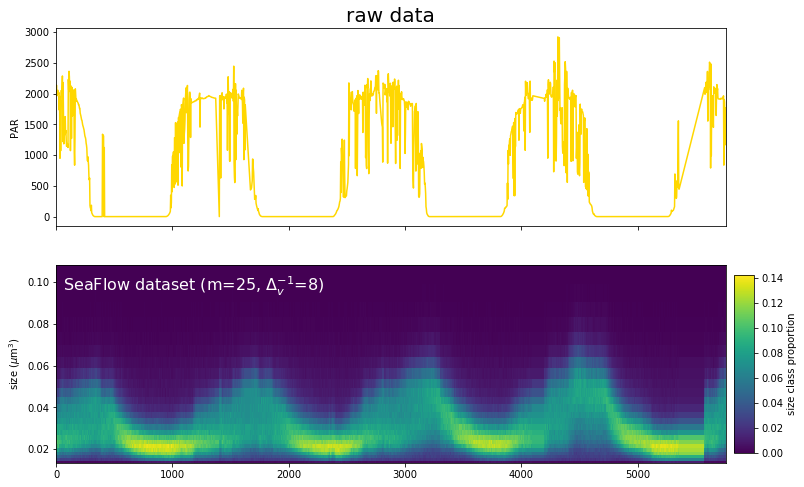

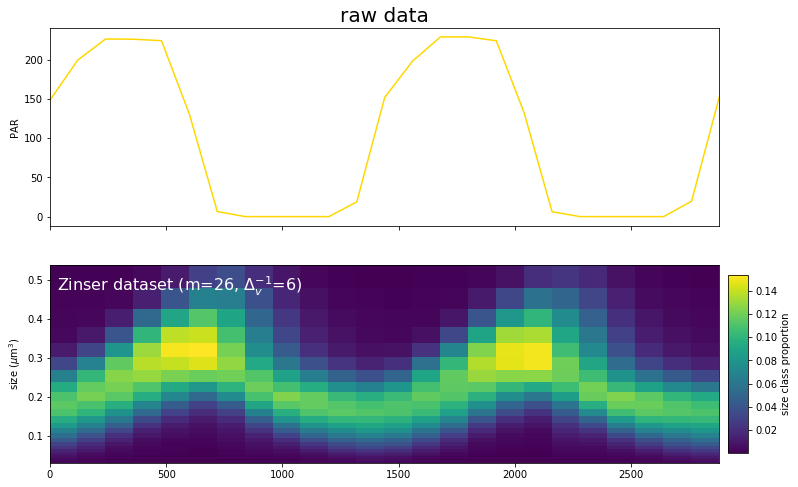

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,dataname in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('raw data', size=20)
    
    ax = axs[0]
    ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[dataname]['v_min']
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[dataname]['time'],v,data_gridded[dataname]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        
        # new: average SeaFlow data in hourly bins
        binsize = 60 # in minutes
        numbins = int(np.ceil(data_gridded[dataname]['time'][-1]/binsize))
        
        data[dataname]['obs'] = np.full((data[dataname]['m'],numbins), fill_value=np.nan)
        data[dataname]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
        i = 0
        for ibin in range(numbins):
            binind = np.logical_and(data_gridded[dataname]['time'] >= ibin*binsize,
                                    data_gridded[dataname]['time'] < (ibin+1)*binsize)
            if np.any(binind):
                # TODO we may want to make this a sum when dealing with counts
                data[dataname]['obs'][:,i] = np.mean(data_gridded[dataname]['w_obs'][:,binind], axis=1)
                data[dataname]['t_obs'][i] = (ibin+0.5) * binsize
                i += 1
        
        data[dataname]['obs'] = data[dataname]['obs'][:,:i]
        data[dataname]['t_obs'] = data[dataname]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    ## load cross-validation testing indices and add them to data
    #data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
    ## remove last index, so that dimensions agree
    #data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    
    # set all indices to zero
    data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # for now, add pseudo-count data
    data[dataname]['obs_count'] = (1000*data[dataname]['obs']).astype(int)
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

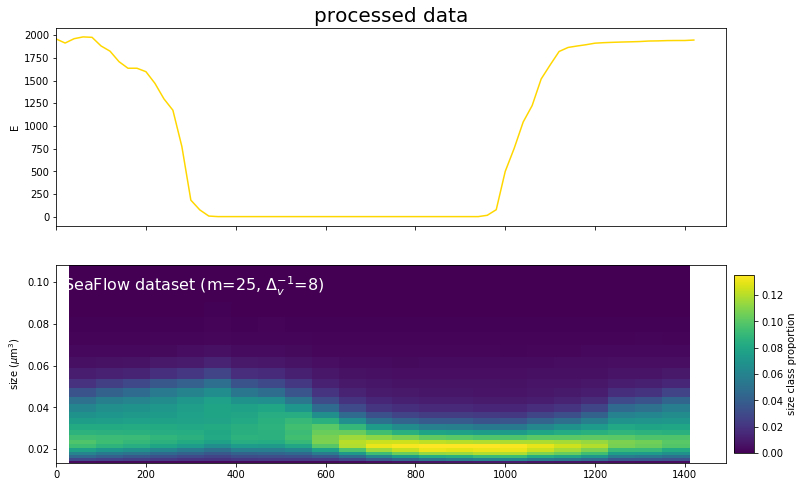

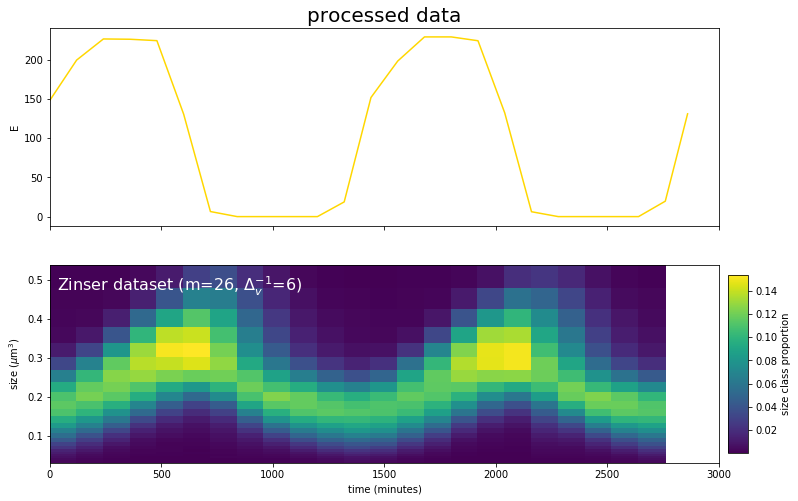

In [4]:
for i,dataname in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('processed data', size=20)
    
    ax = axs[0]
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    ax.plot(t, data[dataname]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[dataname]['v_min']
    delta_v = 1.0/data[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')

None

## run model

In [5]:
import pystan
import re

desc_model = {
    's1':'basic model, free deltas',
    's2':'basic model, monotonic deltas',
    's3':'size-dep growth (gammaiv6)',
    's4':'simple growth, simple respiration (respv1)',
    's5':'simple net growth-respiration (respv2)',
    's6':'size-dep net growth-respiration (respiv6)',
    's7':'size-dep growth, size-dep respiration (respiv7)',
    's8':'size-dep growth, size-dep respiration (respiv6), light-dep div',
    's9':'size-dep growth, size-dep respiration (respiv7), light-dep div',
}
# preparing for some regular expression magic
model_code_replacements = {
    's1':(),
    's2':(),
    's3':(),
    's4':(),
    's5':(),
    's6':(),
    's7':(),
    's8':(),
    's9':(),
    's10':(),
}
model_stan_key = {
    's1':'c1',
    's2':'c2',
    's3':'c3',
    's4':'c4',
    's5':'c5',
    's6':'c6',
    's7':'c7',
    's8':'c8',
    's9':'c9',
    's10':'c10',
}
stan_files = {
    'c1':'stancode_gallery1/matrixmodel_multinom_estinilnorm_freedelta_normparam_trackgrowth_xval.stan',
    'c2':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_normparam_trackgrowth_xval.stan',
    'c3':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_gammaiv6_normparam_trackgrowth_xval.stan',
    'c4':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respv1_normparam_trackgrowth_xval.stan',
    'c5':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    'c6':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',
    'c7':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',
    'c8':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv6_normparam_trackgrowth_xval.stan',
    'c9':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv7_normparam_trackgrowth_xval.stan',
    'c10':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for name in desc_model:
    code_split = stan_base_code[model_stan_key[name]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[name]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(name, line_new))
        code_split_new.append(line_new)
                
    stan_code[name] = '\n'.join(code_split_new)

for name in desc_model:
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code[name]:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(model_code=stan_code[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL s1 NOW.


s1: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s2 NOW.


s2: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s3 NOW.


s3: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s4 NOW.


s4: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s5 NOW.


s5: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s6 NOW.


s6: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s7 NOW.


s7: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s8 NOW.


s8: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s9 NOW.


s9: compiling


In [6]:
import time
refit_all = False

def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

def get_mean_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmean(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}
if 'meanrhats' not in globals():
    meanrhats = {}
if 'sampling_time' not in globals():
    sampling_time = {}

    
try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    if name not in maxrhats:
        maxrhats[name] = {}
    if name not in meanrhats:
        meanrhats[name] = {}
    if name not in sampling_time:
        sampling_time[name] = {}
    for dataname in data:
        if dataname not in maxrhats[name]:
            maxrhats[name][dataname] = []
        if dataname not in meanrhats[name]:
            meanrhats[name][dataname] = []
        if dataname not in sampling_time[name]:
            sampling_time[name][dataname] = []
        if name in mcmcs:
            if dataname in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            t0 = time.time()
            mcmcs[name][dataname] = models[name].sampling(data=data[dataname], iter=2000)
            sampling_time[name][dataname].append(time.time() - t0) # in seconds
            meanrhats[name][dataname].append(get_mean_rhat(mcmcs[name][dataname]))
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][dataname])
            maxrhats[name][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))

s1 (basic model, free deltas)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu             3.9    0.02   0.97   1.92   3.24   3.88   4.59   5.74   2668    1.0
delta_sigma        11.45    0.04   2.06   7.91  10.01  11.27  12.75  15.96   2632    1.0
delta_max[1]         0.2  8.0e-4   0.02   0.16   0.18    0.2   0.21   0.24    659   1.01
delta_max[2]        1.25  5.1e-3   0.08   1.11   1.19   1.24    1.3   1.41    245   1.03
delta_max[3]        1.52  4.0e-3   0.09   1.36   1.46   1.52   1.58    1.7    484   1.01
delta_max[4]        2.08  4.8e-3   0.12   1.87    2.0   2.08   2.16   2.33    590   1.01
delta_max[5]        2.54  5.5e-3   0.14   2.27   2.44   2.54   2.64   2.84    681   1.01
delta_max[6]        3.05  7.8e-3   0.19   2.69   2.92   3.05   3.18   3.45    618   1.01
delta_max[7]        3

s1 (basic model, free deltas)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            3.21    0.01    0.8   1.66   2.66   3.19   3.76   4.79   3561    1.0
delta_sigma         6.09    0.02   0.86   4.65   5.49   6.01   6.61   8.02   2060    1.0
delta_max[1]         0.4  2.2e-3   0.09   0.25   0.34    0.4   0.46   0.61   1655    1.0
delta_max[2]        0.36  1.9e-3   0.07   0.23   0.32   0.36   0.41   0.53   1508    1.0
delta_max[3]        0.33  1.0e-3   0.06   0.23   0.29   0.33   0.37   0.46   3276    1.0
delta_max[4]        0.35  9.2e-4   0.05   0.25   0.31   0.34   0.38   0.46   3204    1.0
delta_max[5]        0.38  1.4e-3   0.05   0.29   0.35   0.38   0.41   0.48   1082   1.01
delta_max[6]        0.41  7.7e-4   0.04   0.33   0.38   0.41   0.44    0.5   3269    1.0
delta_max[7]        0

s2: in try 1/3 found Rhat=1.235, trying again


s2 (basic model, monotonic deltas)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.31  3.6e-3   0.08   0.17   0.25    0.3   0.35   0.51    552   1.01
gamma_max            1.39  1.5e-3   0.04    1.3   1.36   1.38   1.41   1.47    780   1.01
E_star               34.5    3.29  35.47   0.13   1.38  33.56  55.93 104.64    116   1.04
divrate              0.79  3.3e-3   0.03   0.74   0.77   0.79   0.81   0.84     75   1.05
delta_max[1]          0.2  1.4e-3   0.02   0.16   0.18    0.2   0.21   0.24    234   1.02
delta_max[2]         1.25  7.4e-3   0.08   1.11   1.19   1.24    1.3   1.42    123   1.03
delta_max[3]         1.53  6.0e-3   0.09   1.37   1.47   1.53   1.59   1.72    223   1.03
delta_max[4]         2.09  9.1e-3   0.12   1.88   2.01   2.09   2.17   2.33    164   1.03
delta_m

s2 (basic model, monotonic deltas)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.65  2.3e-3   0.14   0.39   0.54   0.63   0.73   0.96   3841    1.0
gamma_max            8.96    0.09   0.83   6.51   8.52   9.15   9.61   9.96     94   1.04
E_star             328.56    4.51  43.32 196.97 305.68 337.16 360.97 385.19     92   1.04
divrate               1.8  7.2e-4   0.03   1.74   1.78    1.8   1.82   1.85   1533    1.0
delta_max[1]         0.28  1.3e-3   0.04    0.2   0.25   0.28    0.3   0.34    747    1.0
delta_max[2]         0.31  4.0e-4   0.03   0.26    0.3   0.32   0.33   0.36   4414    1.0
delta_max[3]         0.34  3.8e-4   0.02   0.29   0.32   0.34   0.35   0.38   4042    1.0
delta_max[4]         0.36  3.4e-4   0.02   0.31   0.35   0.36   0.38   0.41   4729    1.0
delta_m

s3: in try 1/3 found Rhat=1.127, trying again


s3: in try 2/3 found Rhat=1.245, trying again


s3 (size-dep growth (gammaiv6))
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.31  3.5e-3   0.08   0.18   0.25   0.29   0.35   0.51    580    1.0
gamma_max            1.39  1.7e-3   0.04    1.3   1.37    1.4   1.42   1.48    672   1.01
xi                   0.06  3.5e-3    0.1  -0.14  -0.01   0.06   0.13   0.25    827    1.0
E_star               34.4    3.62  32.13   0.13   1.56  35.06  55.32 102.58     79   1.04
divrate              0.79  3.0e-3   0.03   0.74   0.77   0.79   0.81   0.85     92   1.03
delta_max[1]          0.2  1.2e-3   0.02   0.16   0.18    0.2   0.21   0.24    327   1.01
delta_max[2]         1.25  8.8e-3   0.08    1.1   1.19   1.25   1.31   1.42     93   1.03
delta_max[3]         1.53  5.8e-3   0.09   1.35   1.47   1.53   1.59   1.72    243   1.01
delta_max[

s4 (simple growth, simple respiration (respv1))
Inference for Stan model: s4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.29  3.8e-3   0.08   0.16   0.23   0.28   0.33   0.49    453    1.0
gamma_max            1.42  2.0e-3   0.05   1.33   1.39   1.42   1.45   1.51    514   1.01
rho_max              0.11  1.1e-3   0.02   0.06   0.09   0.11   0.12   0.14    320   1.01
E_star               20.7    3.26  26.76   0.11   1.02   2.73  37.77  87.08     68   1.05
divrate              0.71  2.4e-3   0.03   0.66   0.69   0.72   0.74   0.77    156   1.02
delta_max[1]         0.03  1.3e-3   0.02 1.2e-3   0.01   0.02   0.04   0.09    352    1.0
delta_max[2]         1.08  5.6e-3   0.09   0.89   1.01   1.08   1.14   1.24    255   1.01
delta_max[3]         1.35  6.0e-3    0.1   1.16   1.28   1.34   1.41   1.55    277  

s5 (simple net growth-respiration (respv2))
Inference for Stan model: s5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda          0.3  3.8e-3   0.08   0.17   0.24   0.29   0.34   0.49    440   1.01
gamma_max            1.39  2.0e-3   0.05    1.3   1.36   1.38   1.42   1.48    518   1.01
rho_max              0.01  4.3e-4   0.01 4.1e-4 5.2e-3   0.01   0.02   0.04    636   1.01
E_star              30.78    3.72   33.3   0.18   1.24  26.43  52.88  98.71     80   1.03
divrate              0.78  2.8e-3   0.03   0.73   0.76   0.78    0.8   0.84    106   1.02
delta_max[1]         0.18  1.1e-3   0.02   0.13   0.16   0.18    0.2   0.23    503    1.0
delta_max[2]         1.24  7.5e-3   0.08   1.08   1.18   1.23    1.3   1.39    118   1.02
delta_max[3]         1.51  5.9e-3   0.09   1.34   1.45    1.5   1.56   1.68    218   1.0

s6 (size-dep net growth-respiration (respiv6))
Inference for Stan model: s6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda          0.3  5.0e-3   0.09   0.16   0.23   0.29   0.35   0.49    291   1.02
gamma_max            1.39  2.2e-3   0.04    1.3   1.36   1.39   1.42   1.48    427   1.02
xi                   0.05  3.4e-3    0.1  -0.15  -0.01   0.05   0.12   0.25    871    1.0
xir               -8.1e-3  4.1e-3    0.1  -0.21  -0.08-3.8e-3   0.06   0.19    633   1.01
rho_max              0.01  4.3e-4   0.01 4.4e-4 5.4e-3   0.01   0.02   0.04    666    1.0
E_star              28.44    3.17  31.48   0.18   1.24  20.88  49.72  96.78     99   1.02
divrate              0.78  2.7e-3   0.03   0.73   0.76   0.78    0.8   0.84    119   1.01
delta_max[1]         0.18  1.4e-3   0.03   0.13   0.16   0.18   0.19   0.23    334   

s7 (size-dep growth, size-dep respiration (respiv7))
Inference for Stan model: s7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.29  4.5e-3   0.08   0.17   0.23   0.28   0.34   0.47    310   1.02
gamma_max            1.43  1.9e-3   0.05   1.34    1.4   1.43   1.46   1.52    584    1.0
xi                   0.05  4.2e-3    0.1  -0.13  -0.01   0.05   0.12   0.24    565    1.0
xir               -3.8e-3  4.3e-3    0.1  -0.19  -0.07-3.0e-3   0.06    0.2    538    1.0
rho_max              0.11  1.2e-3   0.02   0.07   0.09   0.11   0.12   0.15    313   1.01
E_star              14.25    2.35  23.26    0.1   0.83   1.76  21.92  78.71     98   1.03
divrate              0.72  1.8e-3   0.03   0.66    0.7   0.72   0.74   0.77    227   1.01
delta_max[1]         0.03  1.1e-3   0.02 9.6e-4   0.01   0.02   0.04   0.09    

s7 (size-dep growth, size-dep respiration (respiv7))
Inference for Stan model: s7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.79  9.4e-3   0.63   1.72   2.34   2.74   3.17   4.15   4480    1.0
gamma_max            9.47  8.7e-3   0.39   8.57   9.23   9.55   9.79   9.98   2033    1.0
xi                  -1.87  1.2e-3   0.08  -2.03  -1.93  -1.87  -1.82  -1.71   4858    1.0
xir                  0.57  1.6e-3   0.08    0.4   0.51   0.57   0.63   0.73   2865    1.0
rho_max              1.75  1.3e-3   0.07   1.61    1.7   1.75    1.8   1.89   2831    1.0
E_star             167.08    0.32  14.75 134.29 157.88 169.07 177.84 191.28   2082    1.0
divrate              0.54  4.8e-4   0.03   0.48   0.52   0.54   0.56    0.6   4162    1.0
delta_max[1]         0.06  5.8e-4   0.03 5.6e-3   0.04   0.06   0.08   0.12   2

s8 (size-dep growth, size-dep respiration (respiv6), light-dep div)
Inference for Stan model: s8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.32  3.2e-3   0.09   0.17   0.25   0.31   0.37   0.53    841   1.01
delta_lightthresh   10.13    0.21   7.86    0.4   3.76    8.1  15.06  28.12   1380    1.0
delta_lightsigma      0.2  6.2e-4   0.02   0.16   0.19    0.2   0.21   0.24   1098    1.0
gamma_max            0.79  1.2e-3   0.04   0.71   0.76   0.79   0.81   0.86   1024   1.01
xi                -7.0e-4  2.6e-3    0.1  -0.19  -0.07-8.7e-4   0.07    0.2   1451    1.0
xir               -9.9e-5  2.5e-3    0.1   -0.2  -0.07-1.6e-4   0.06   0.21   1653    1.0
rho_max              0.13  6.8e-4   0.02   0.09   0.11   0.13   0.14   0.17    973   1.01
E_star              13.44    1.17  37.85   0.19   1.65   4.02   

s9 (size-dep growth, size-dep respiration (respiv7), light-dep div)
Inference for Stan model: s9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.34  3.0e-3    0.1   0.18   0.27   0.32    0.4   0.57   1079    1.0
delta_lightthresh    11.7    0.18   7.86   0.63   5.29  10.62  16.93   29.1   1991    1.0
delta_lightsigma      0.2  4.7e-4   0.02   0.16   0.19    0.2   0.21   0.24   1857    1.0
gamma_max            1.08  1.5e-3   0.05   0.99   1.04   1.08   1.11   1.17   1021    1.0
xi                  -0.01  2.3e-3    0.1  -0.23  -0.07  -0.01   0.06   0.19   2004    1.0
xir                5.2e-3  2.4e-3    0.1   -0.2  -0.06 6.0e-3   0.07   0.21   1800    1.0
rho_max              0.27  8.5e-4   0.03   0.22   0.25   0.27   0.29   0.32    943    1.0
E_star               3.42    0.08   4.07    0.1   1.17   2.44   

s9 (size-dep growth, size-dep respiration (respiv7), light-dep div)
Inference for Stan model: s9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.69  8.2e-3   0.61   1.62   2.26   2.64   3.06   4.01   5453    1.0
delta_lightthresh   40.19     0.1   5.93  28.07  36.31  40.46  44.16  51.86   3252    1.0
delta_lightsigma     0.21  3.3e-4   0.02   0.17    0.2   0.21   0.23   0.25   3837    1.0
gamma_max            8.31    0.02   0.98    6.5   7.55   8.33   9.13    9.9   2401    1.0
xi                  -2.23  1.2e-3   0.07  -2.37  -2.28  -2.23  -2.18  -2.09   3232    1.0
xir                  1.03  1.5e-3   0.08   0.87   0.98   1.03   1.09    1.2   3307    1.0
rho_max              1.42  1.9e-3    0.1   1.23   1.35   1.42   1.49   1.62   2741    1.0
E_star             230.67    0.99  46.82 143.26 193.73 231.39 26

## plot the results

In [7]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

maxrhats_final = {name:{dataname:get_max_rhat(mcmcs[name][dataname]) for dataname in data} for name in mcmcs}        

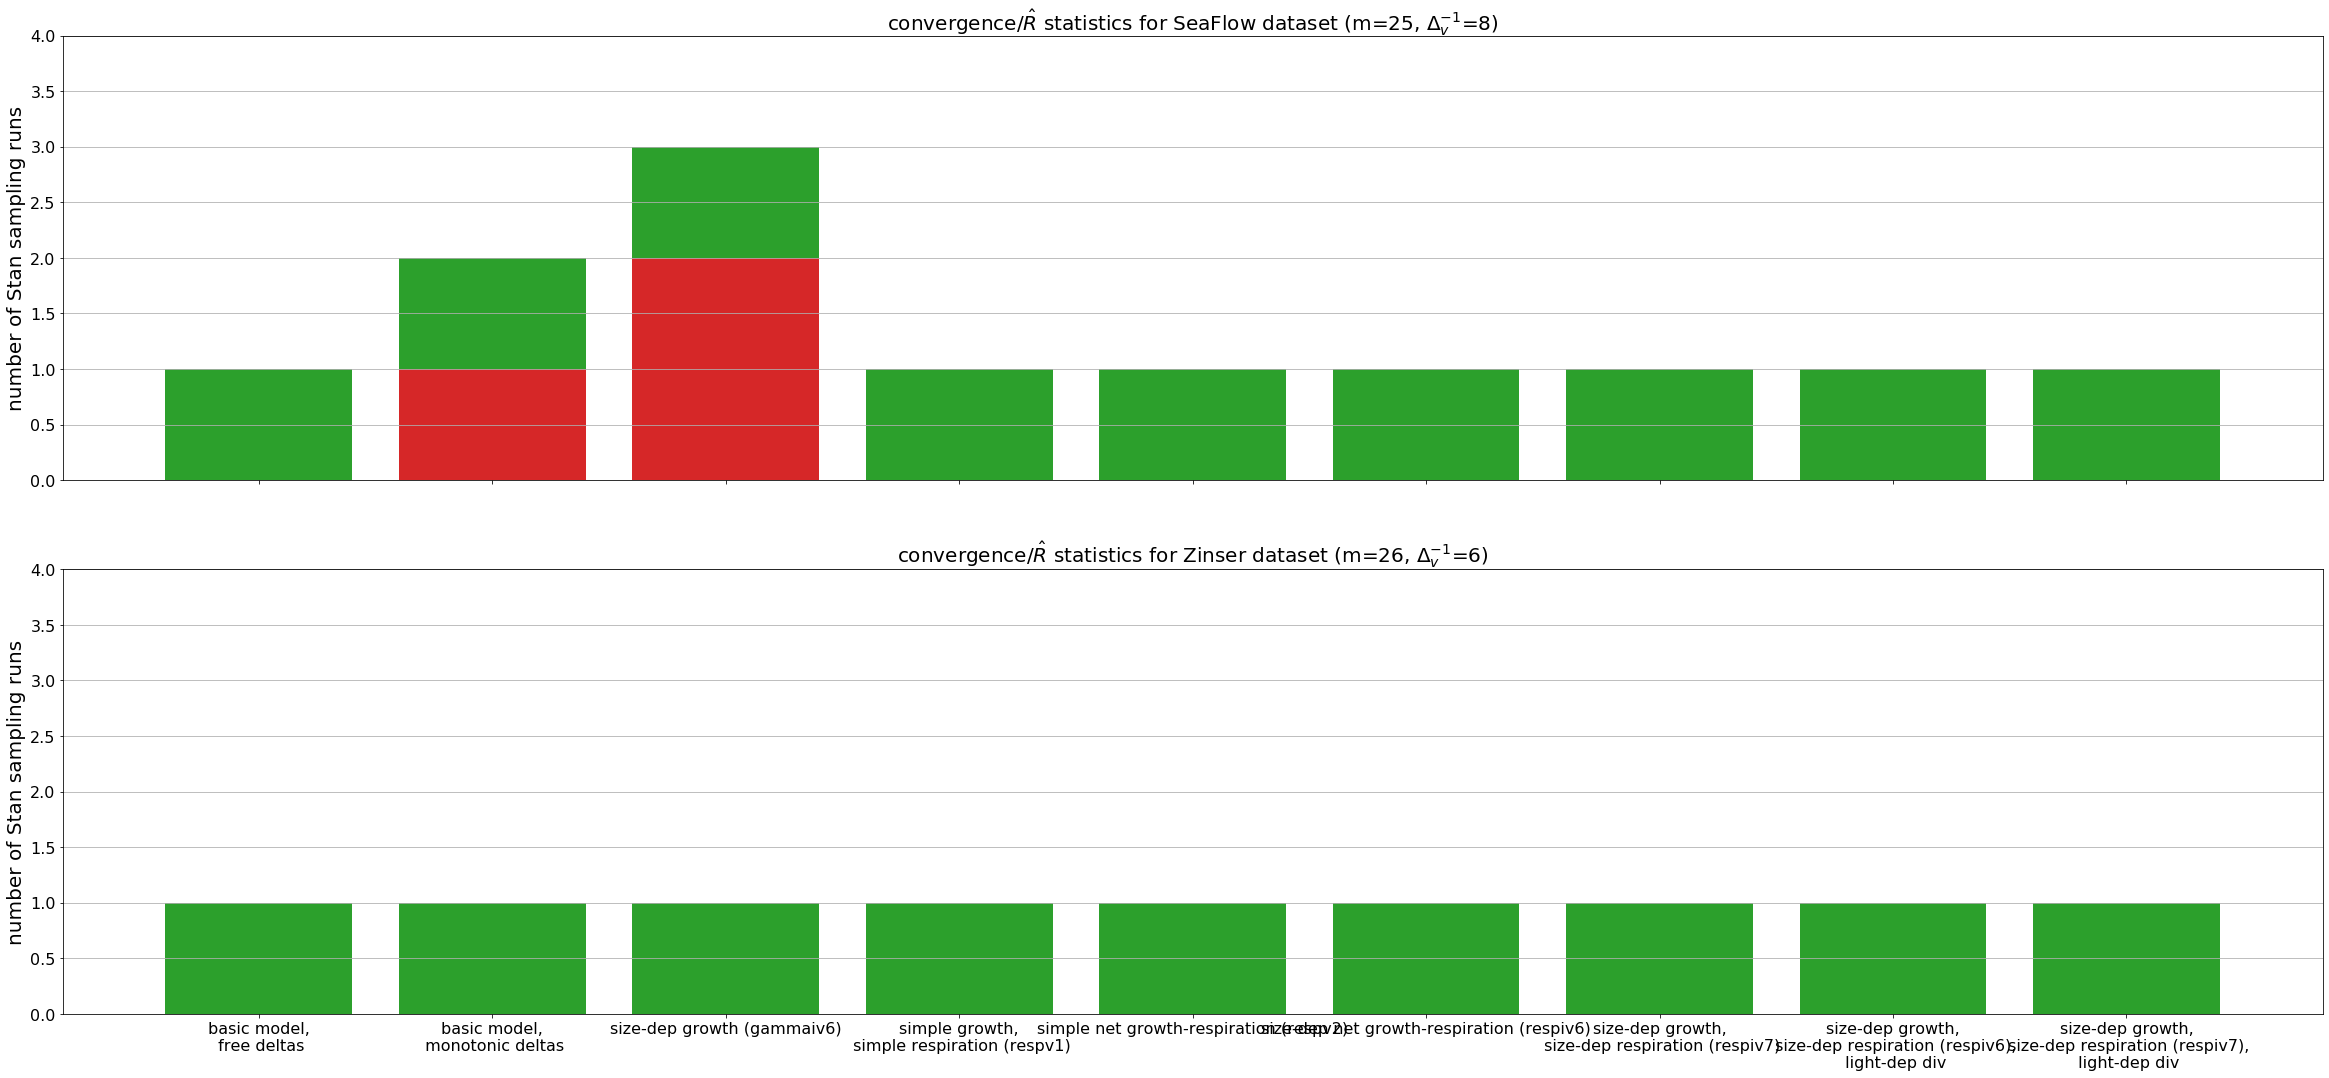

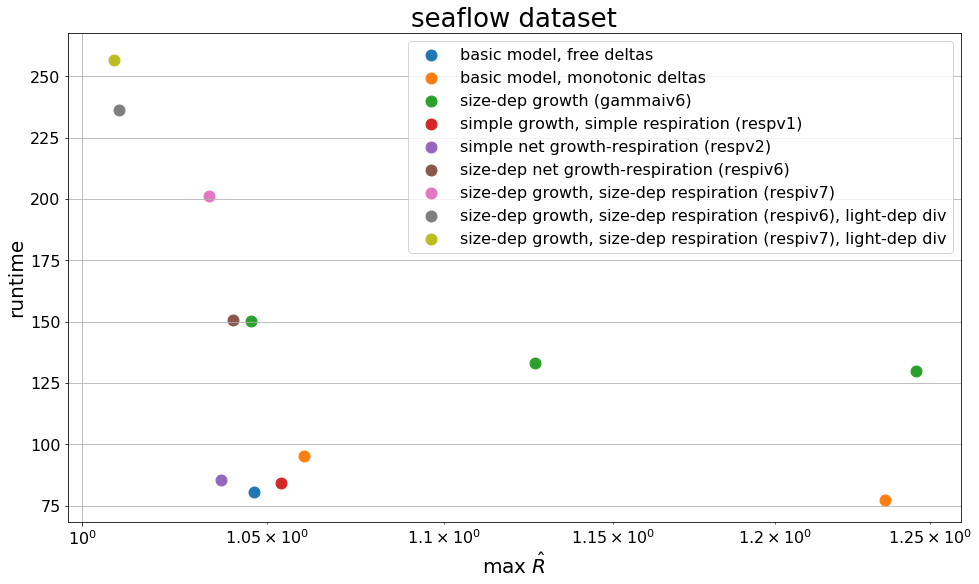

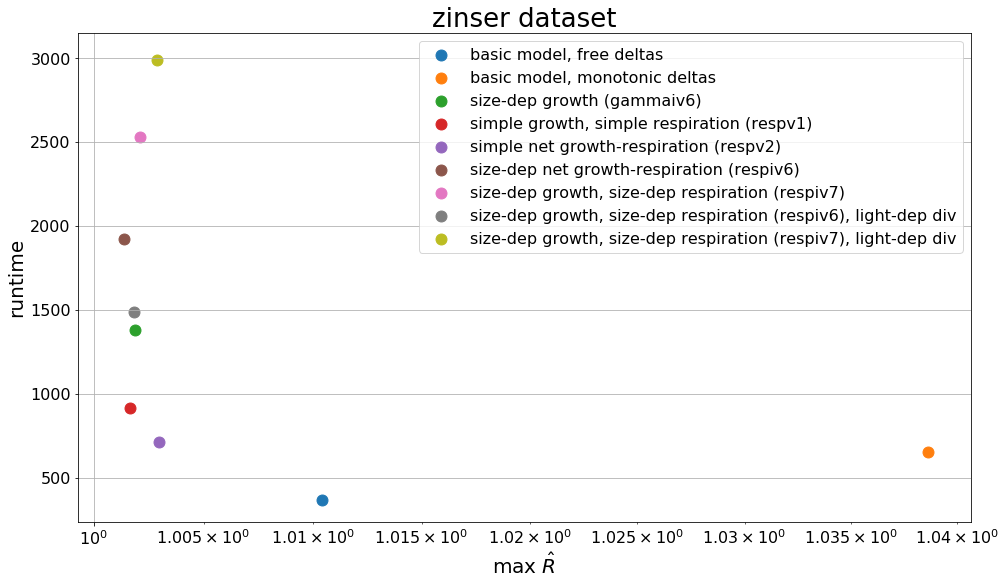

In [8]:
ylim_top = 0
for dataname in data:
    for name in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[name][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*4.5),len(data)*9), sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[name][dataname])
        height_good = len(maxrhats[name][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks.append(x)
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

for dataname in data:
    fig, ax = plt.subplots(figsize=(16,9))
    ax.set_title('{} dataset'.format(dataname))
    for name in mcmcs:
        ax.scatter(maxrhats[name][dataname], sampling_time[name][dataname], label='{}'.format(desc_model[name]), s=120)

    ax.set(xlabel='max $\\hat{R}$', ylabel='runtime')
    ax.set_xscale('log')
    ax.grid(True)
    ax.legend()

/home/paul/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paul/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


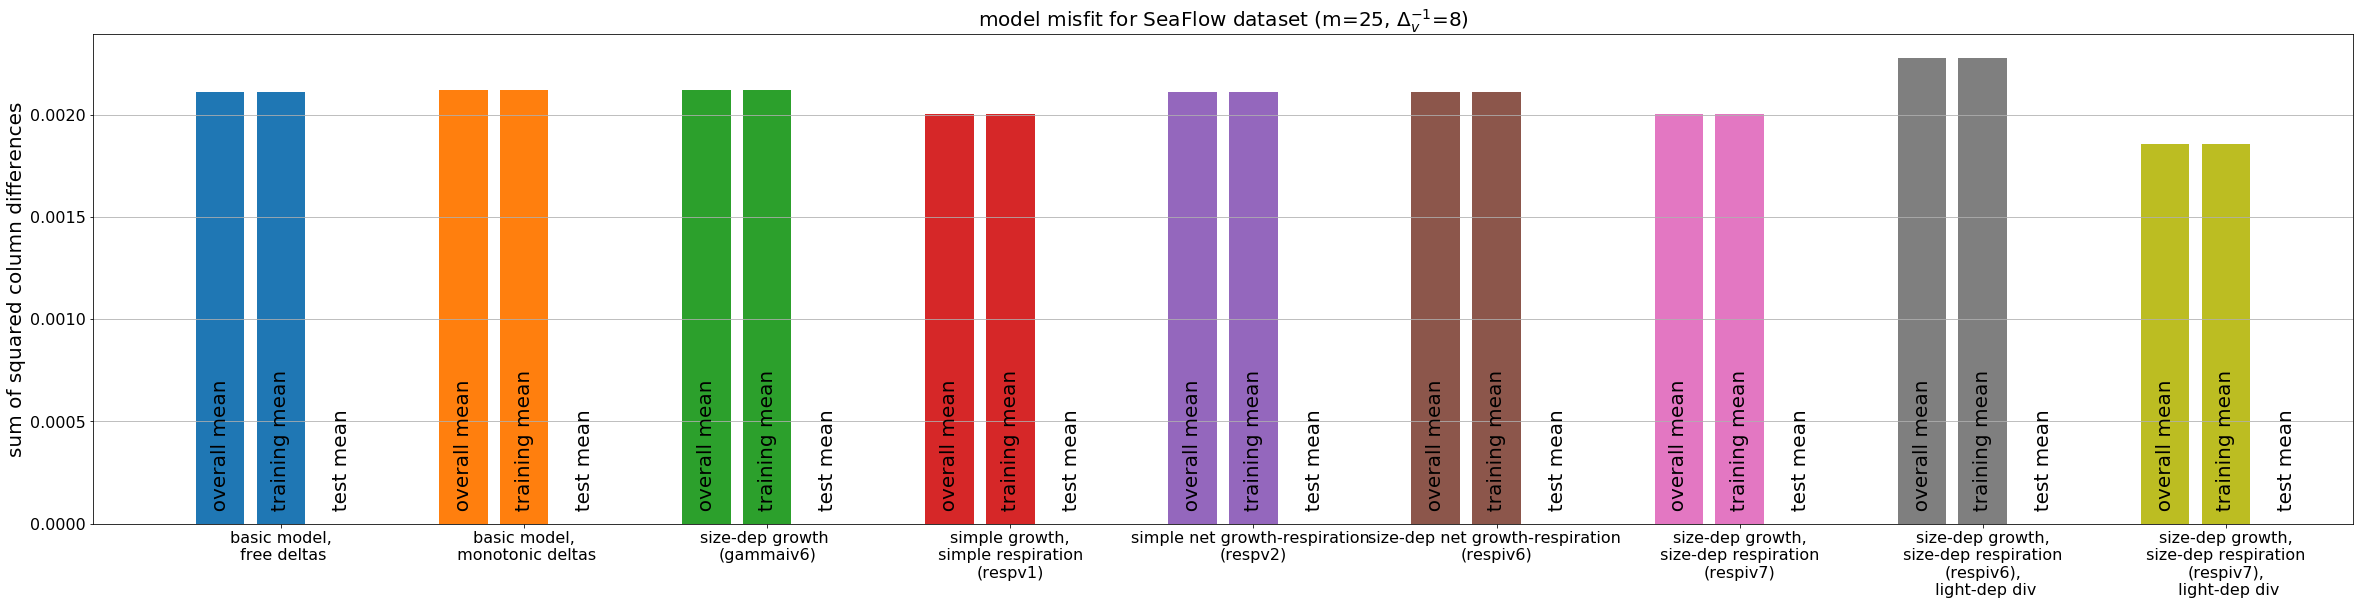

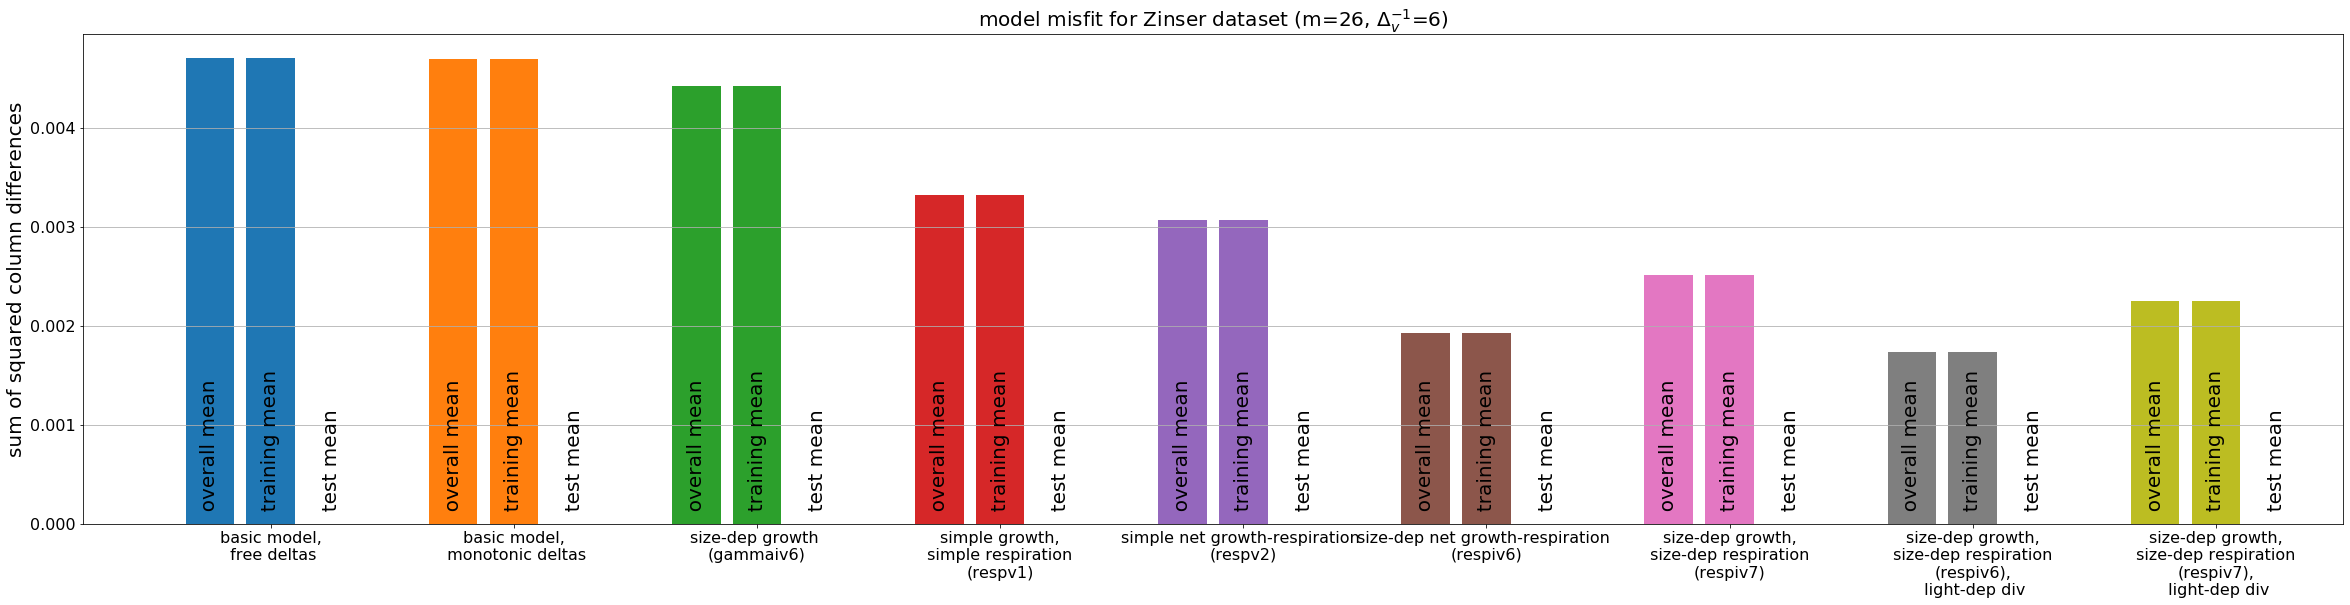

In [9]:
height = np.zeros(3)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        height[1] = np.mean(e[data[dataname]['i_test'] == 0])
        height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = 4*i+np.arange(3)
        ax.bar(x=x, height=height)
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(x[1], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[1])
        xticklabels.append(desc_model[name].replace(',',',\n').replace('(','\n('))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

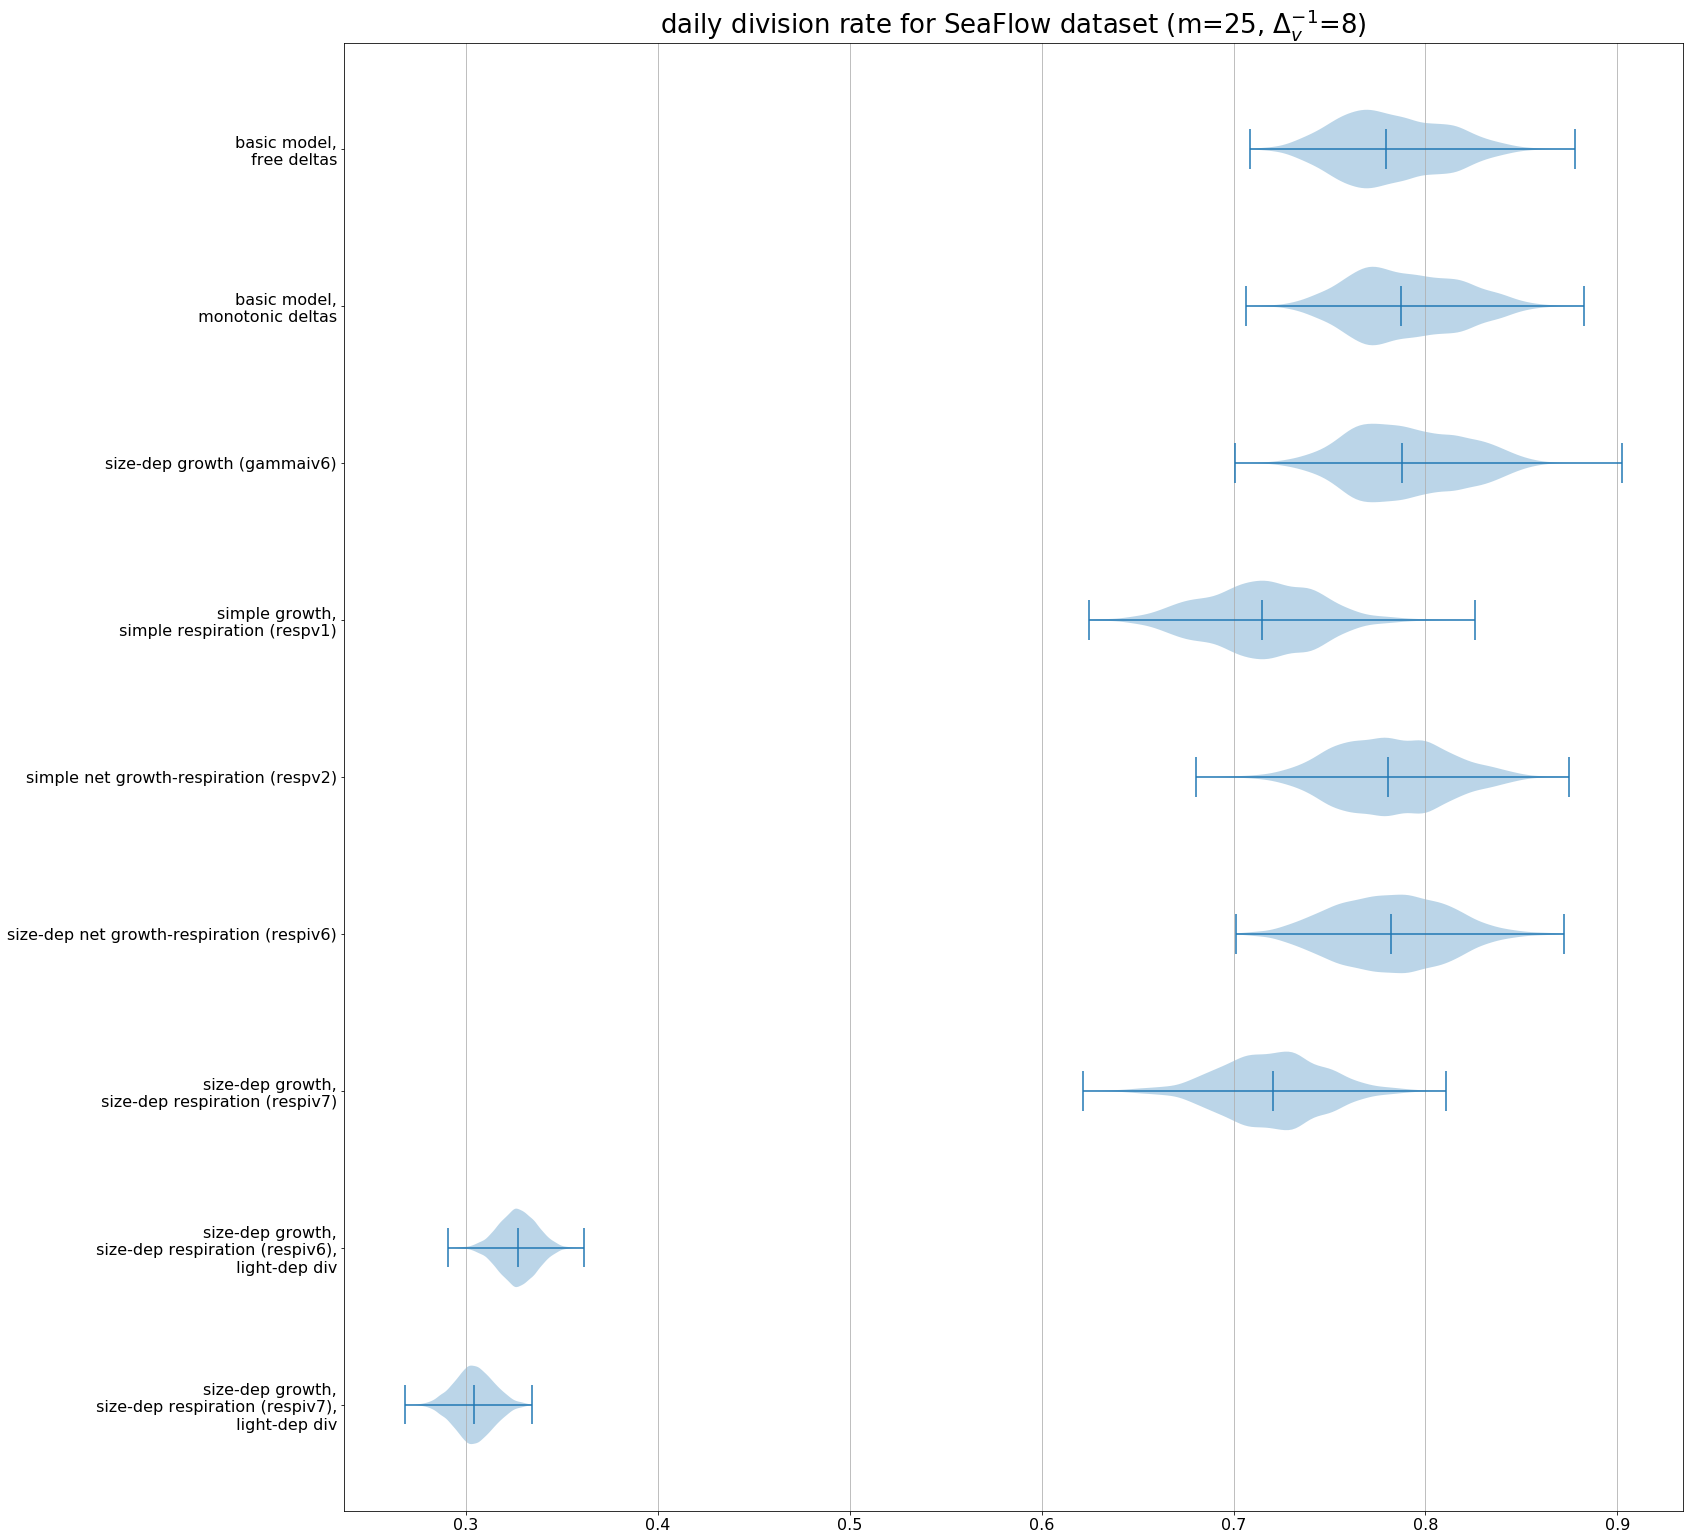

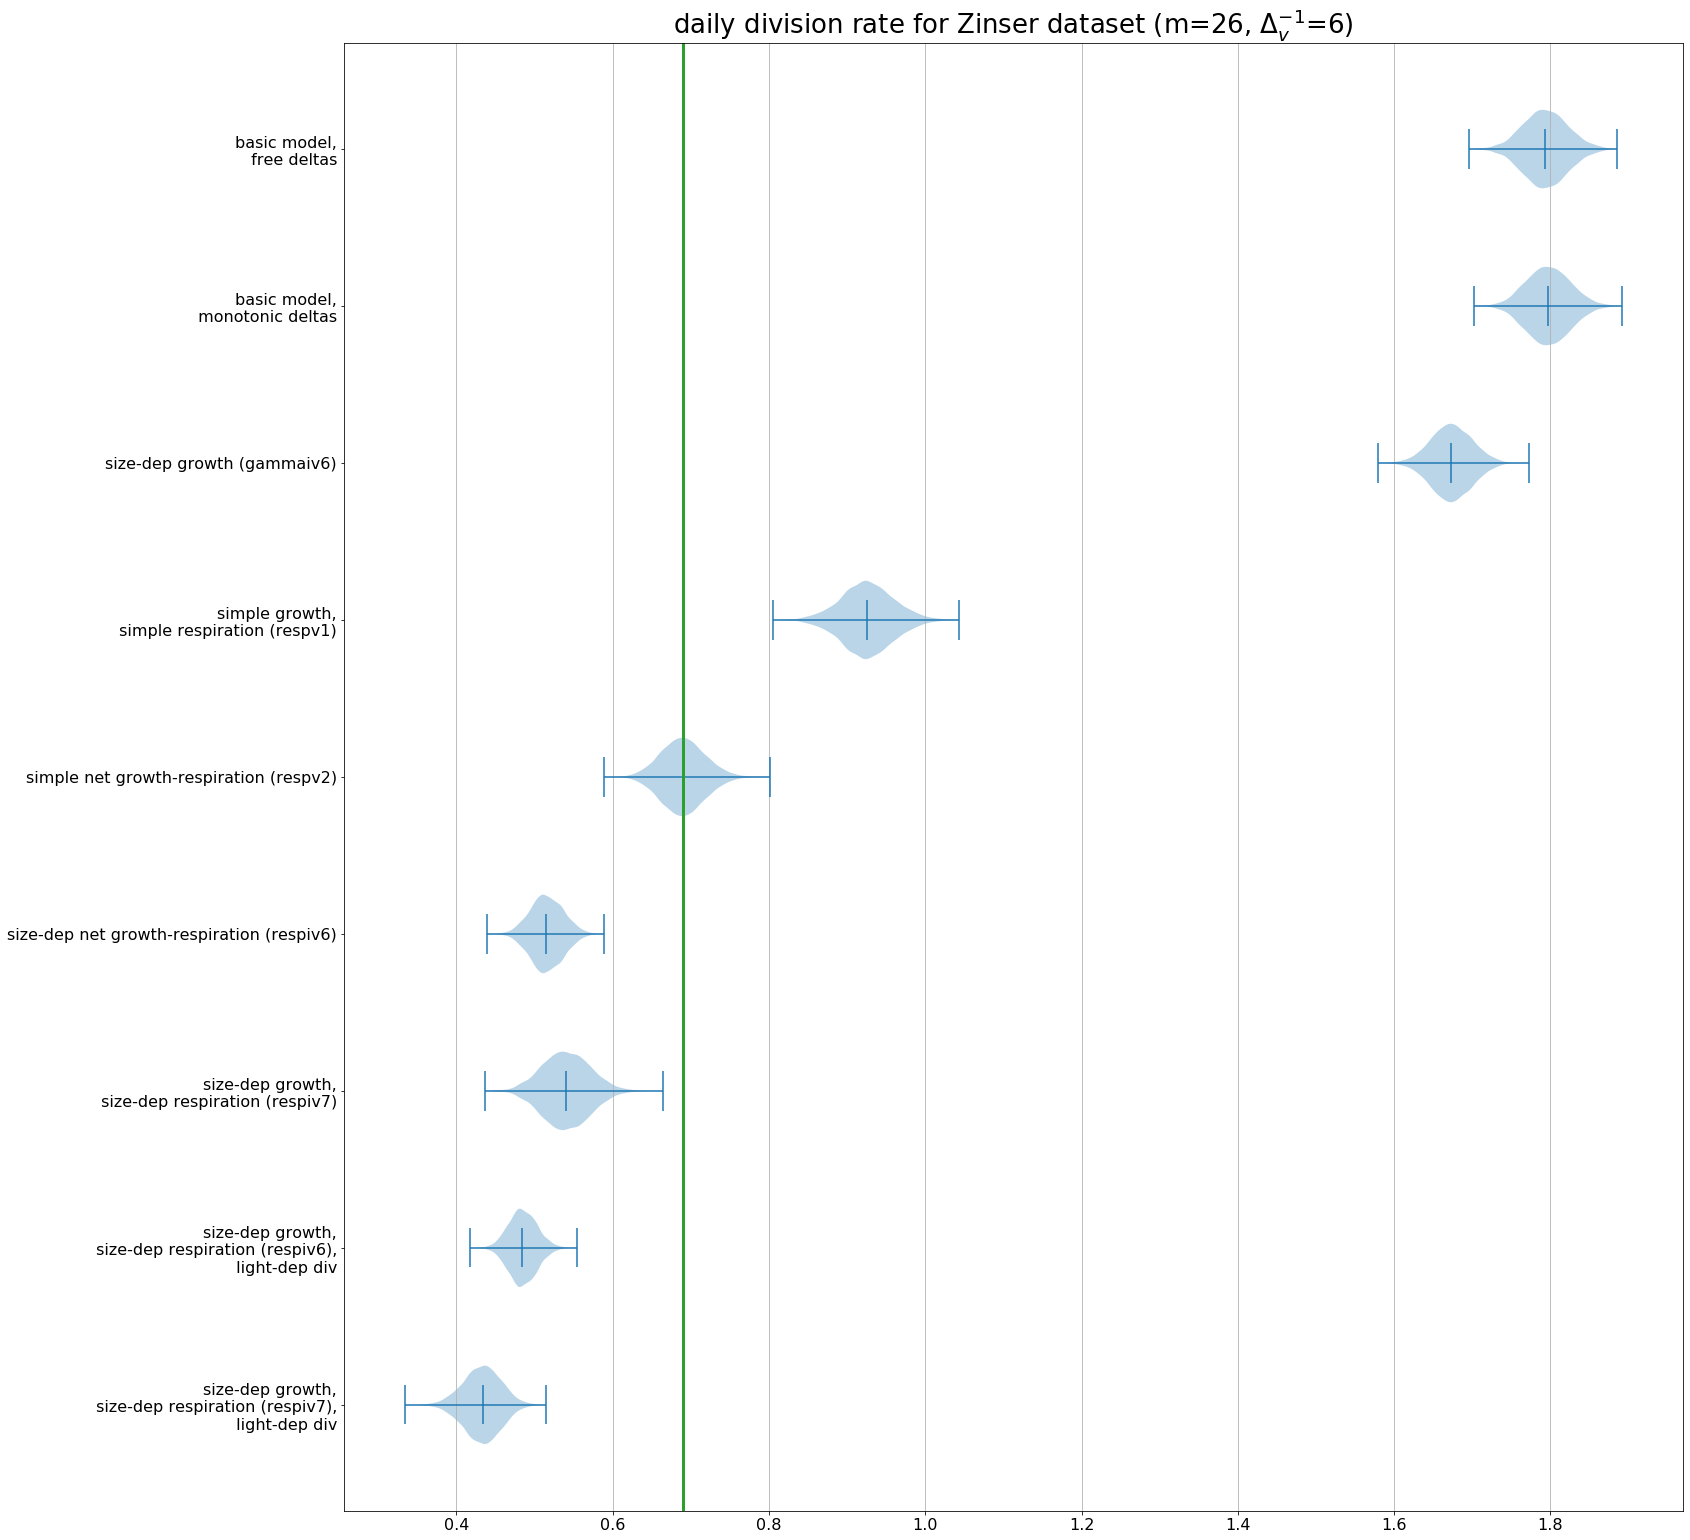

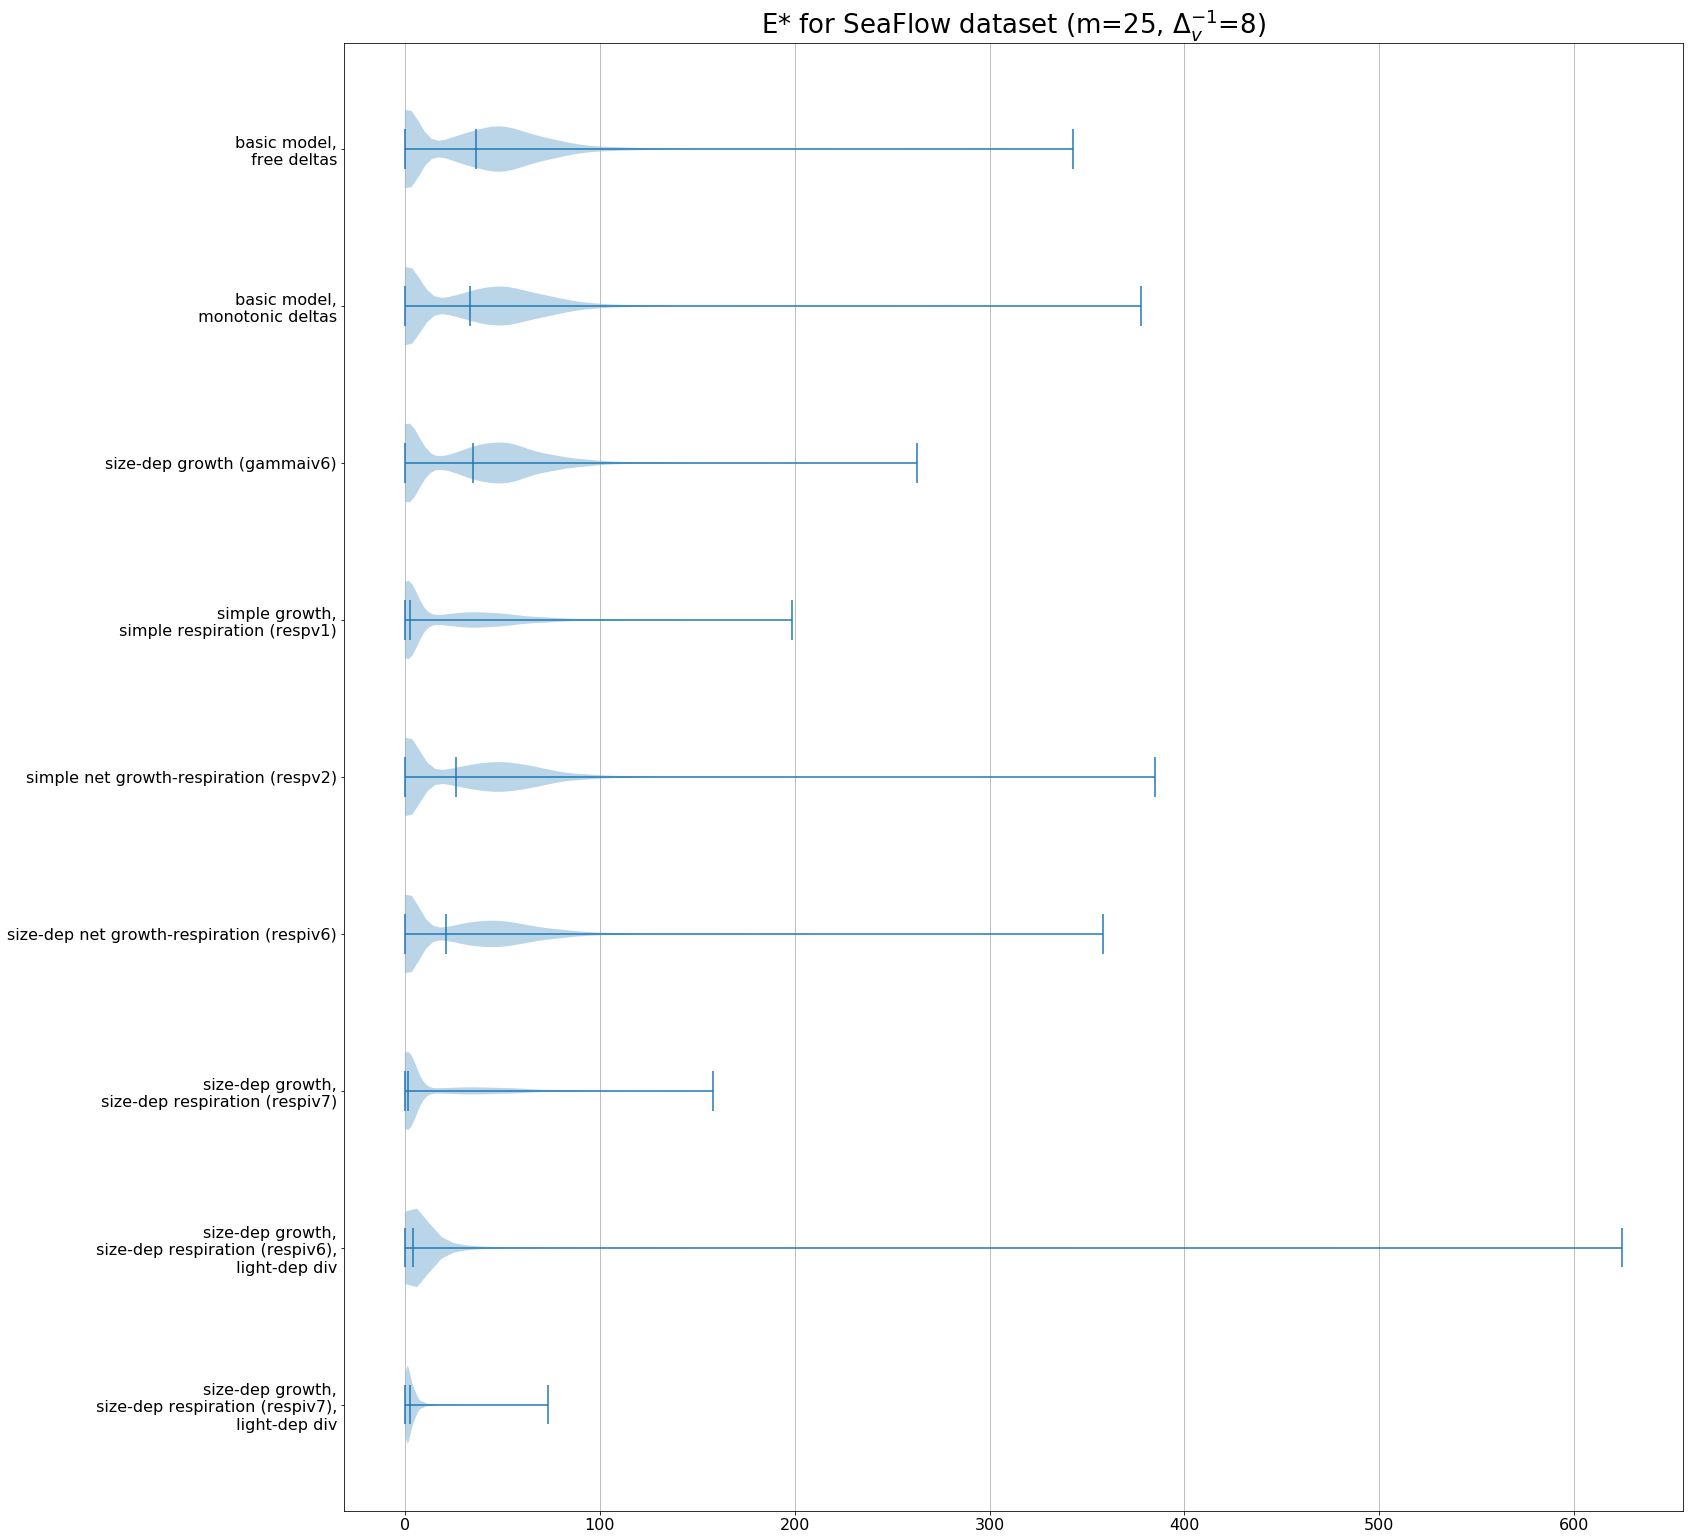

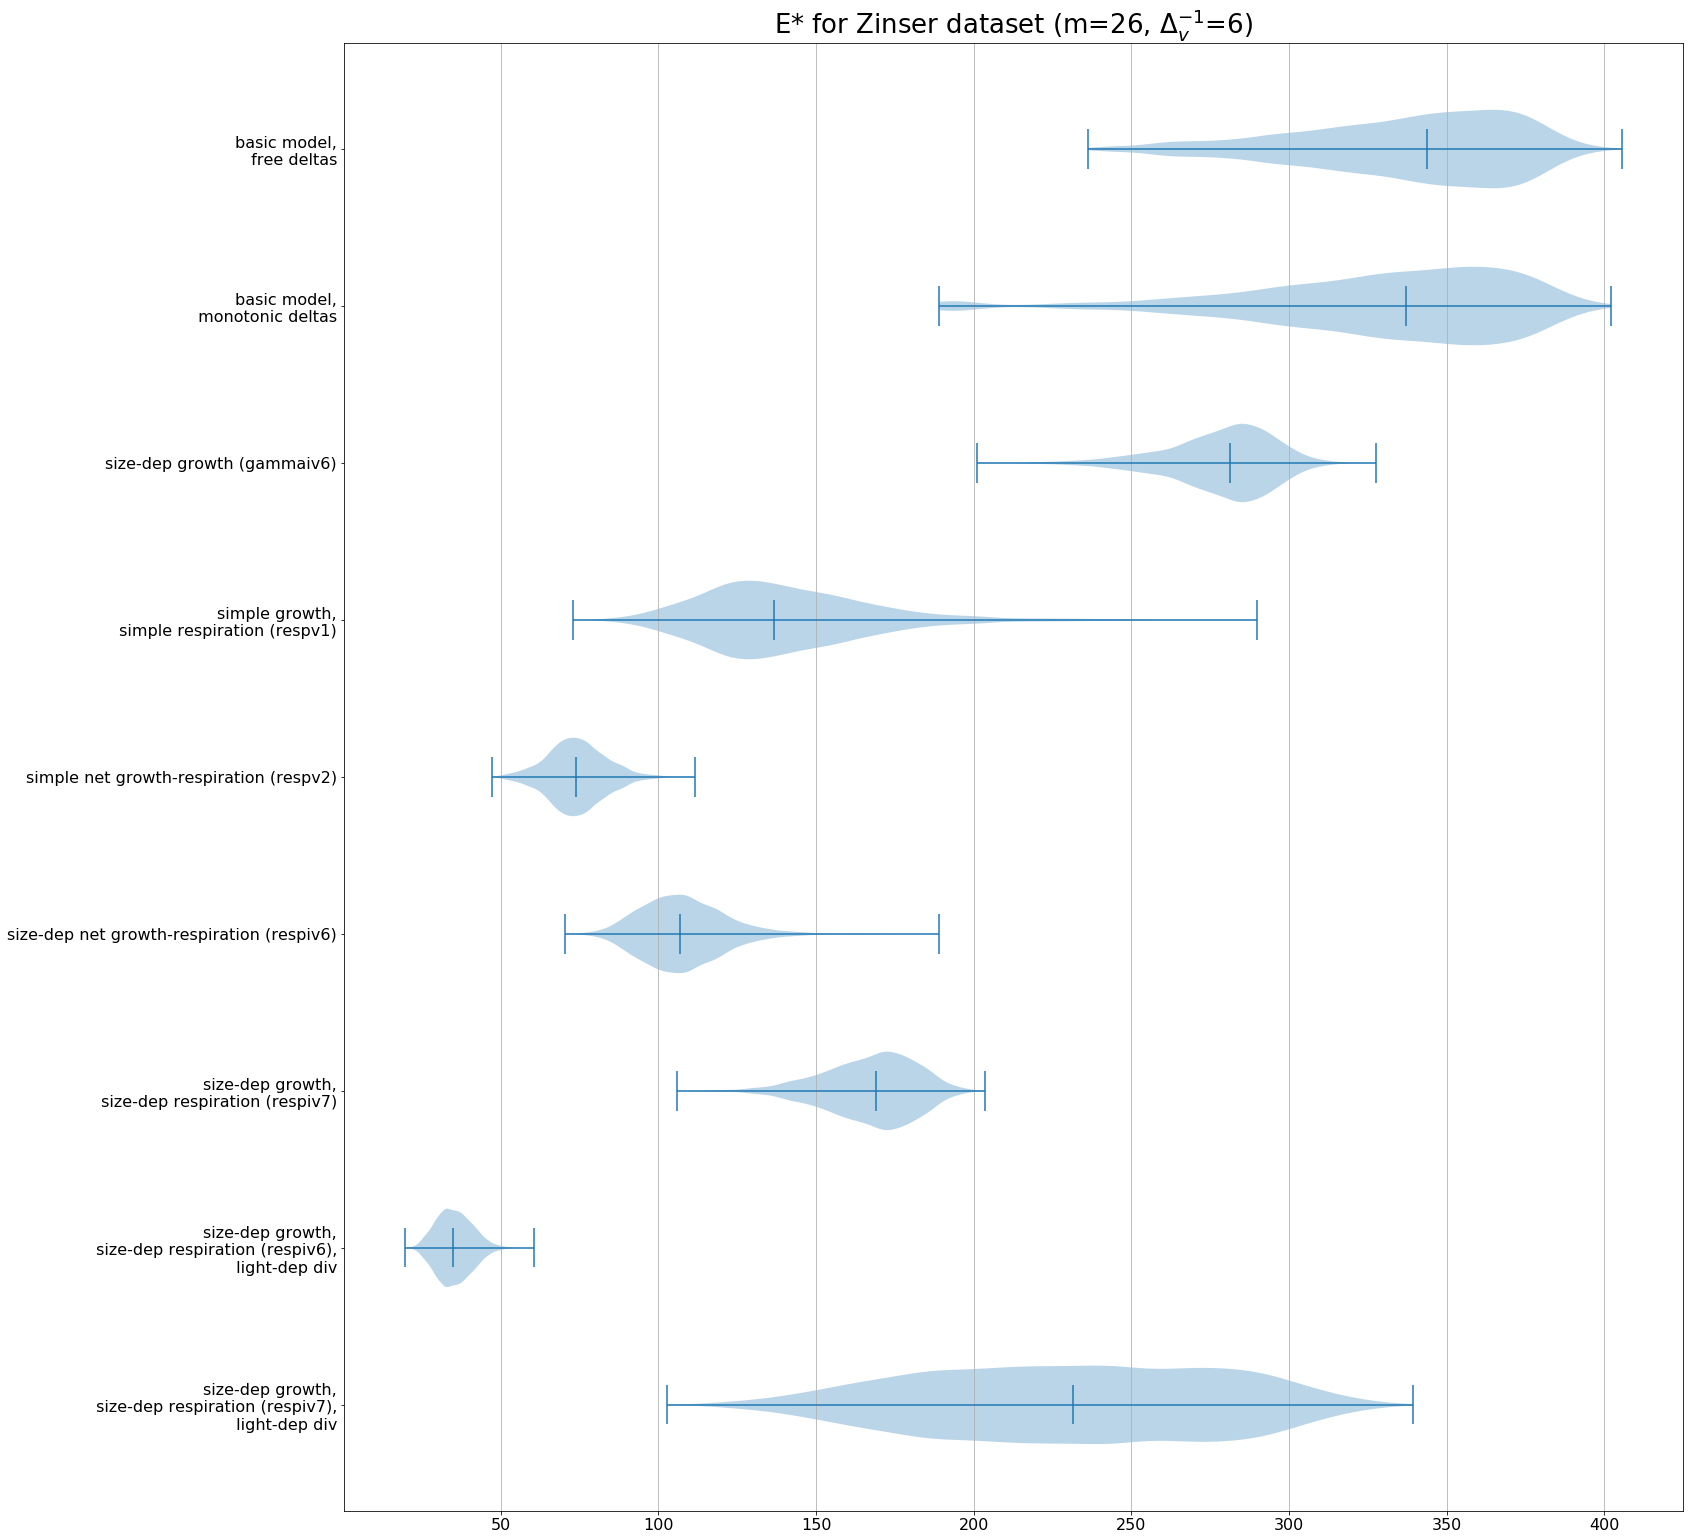

In [16]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.69}}

for param in ('divrate','E_star'):
    for dataname in data:
        num_mcmcs = len(mcmcs)
        fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
        ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
        ax.violinplot([mcmcs[name][dataname][param] for name in mcmcs], showmedians=True, vert=False)
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[name].replace(',',',\n') for name in mcmcs])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        for i,name in enumerate(mcmcs):
            if maxrhats_final[name][dataname] > 1.1:
                ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

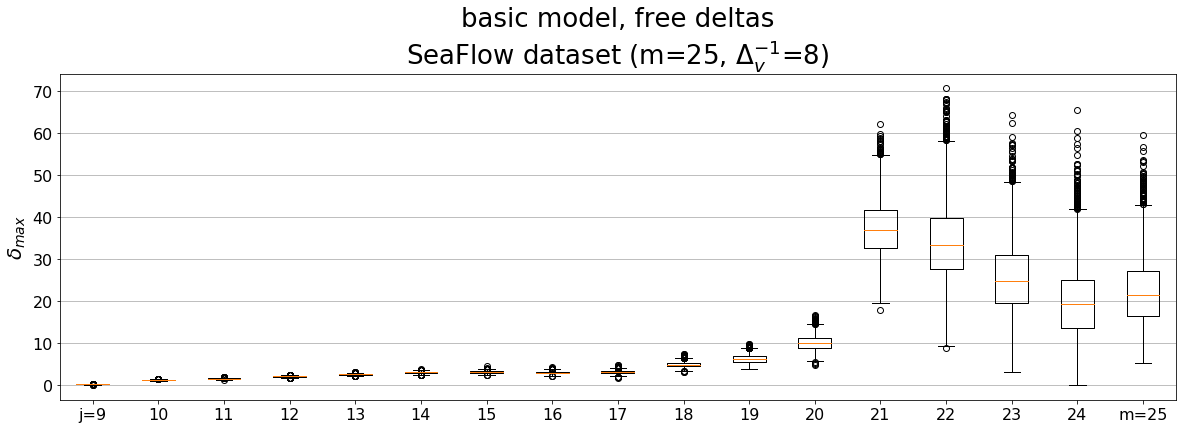

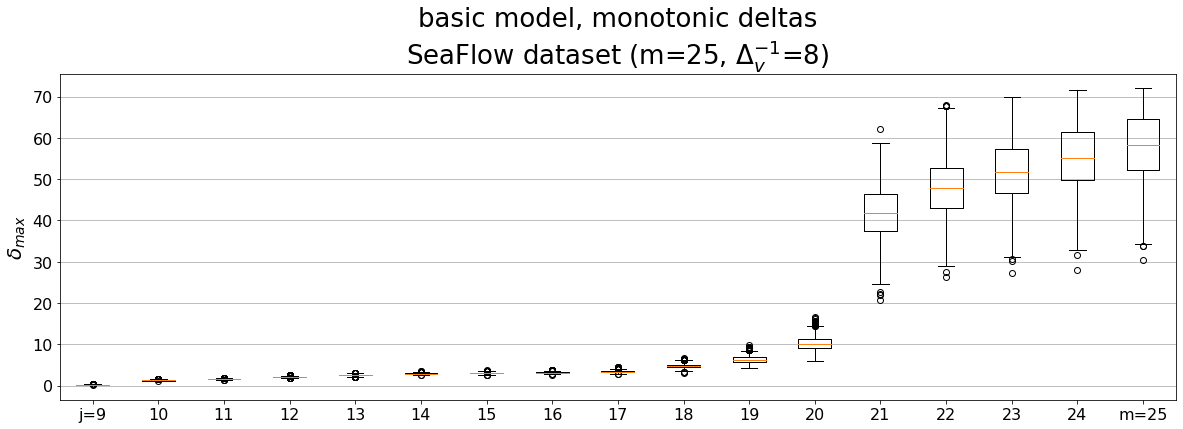

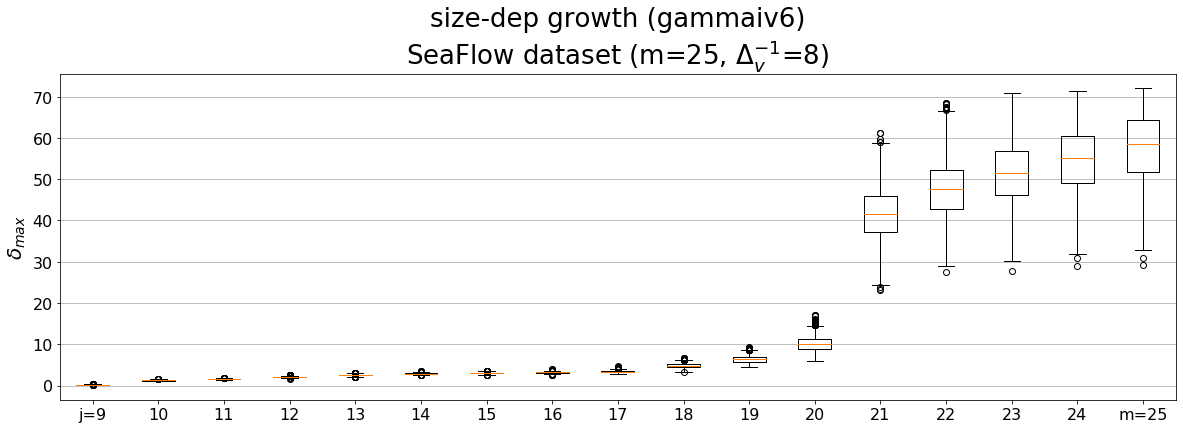

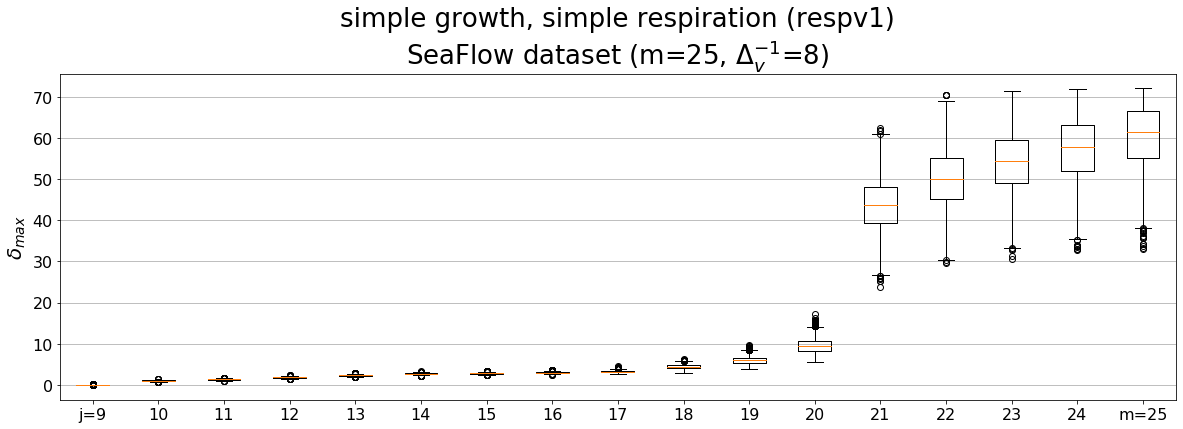

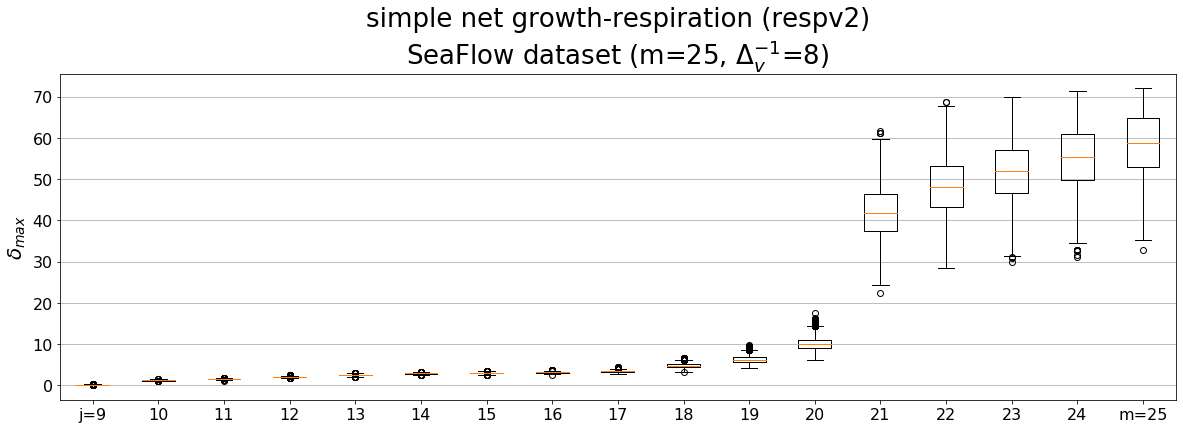

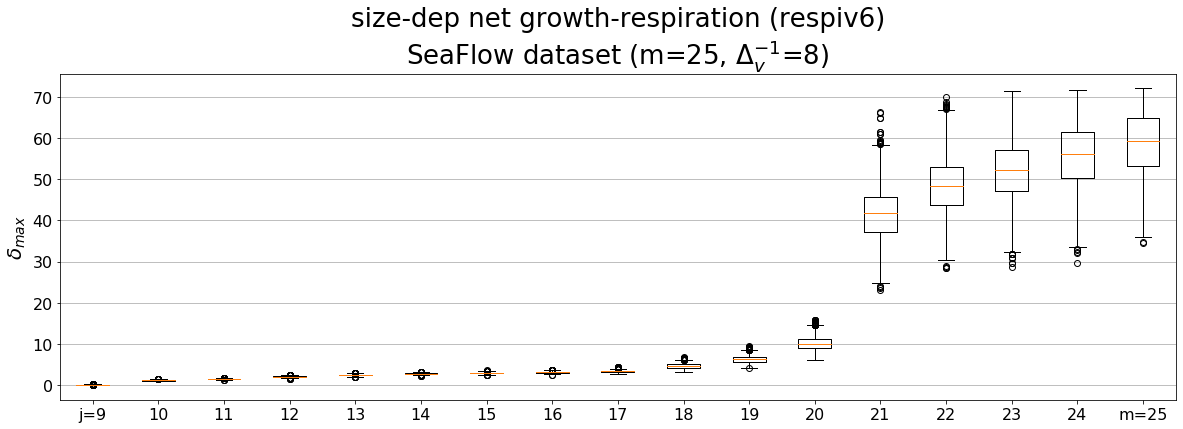

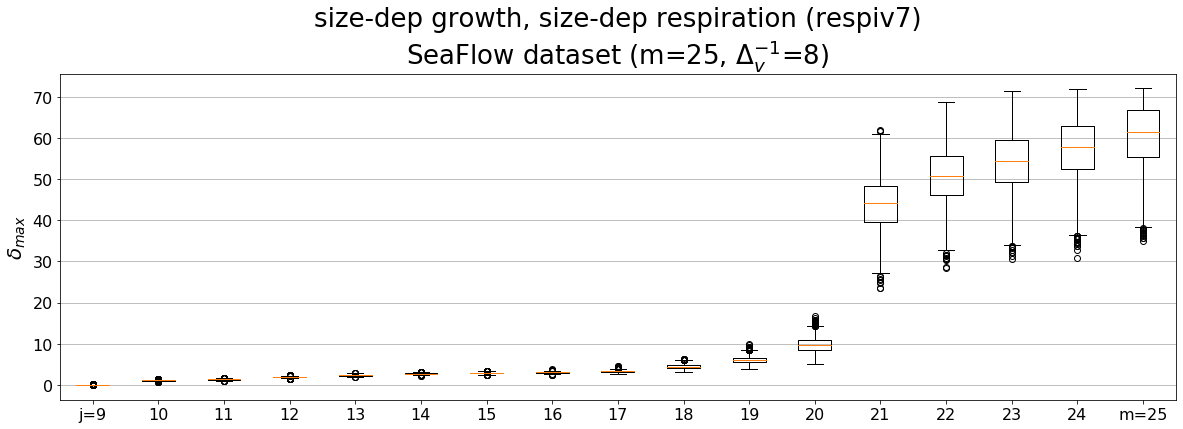

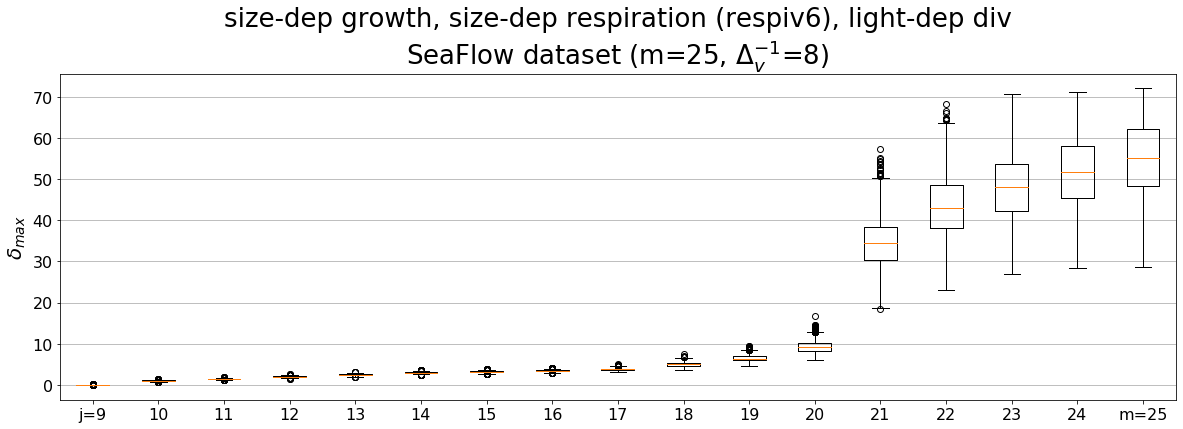

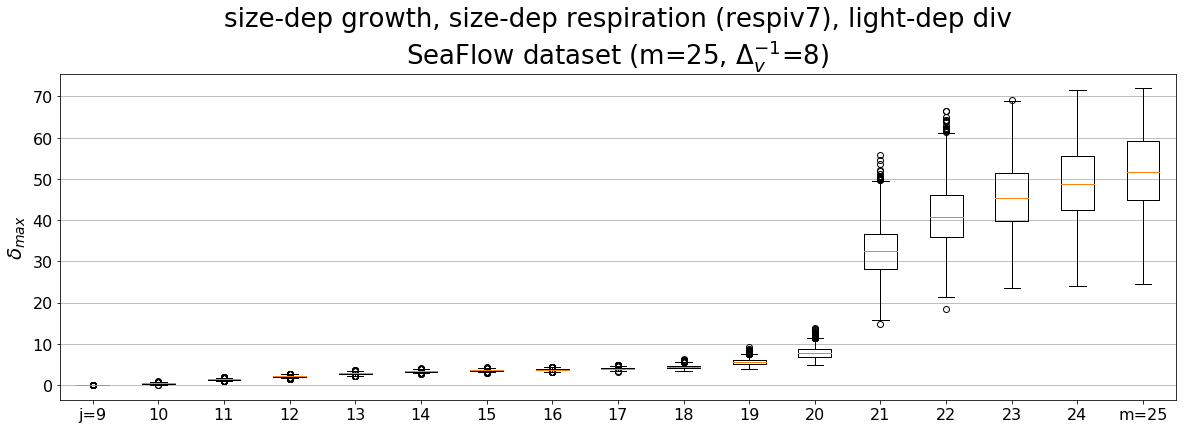

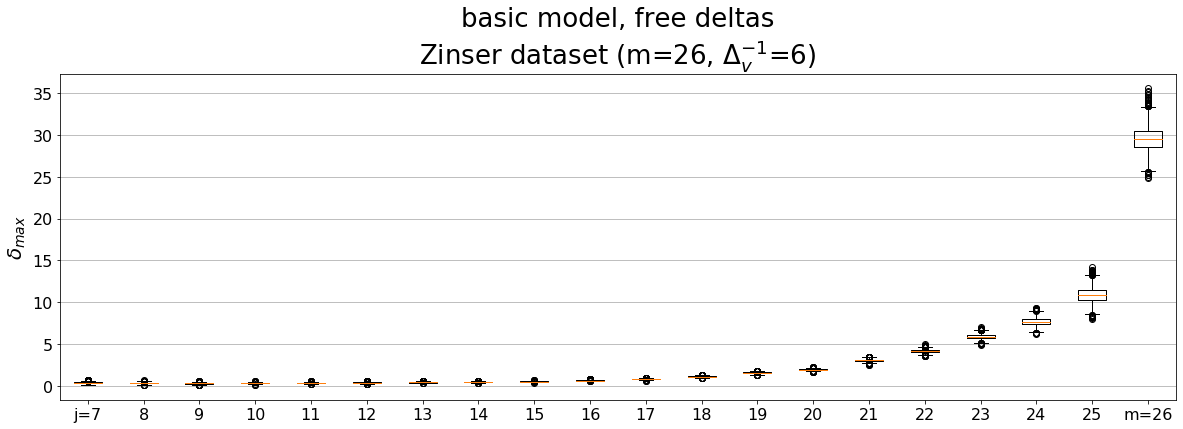

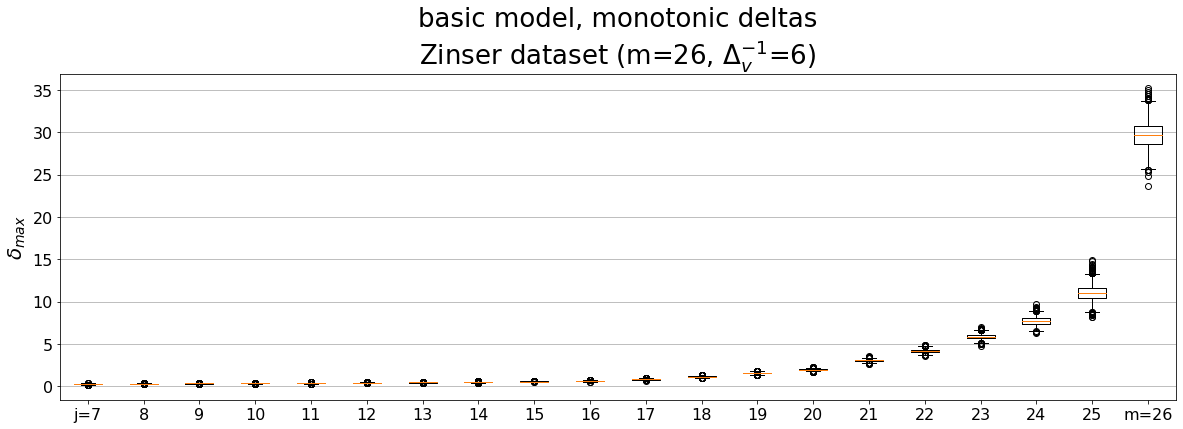

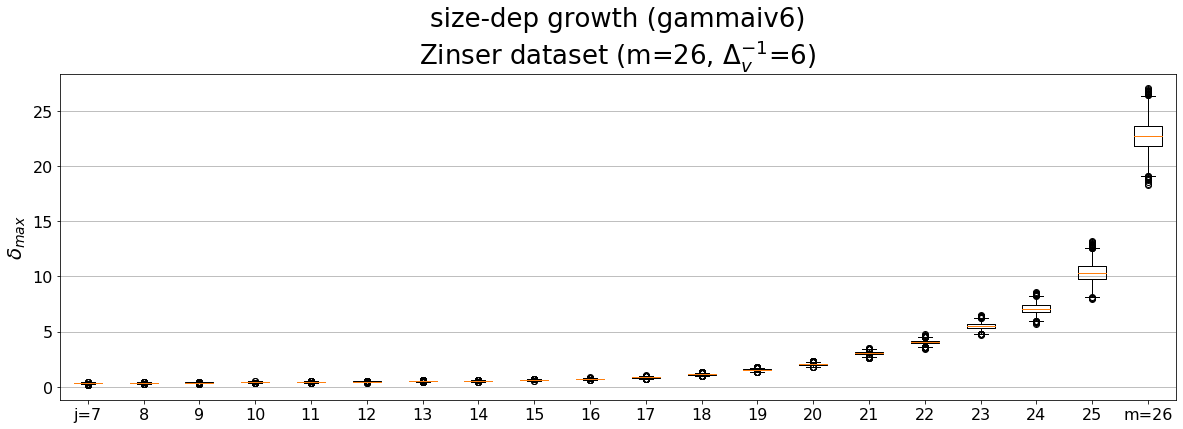

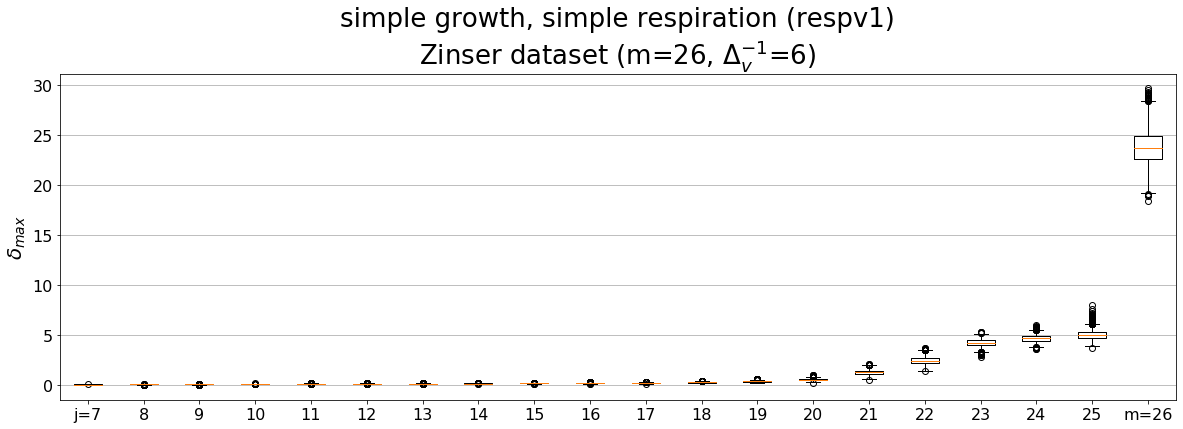

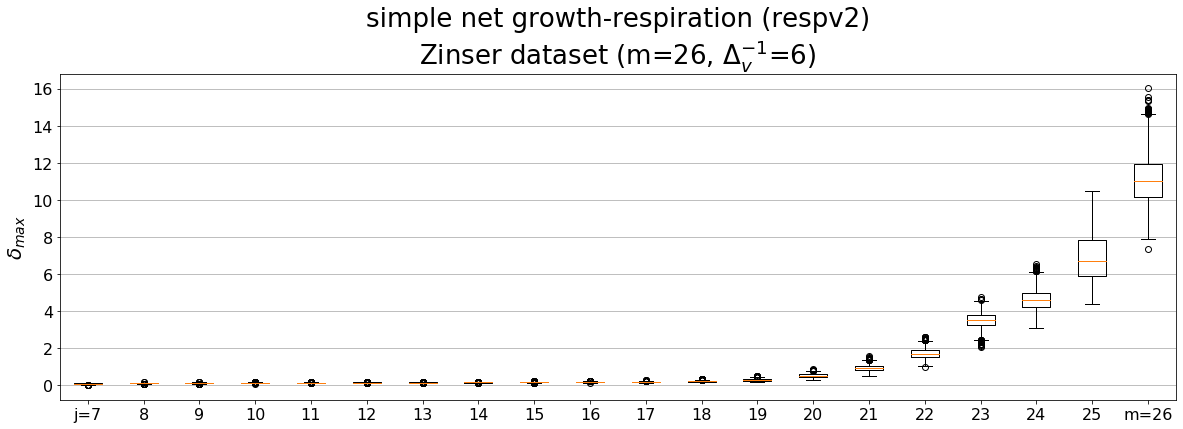

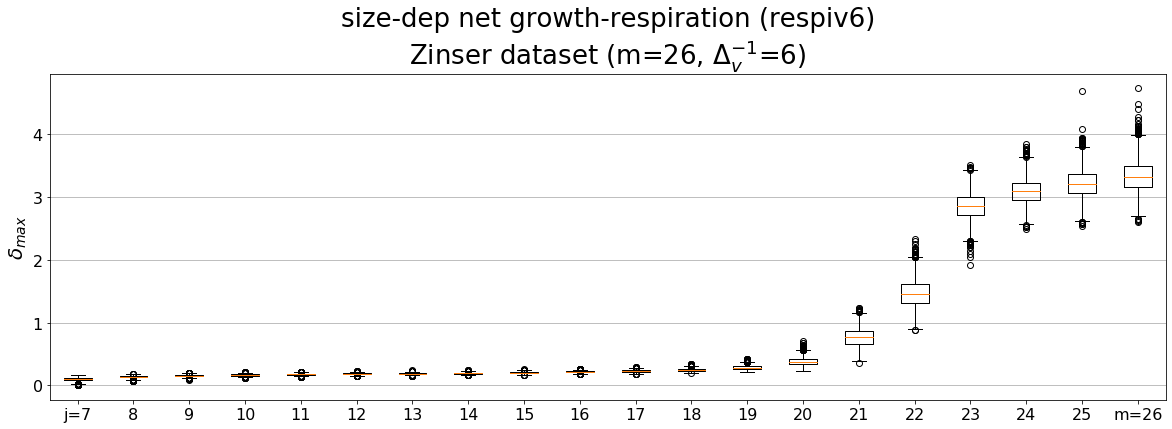

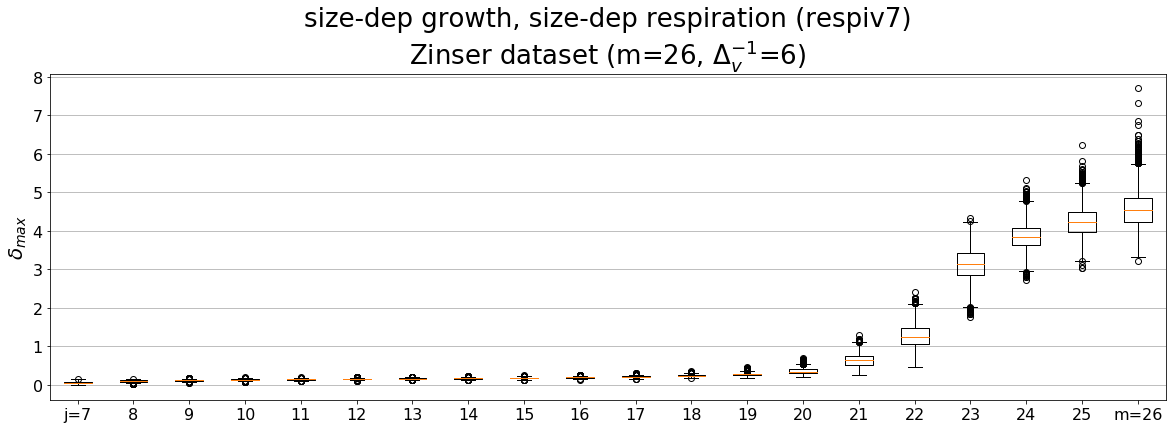

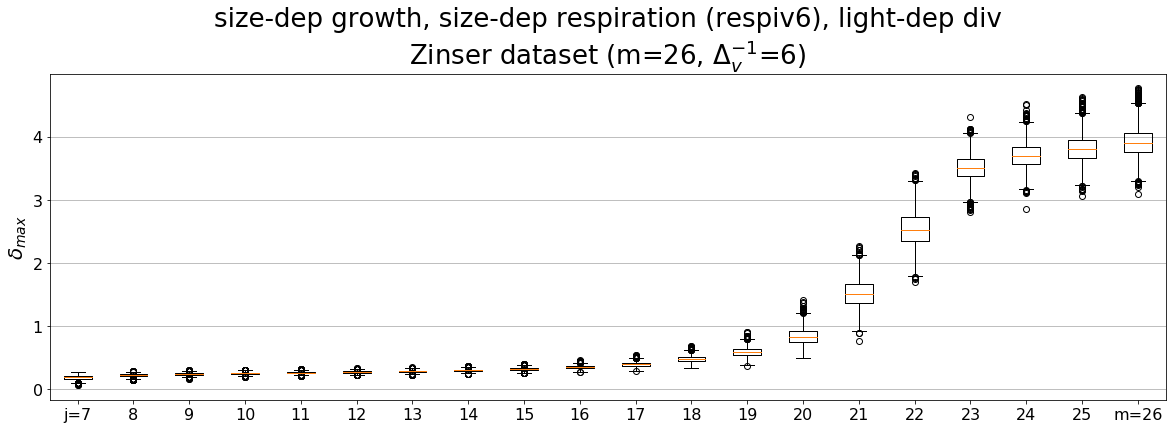

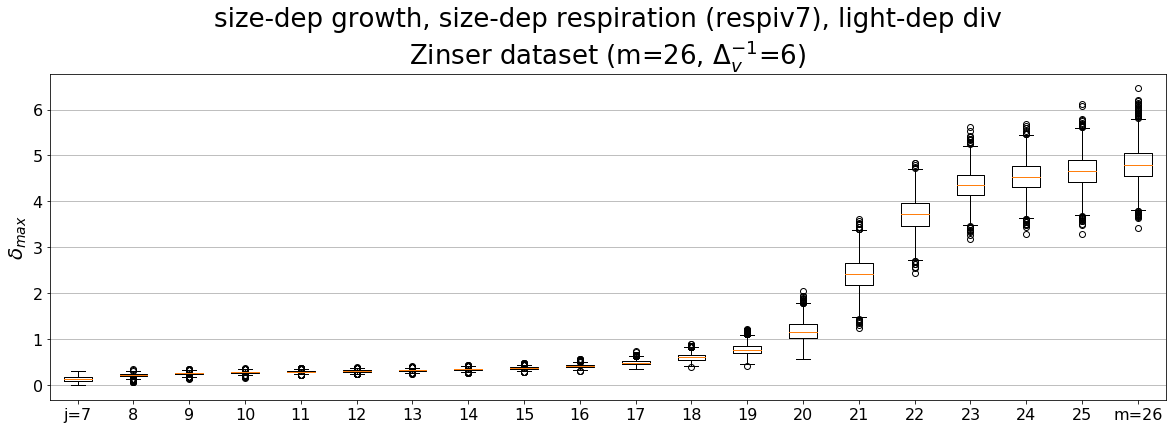

In [11]:
for dataname in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[name] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta_max'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

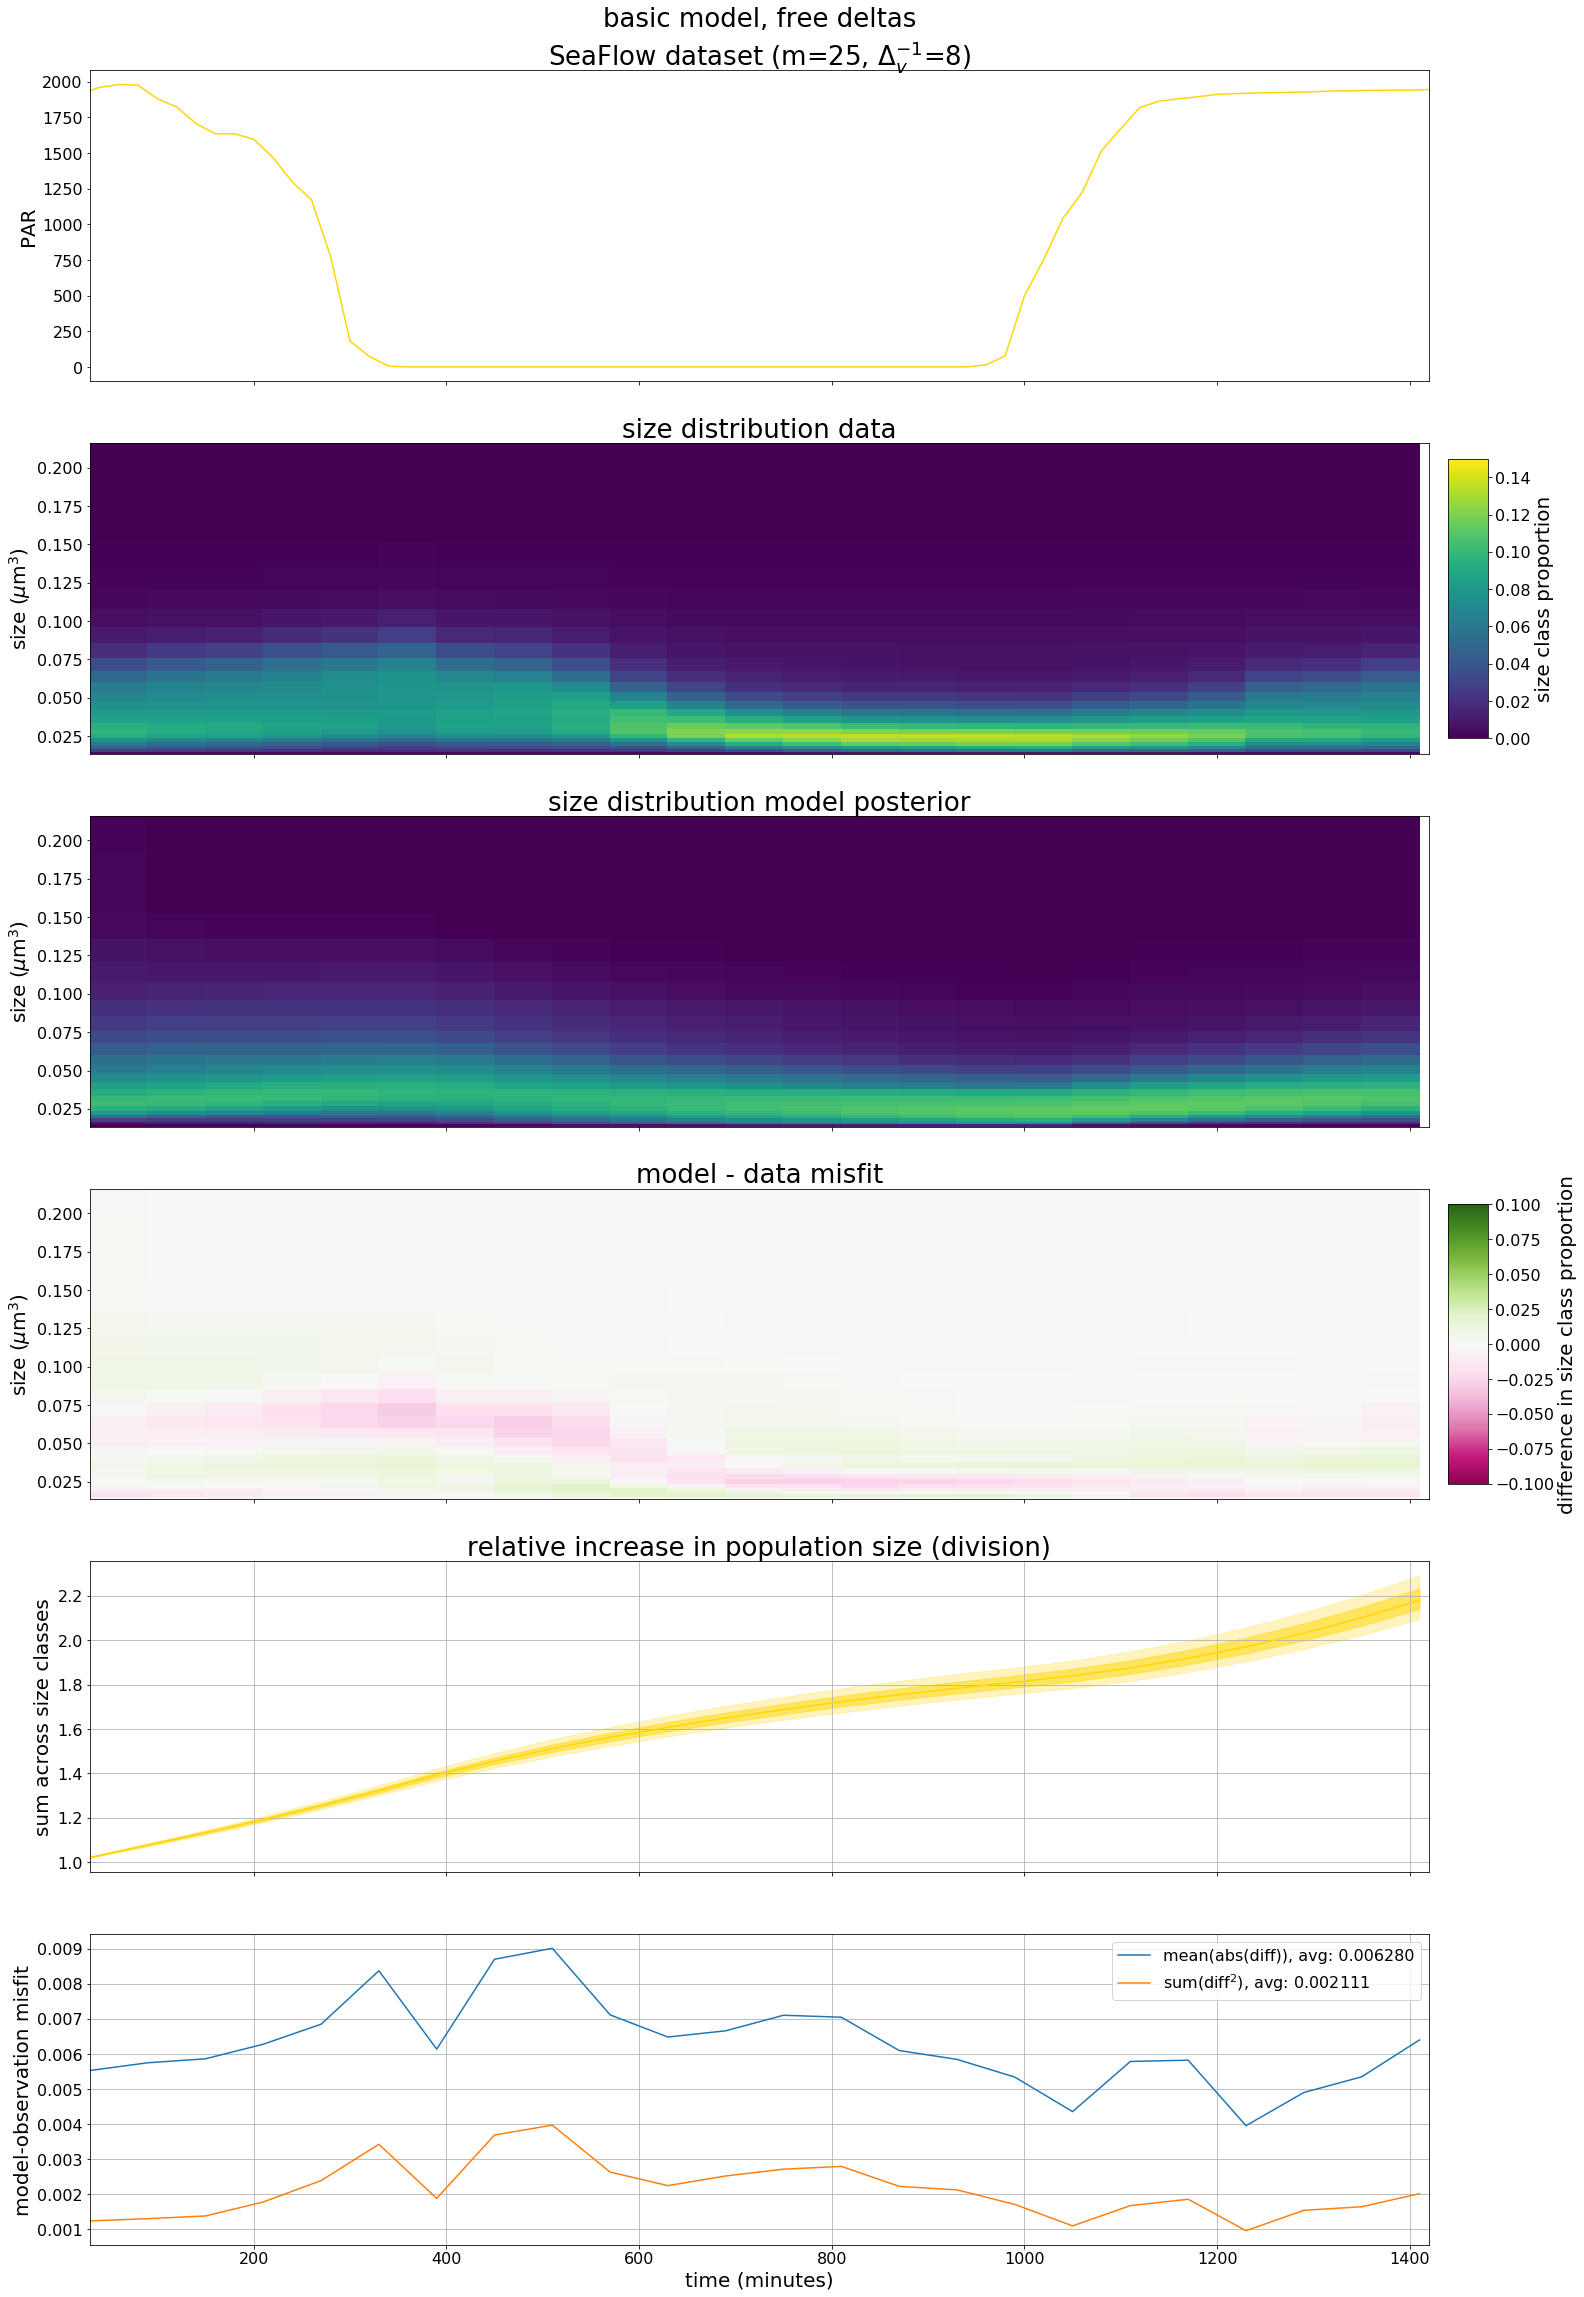

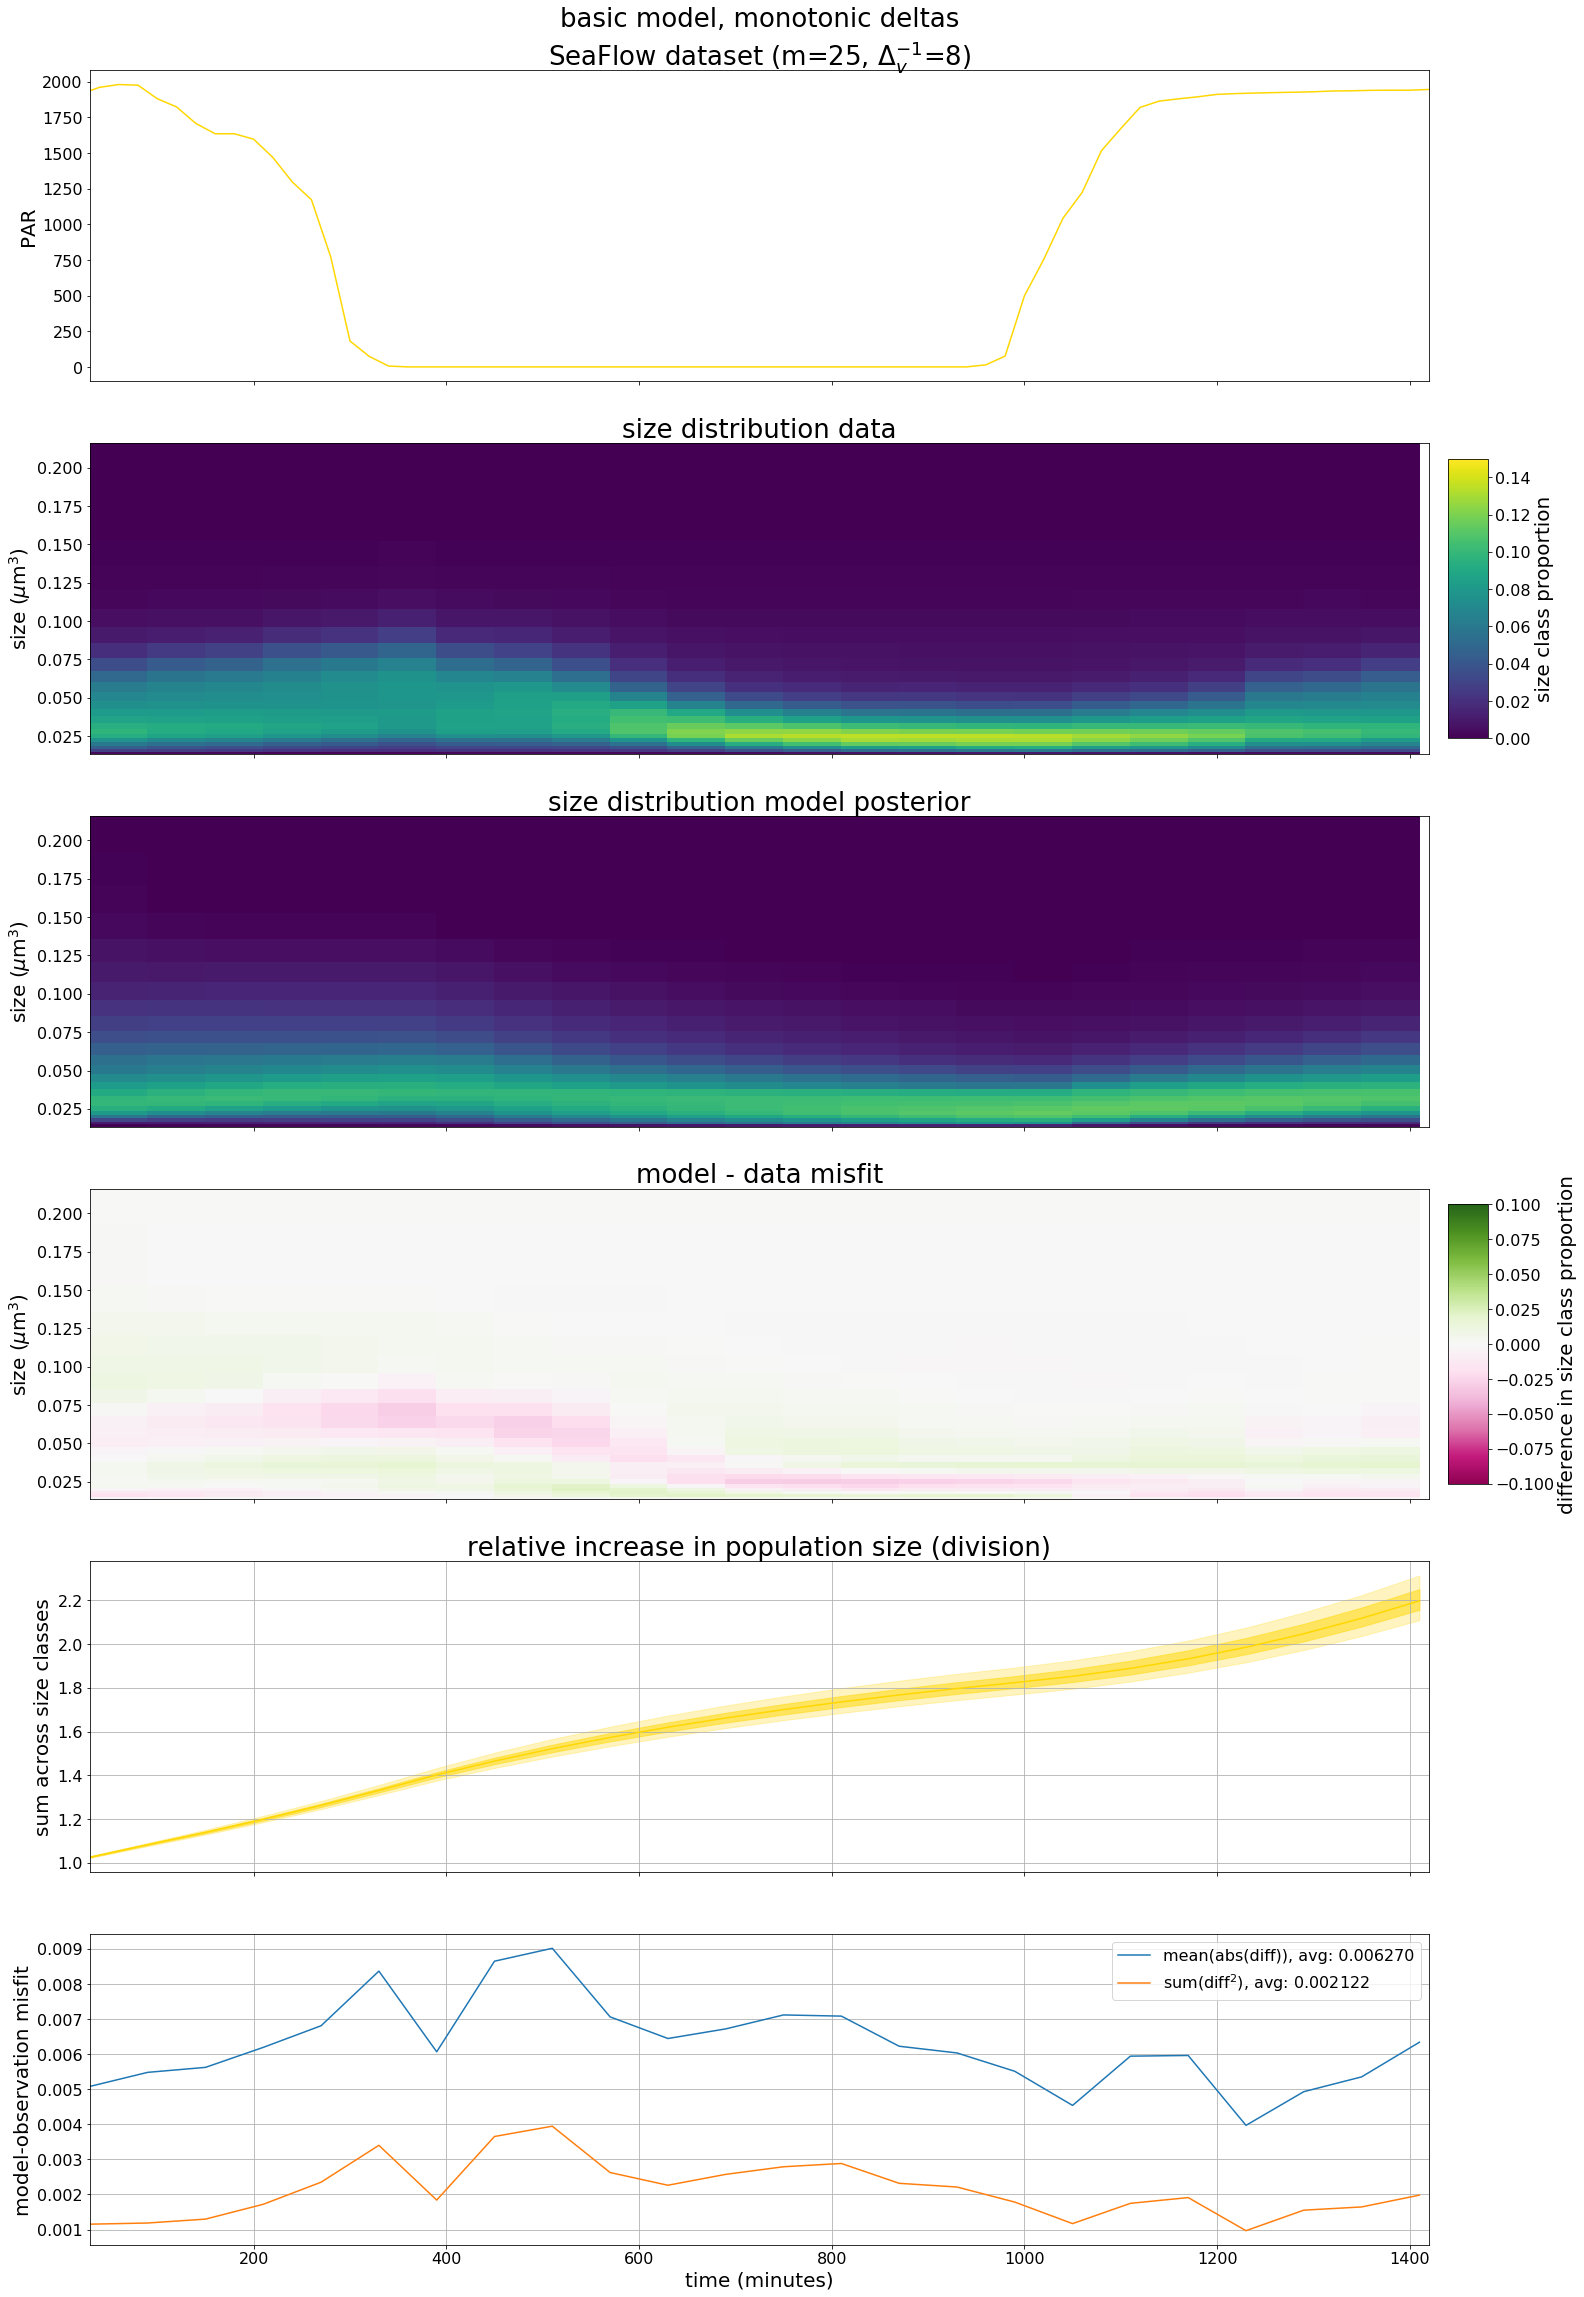

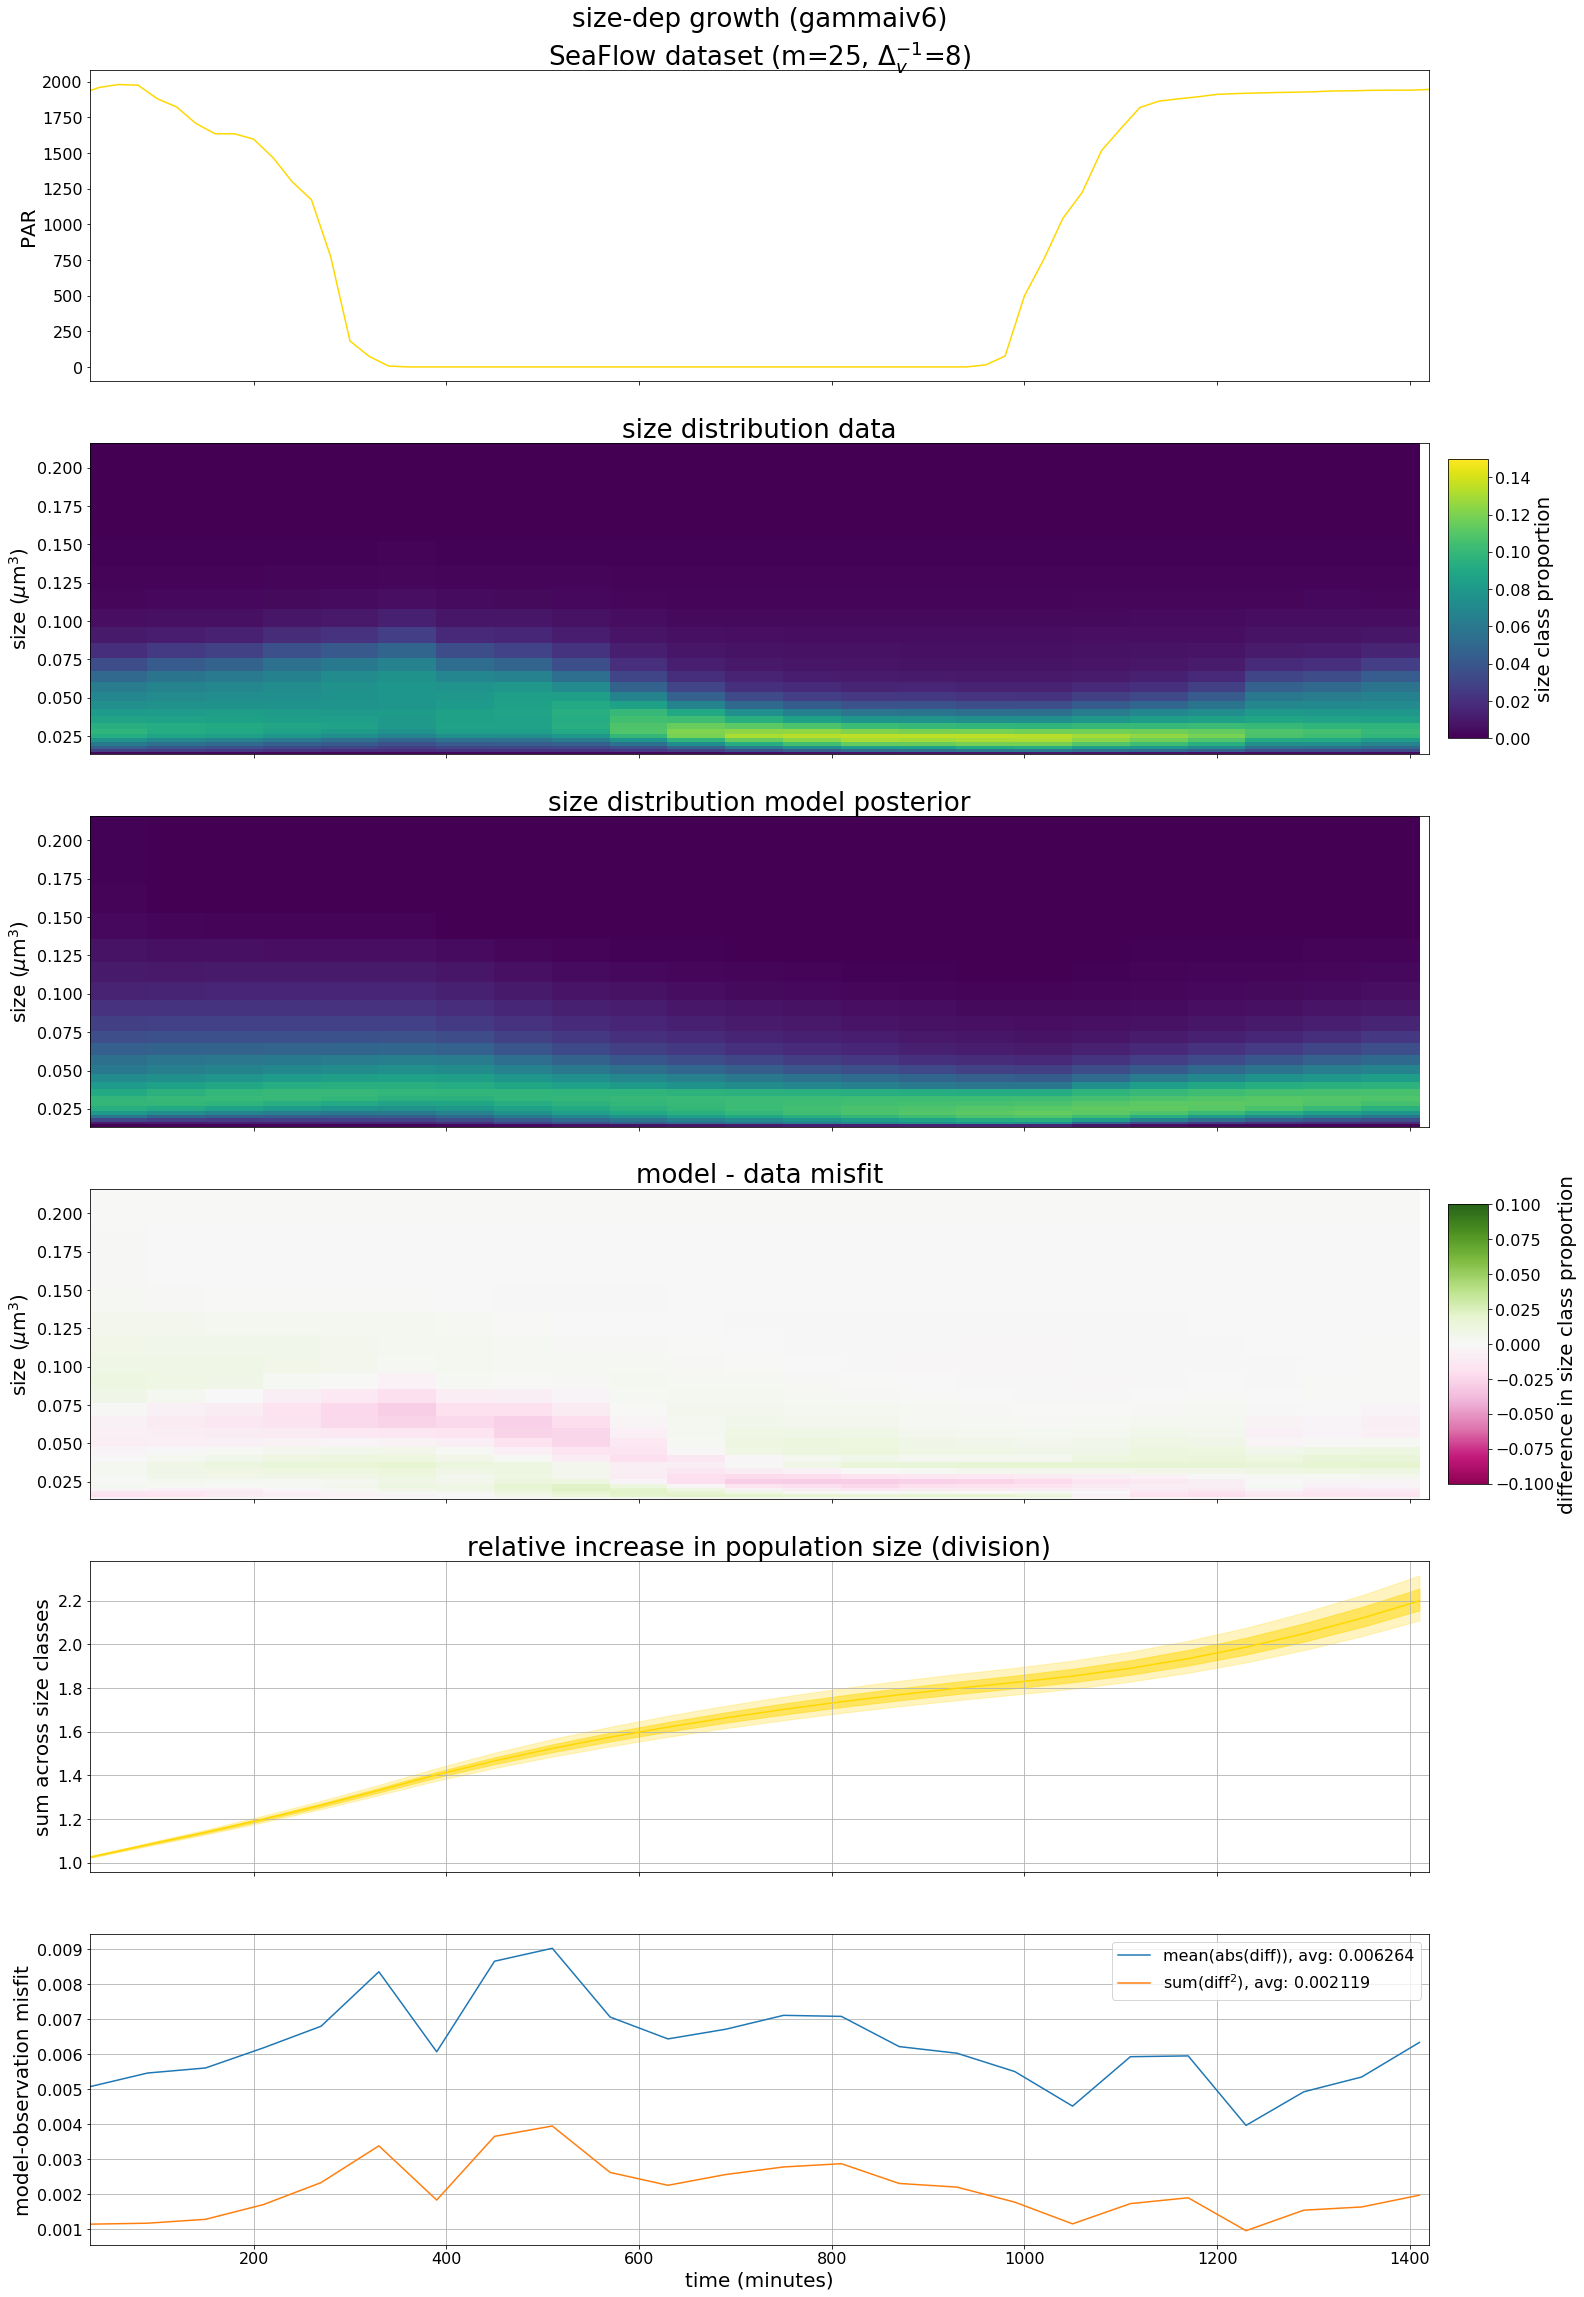

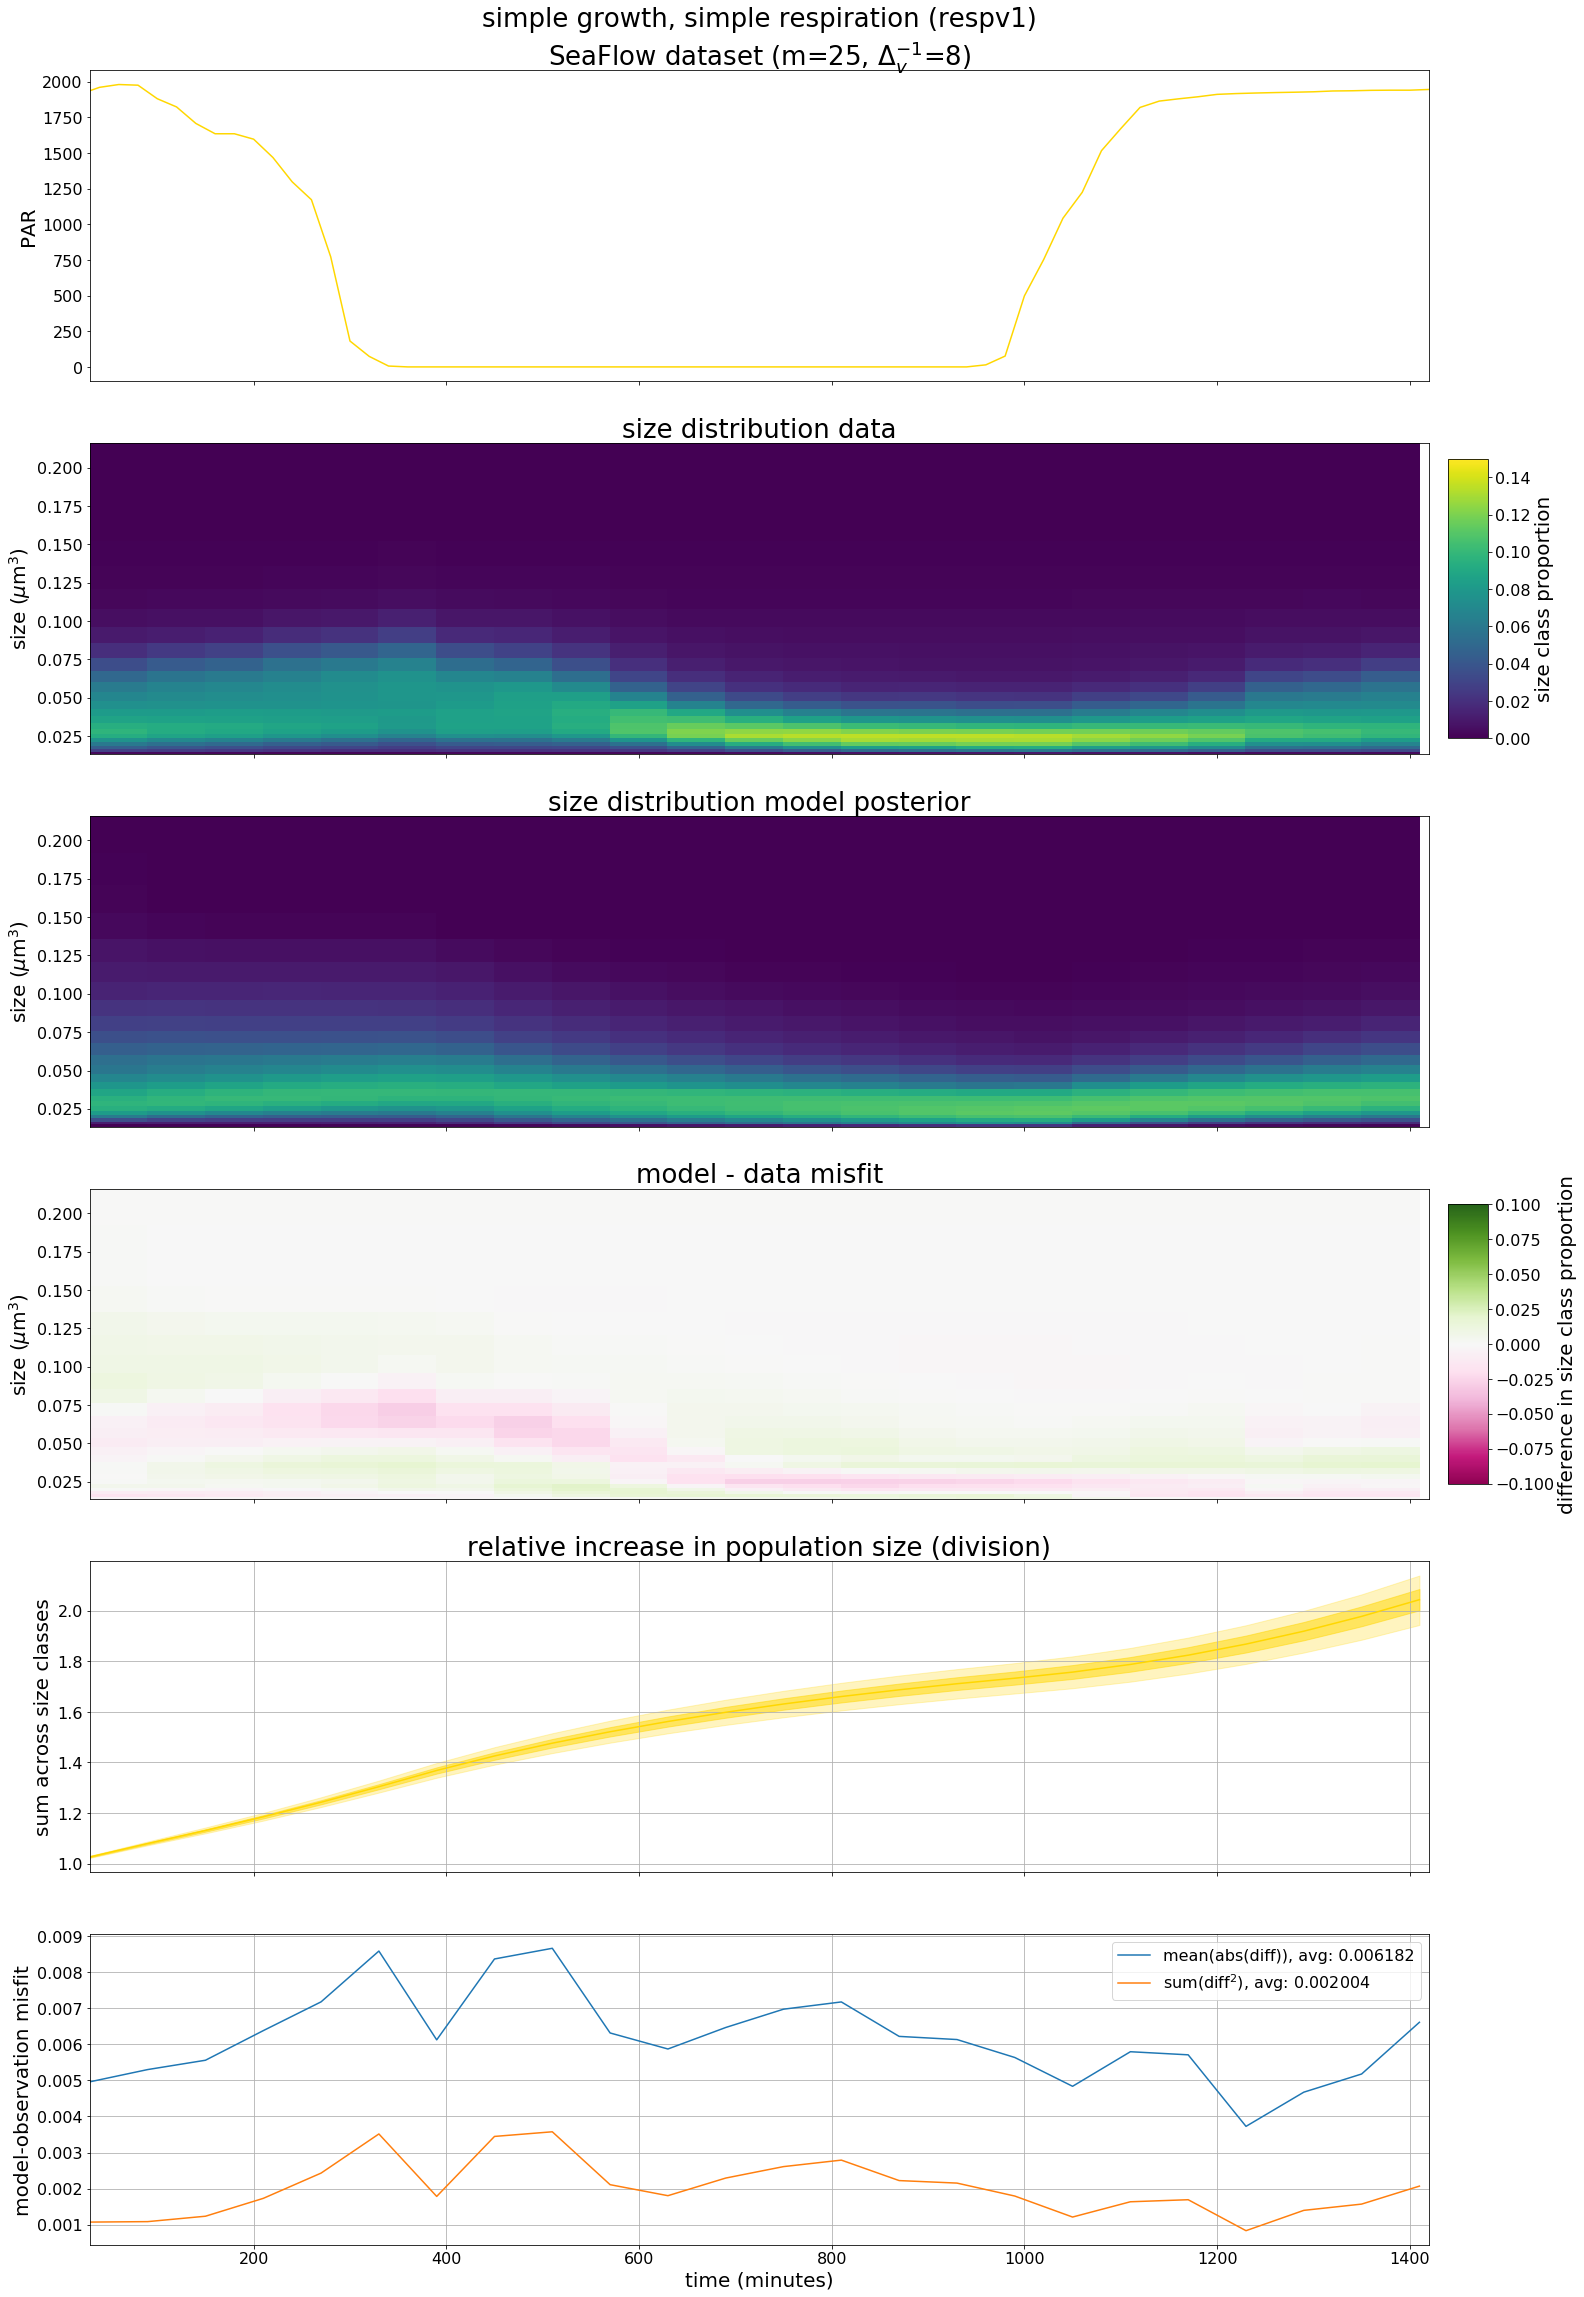

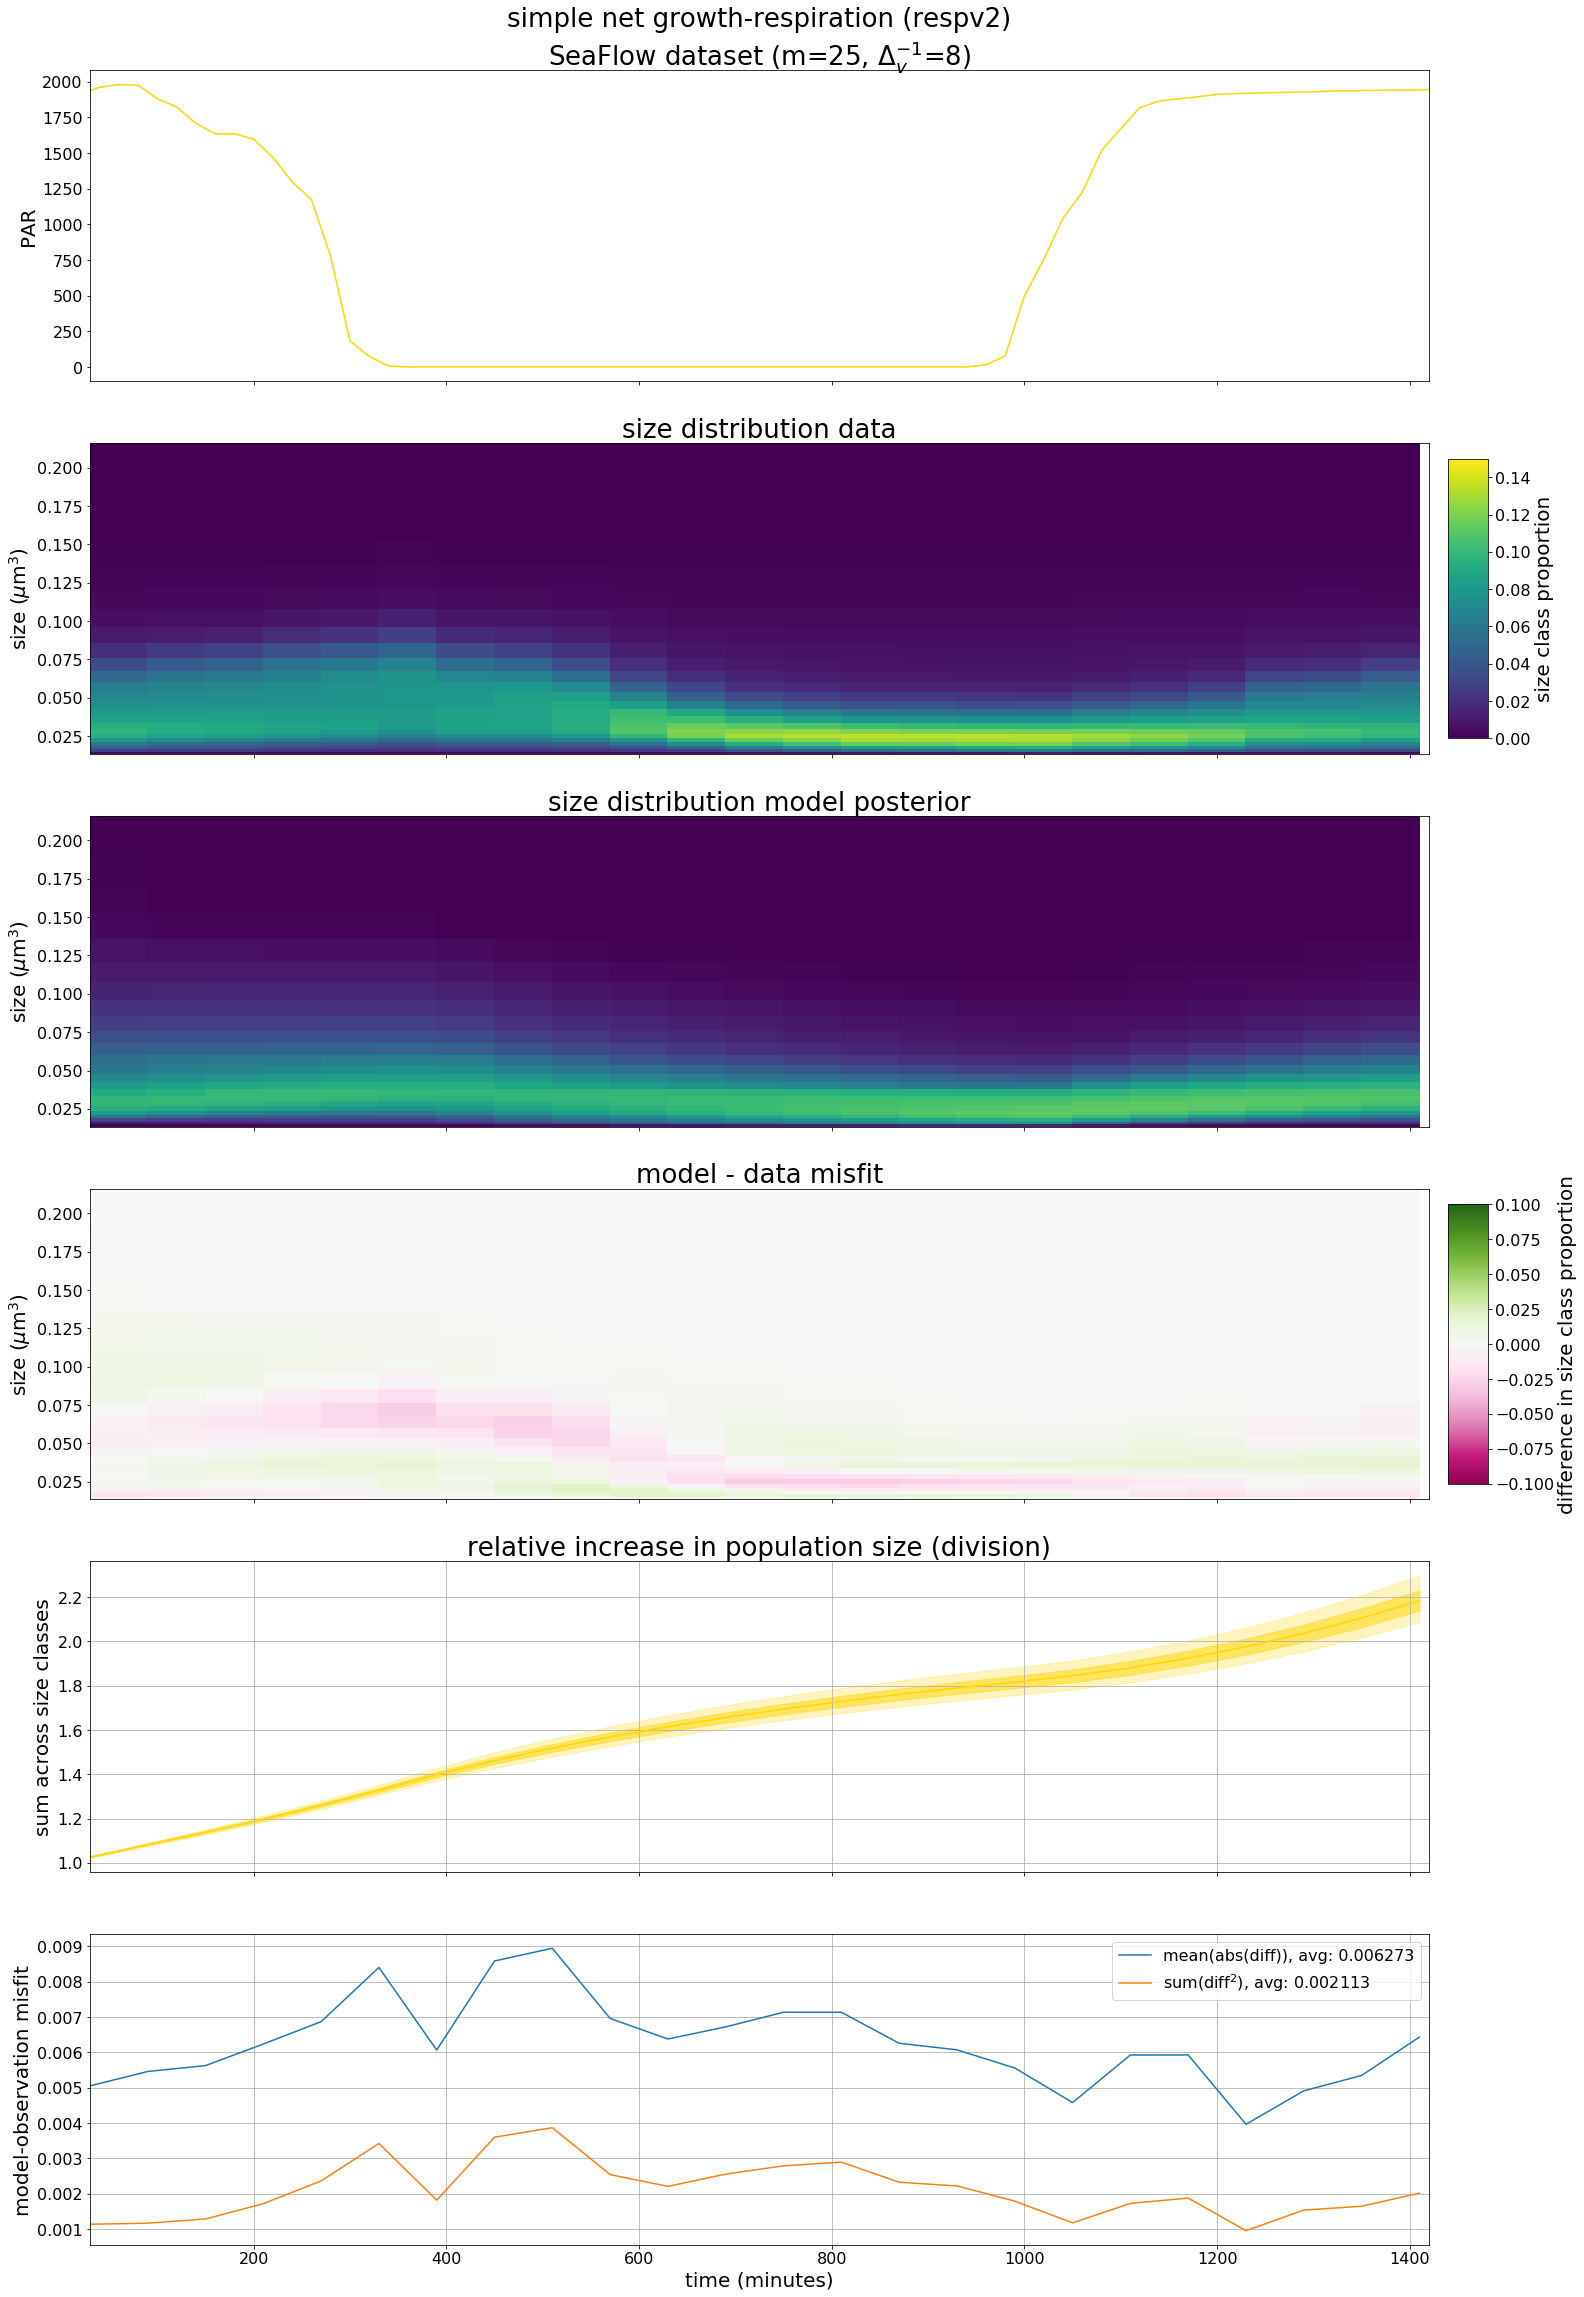

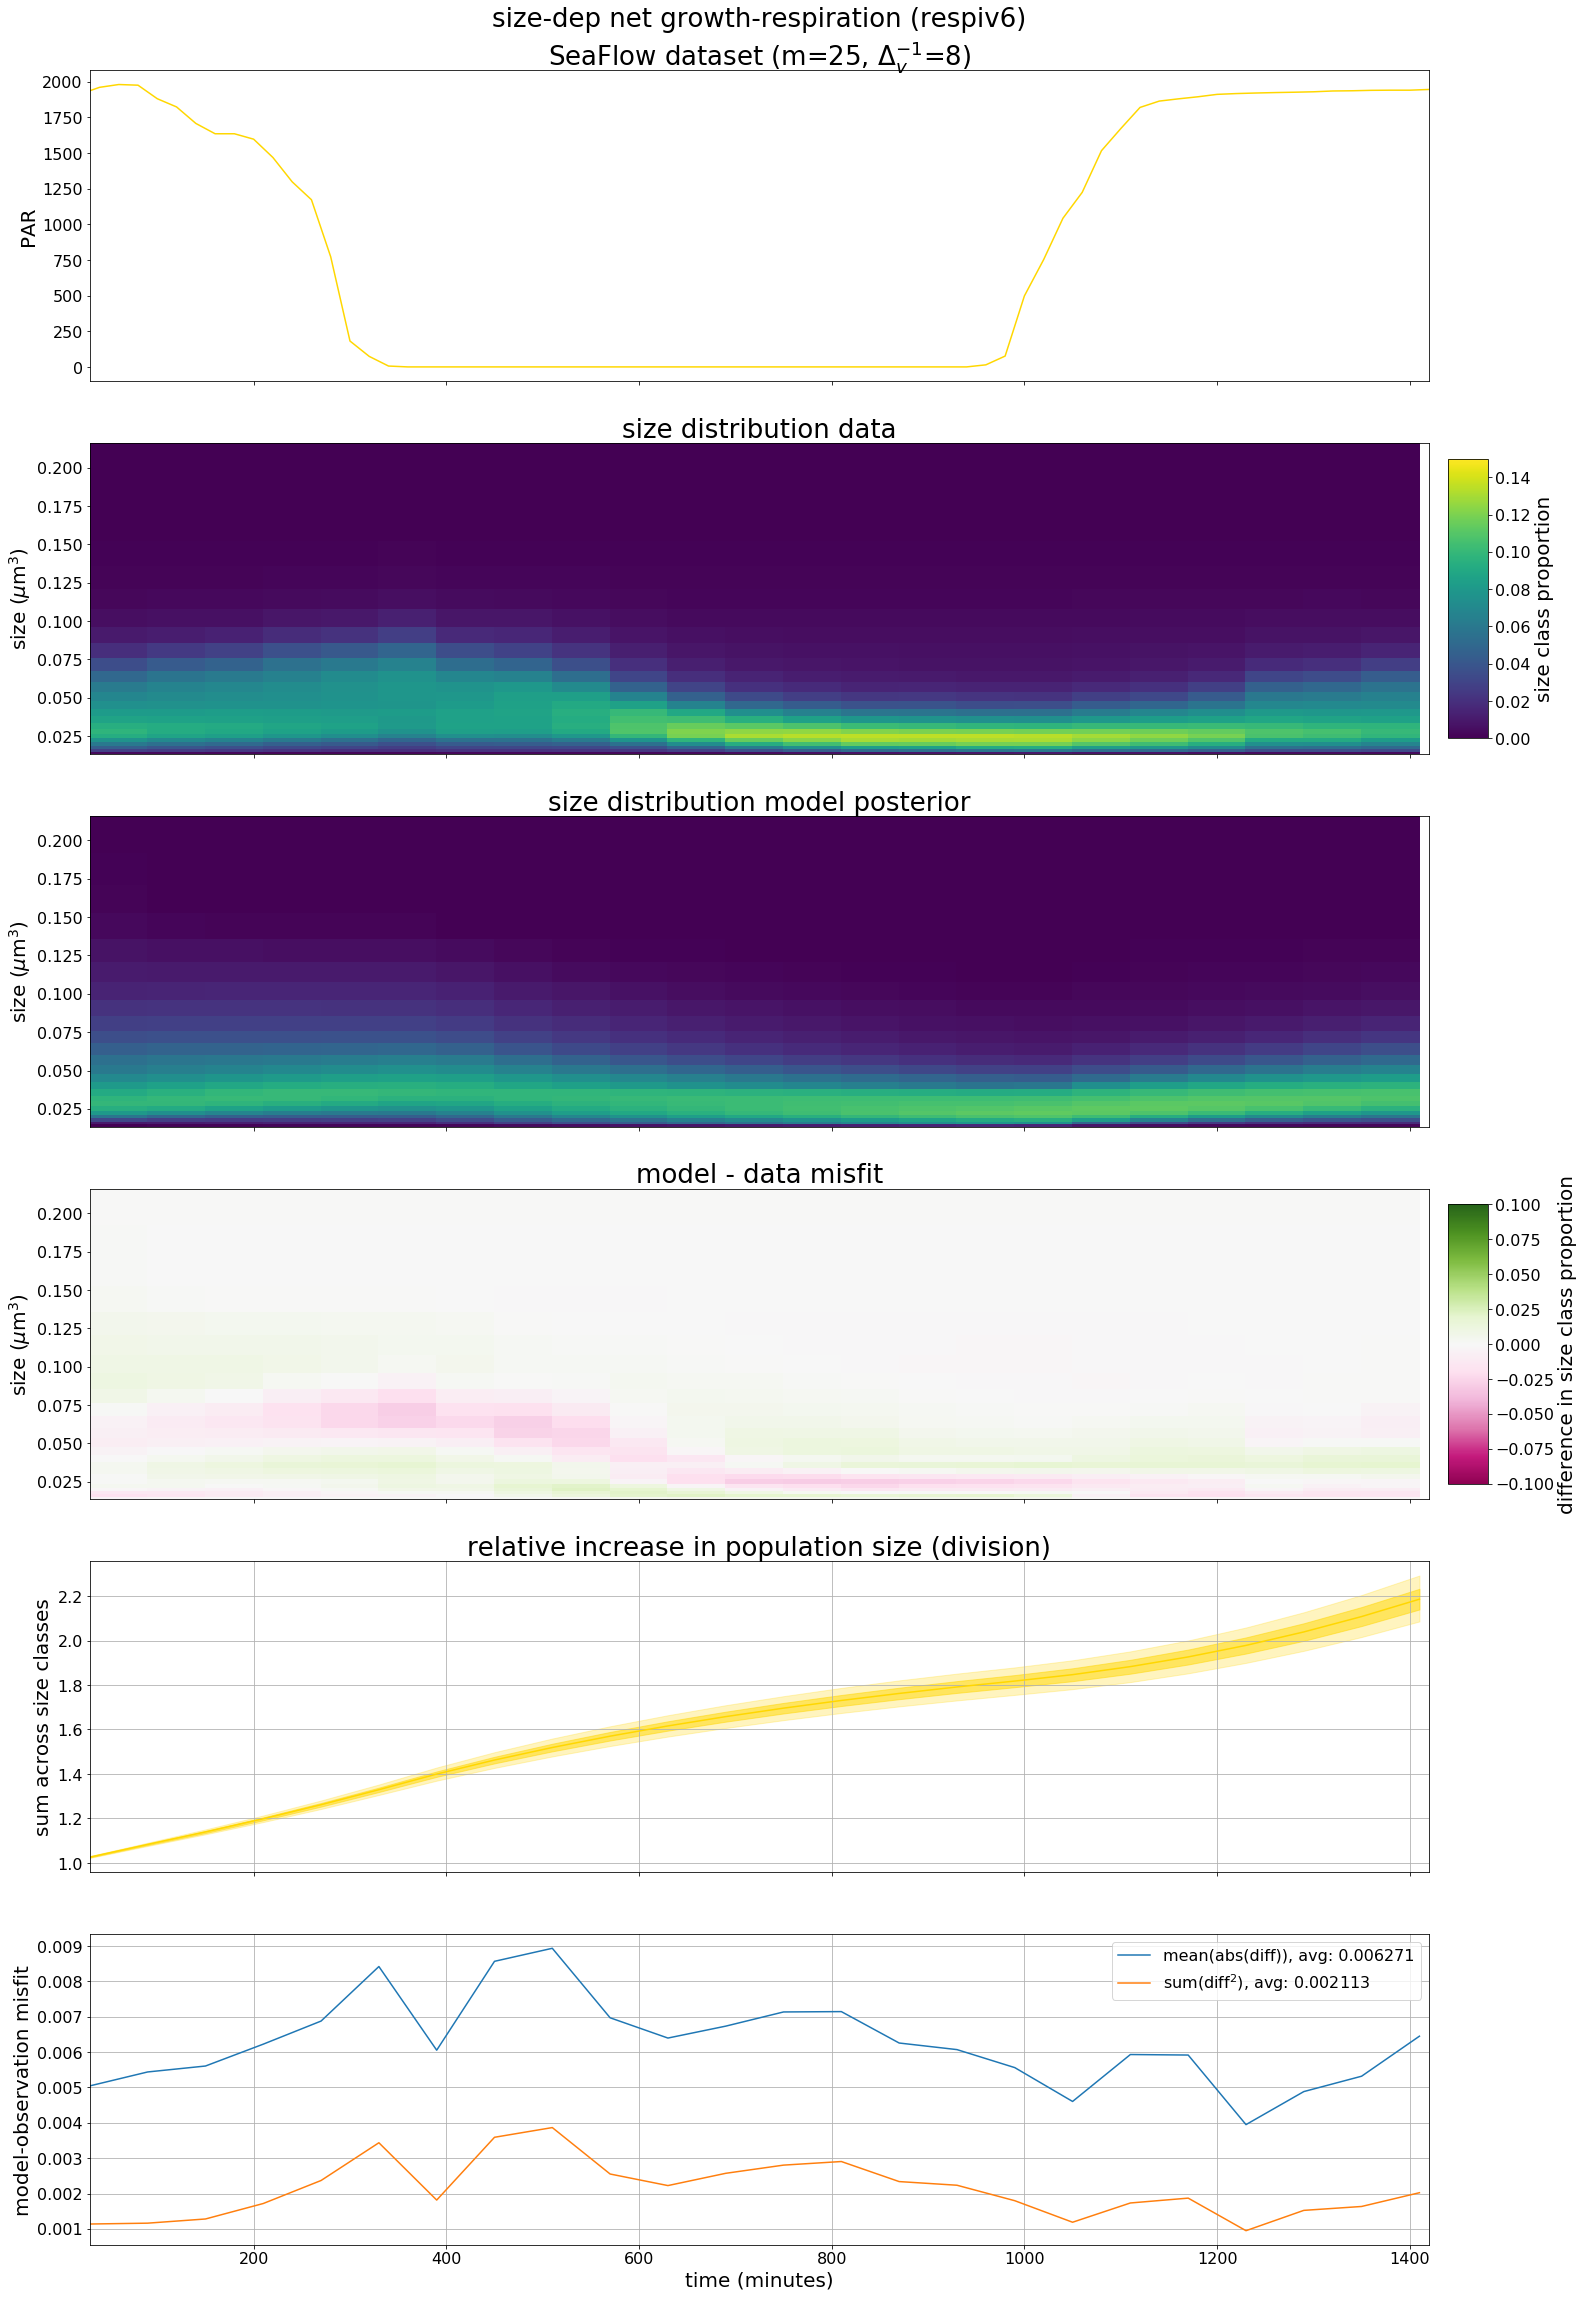

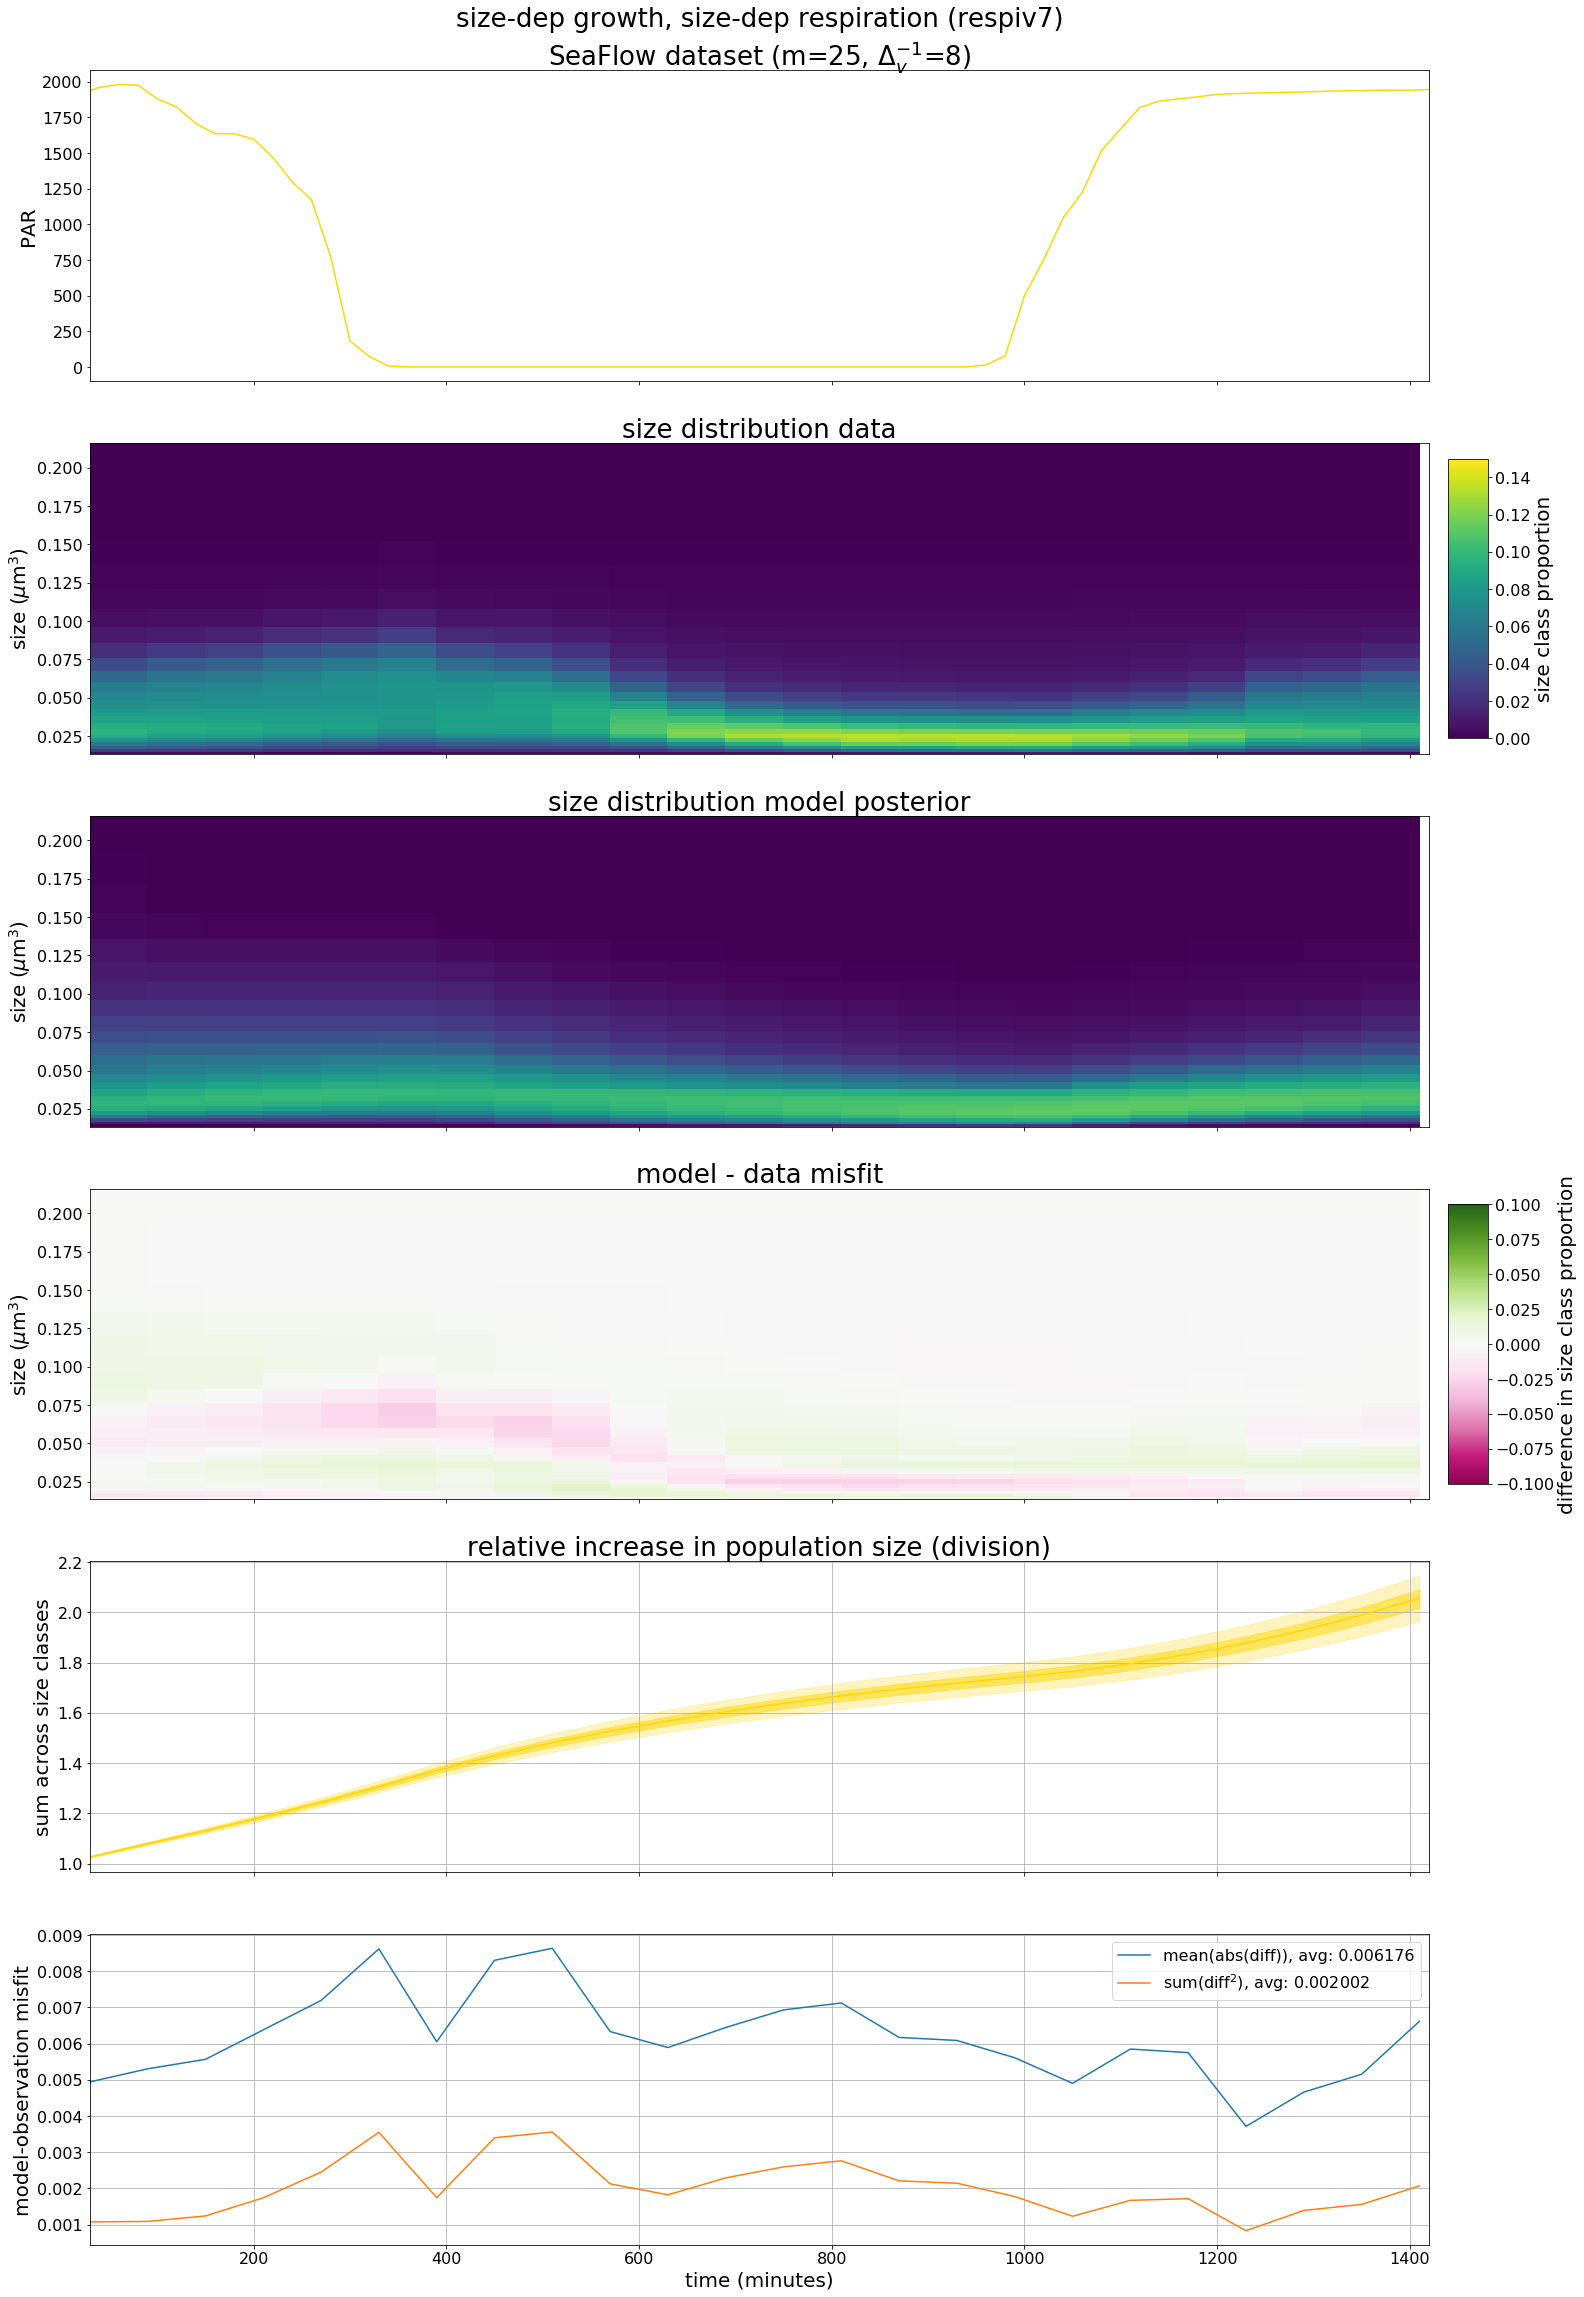

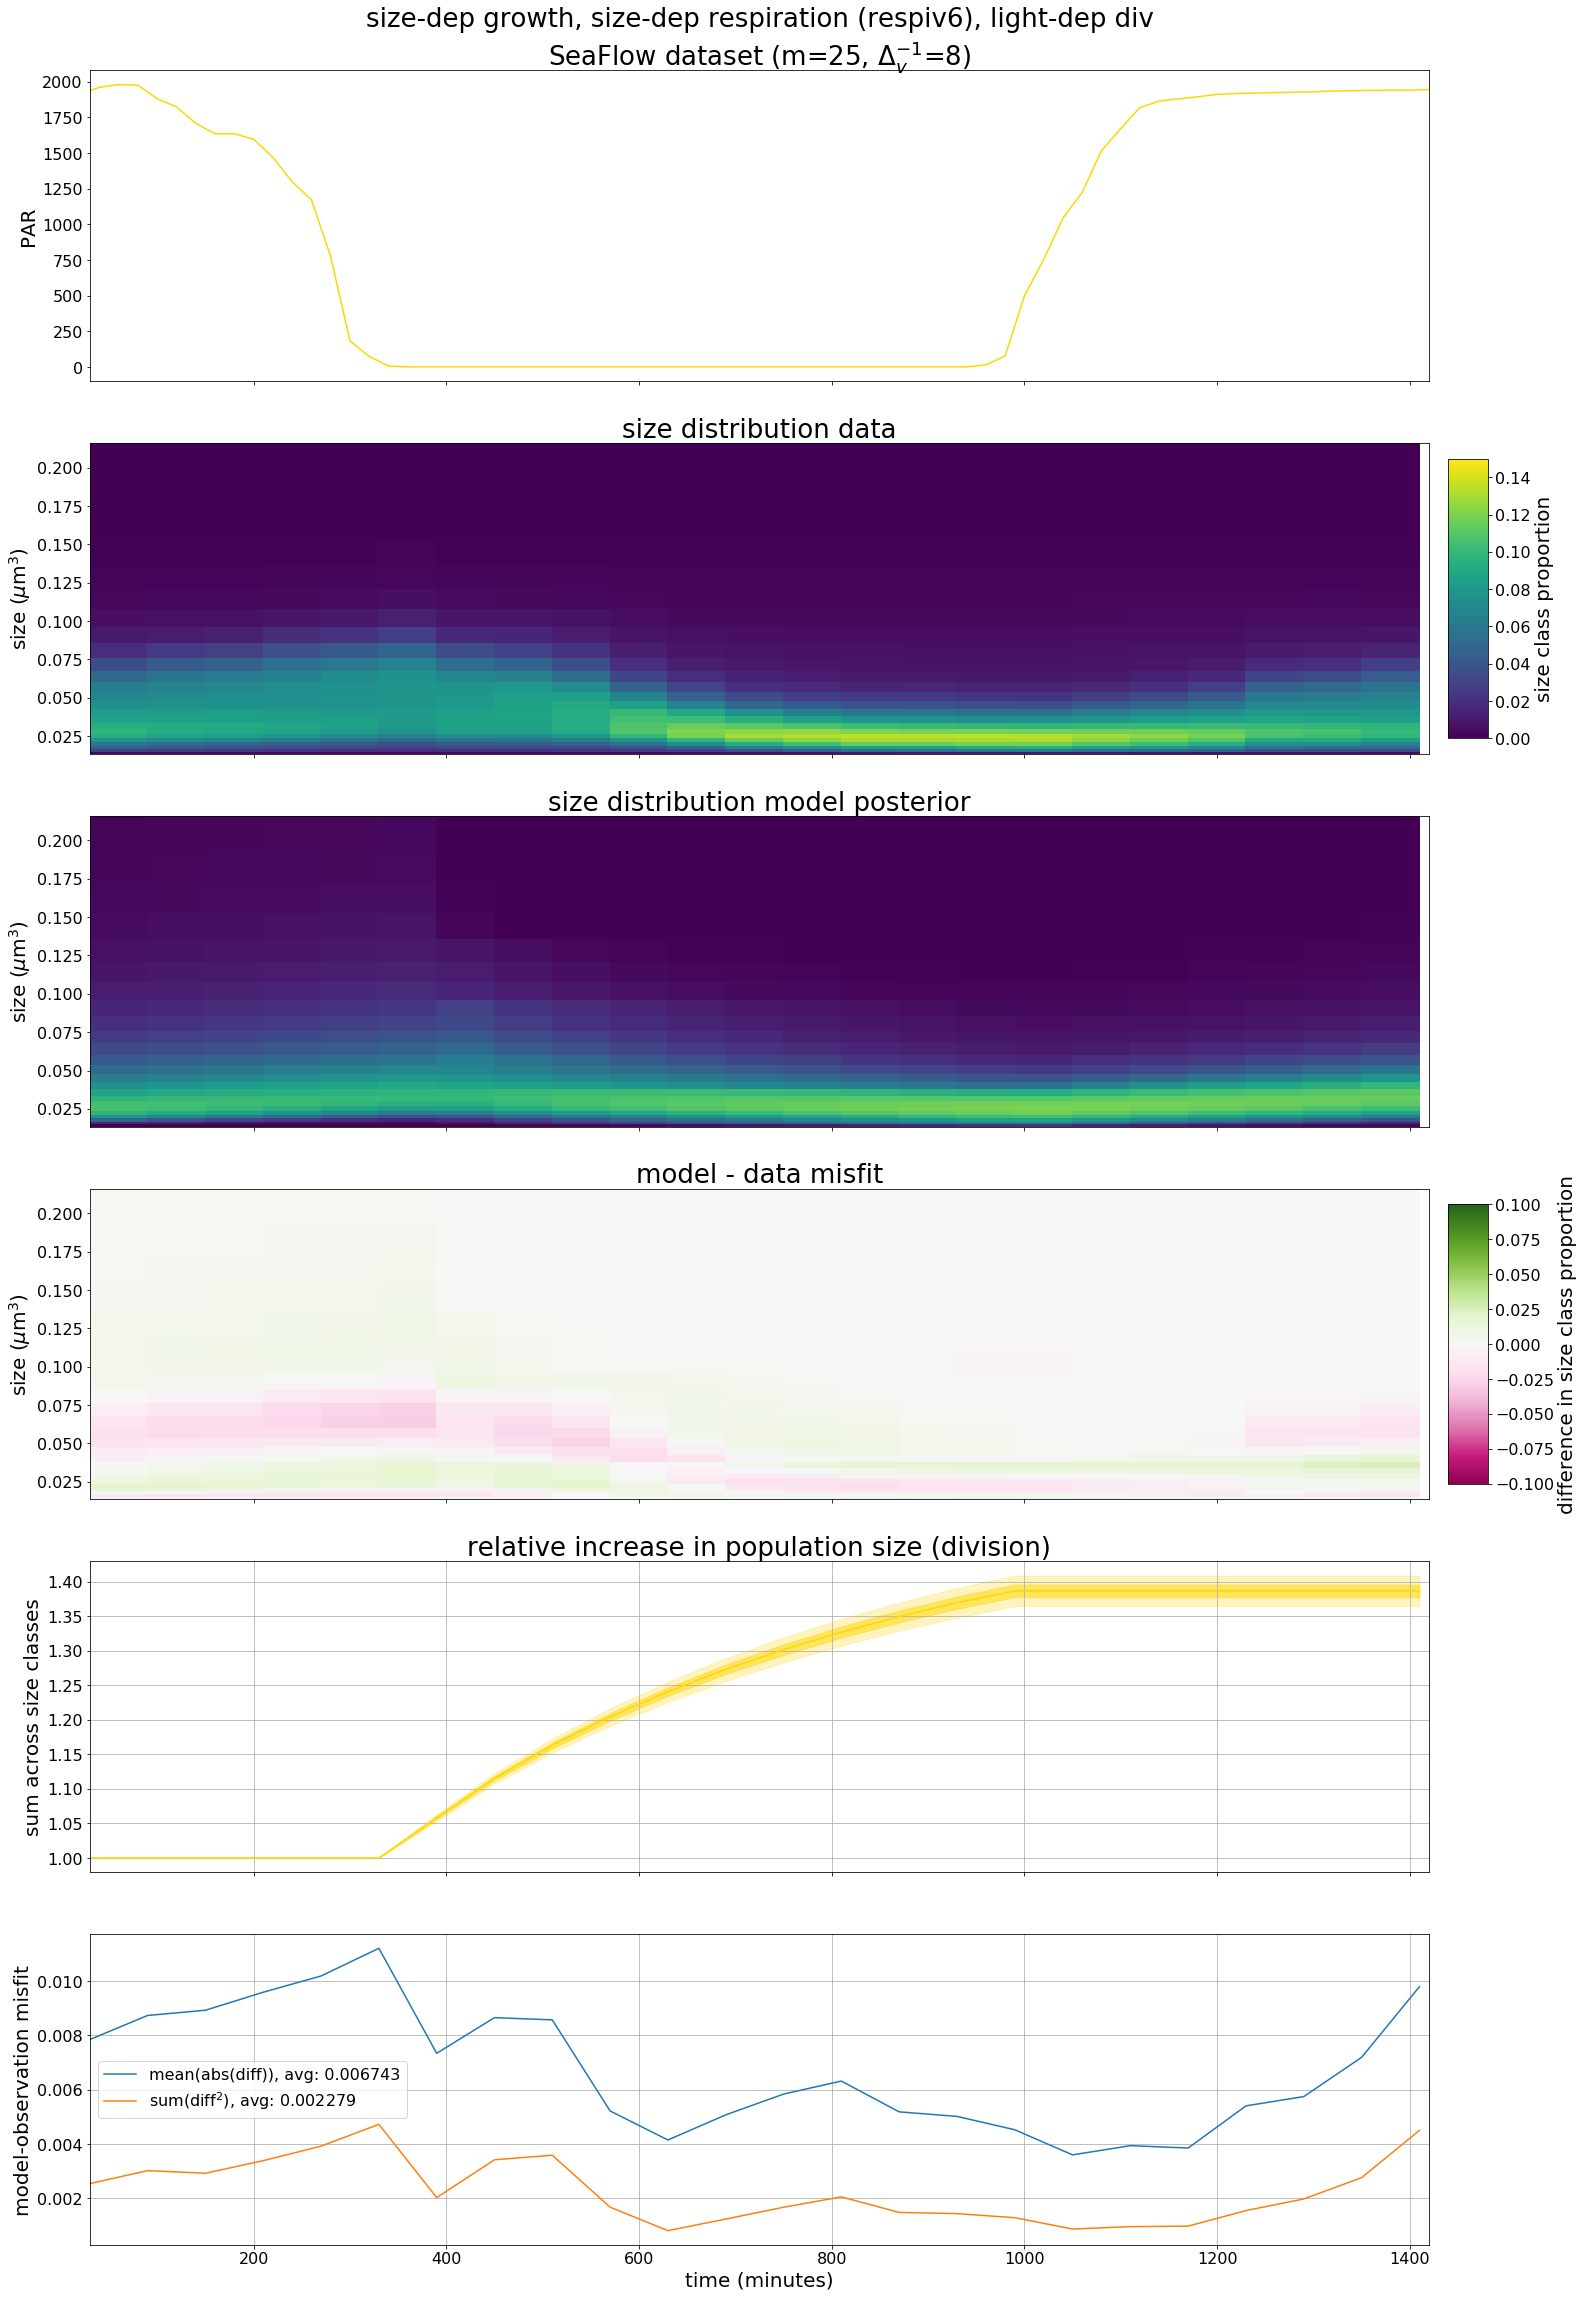

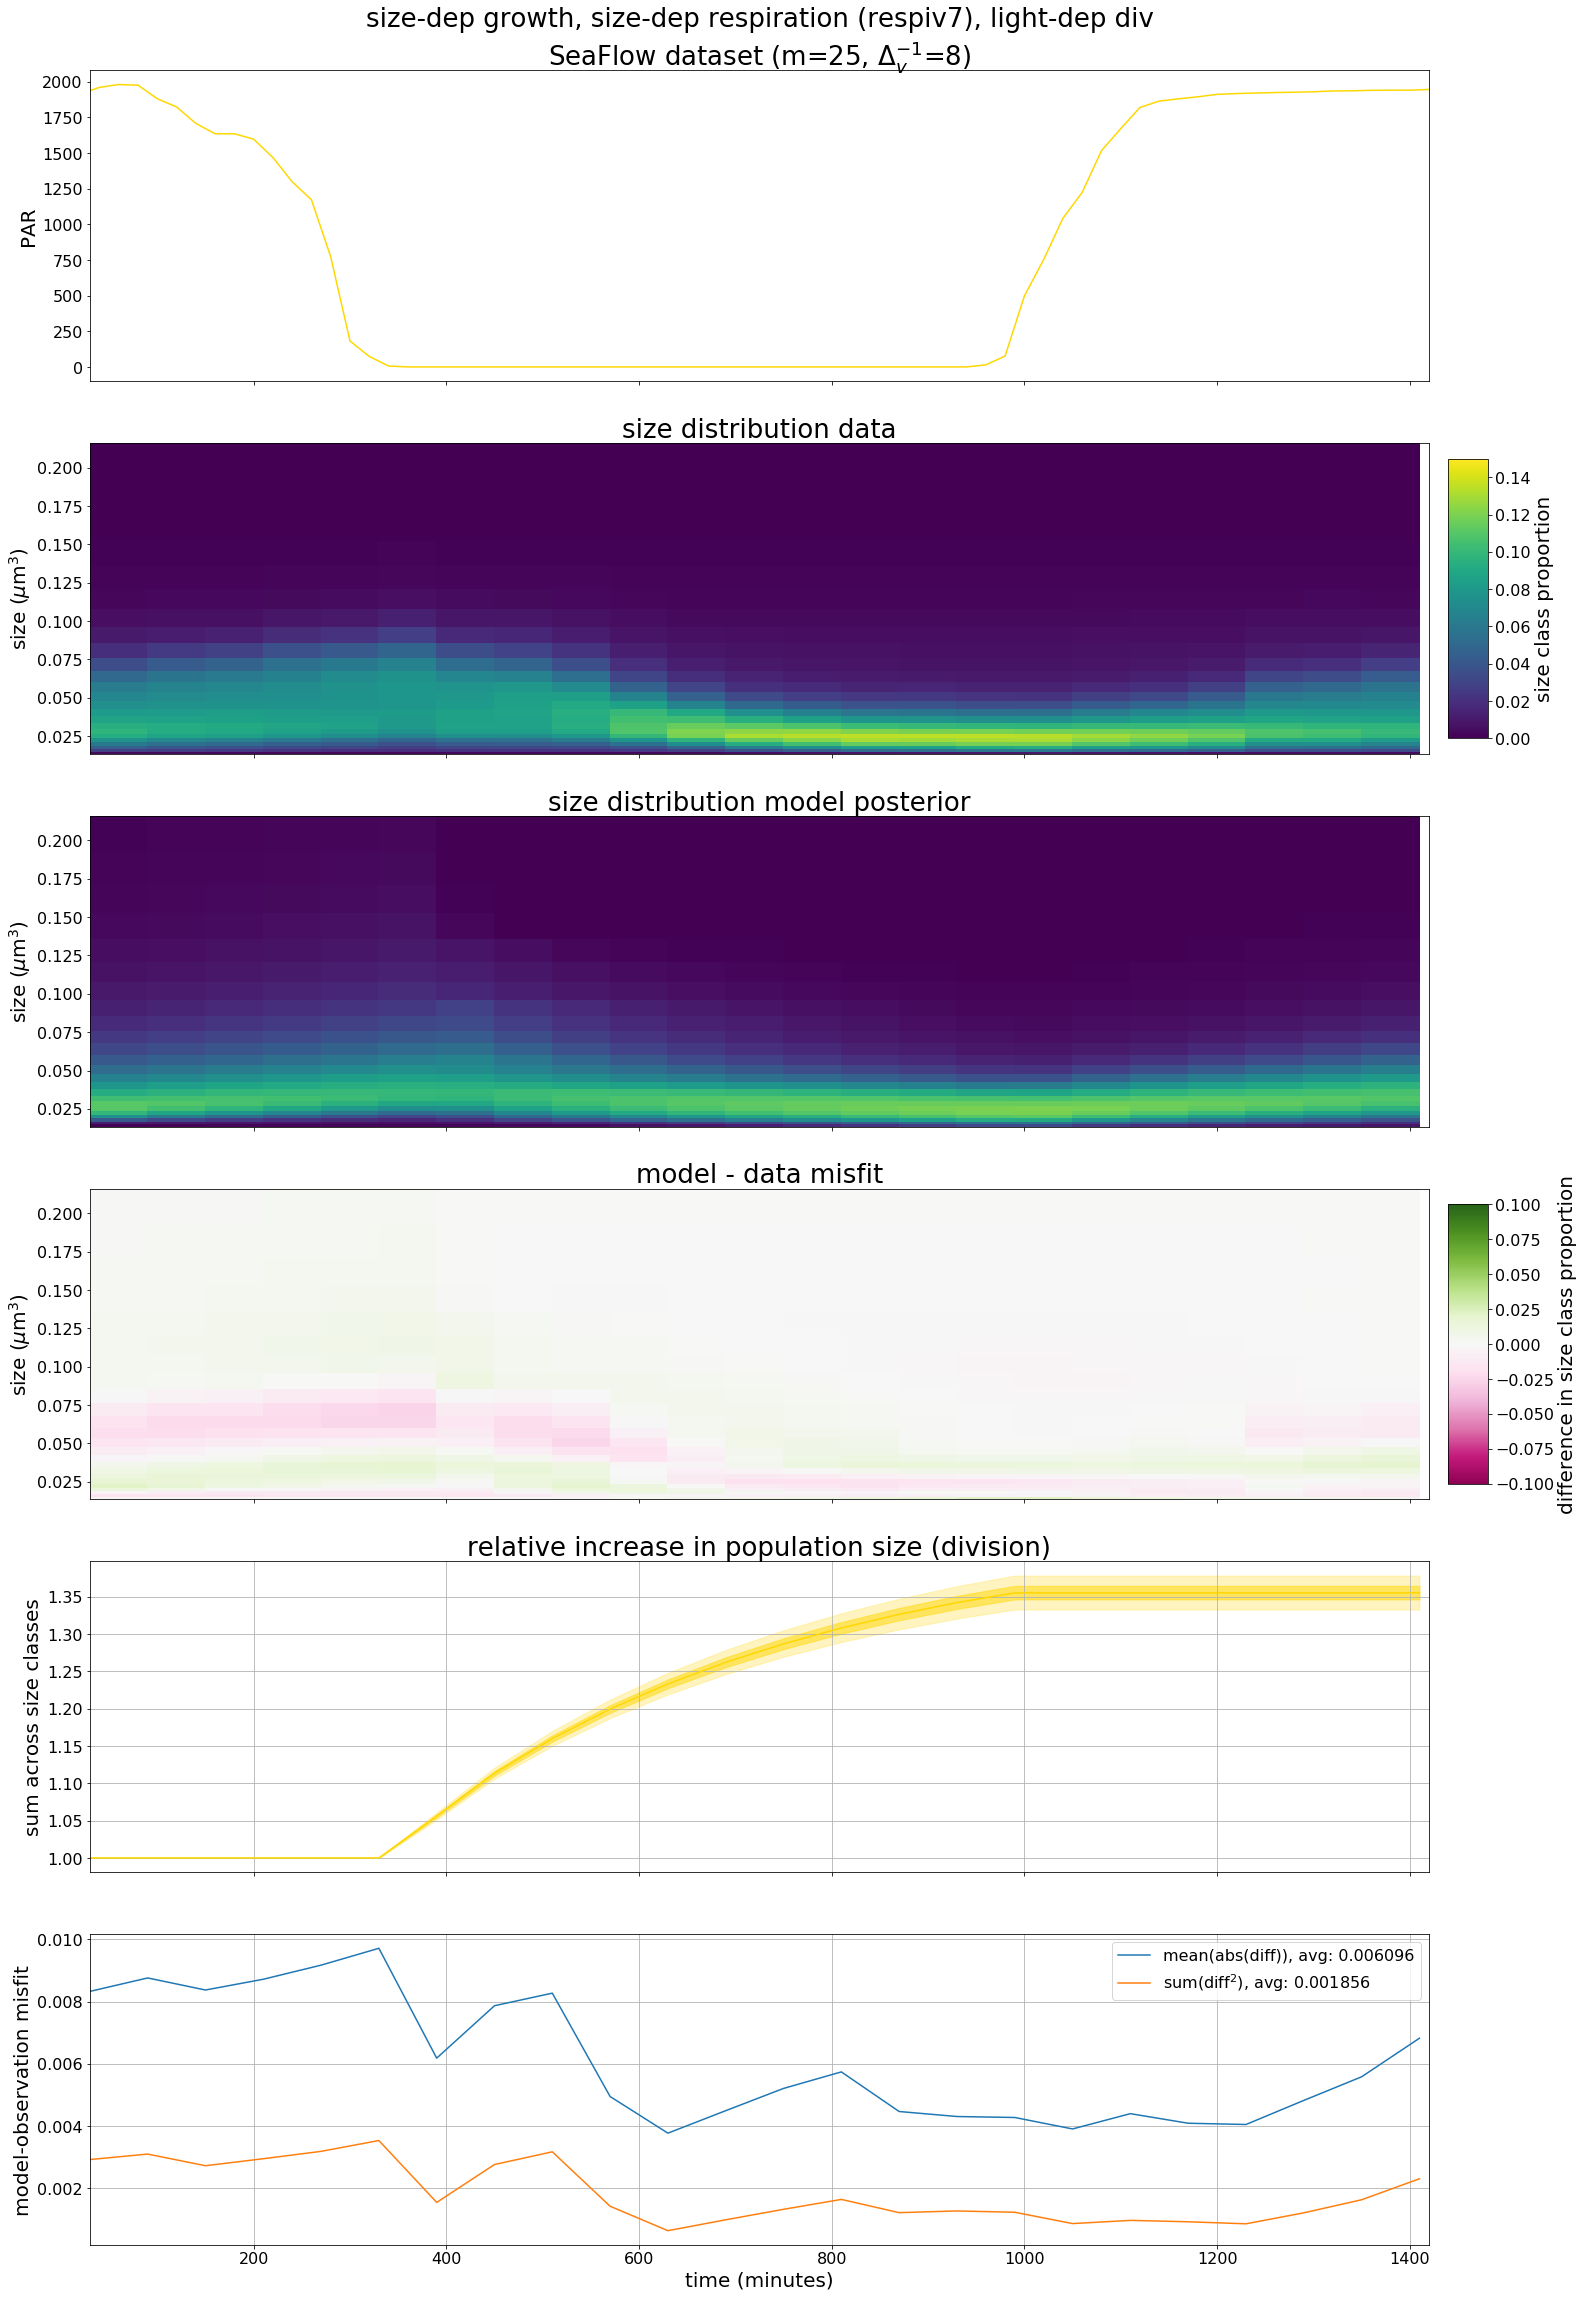

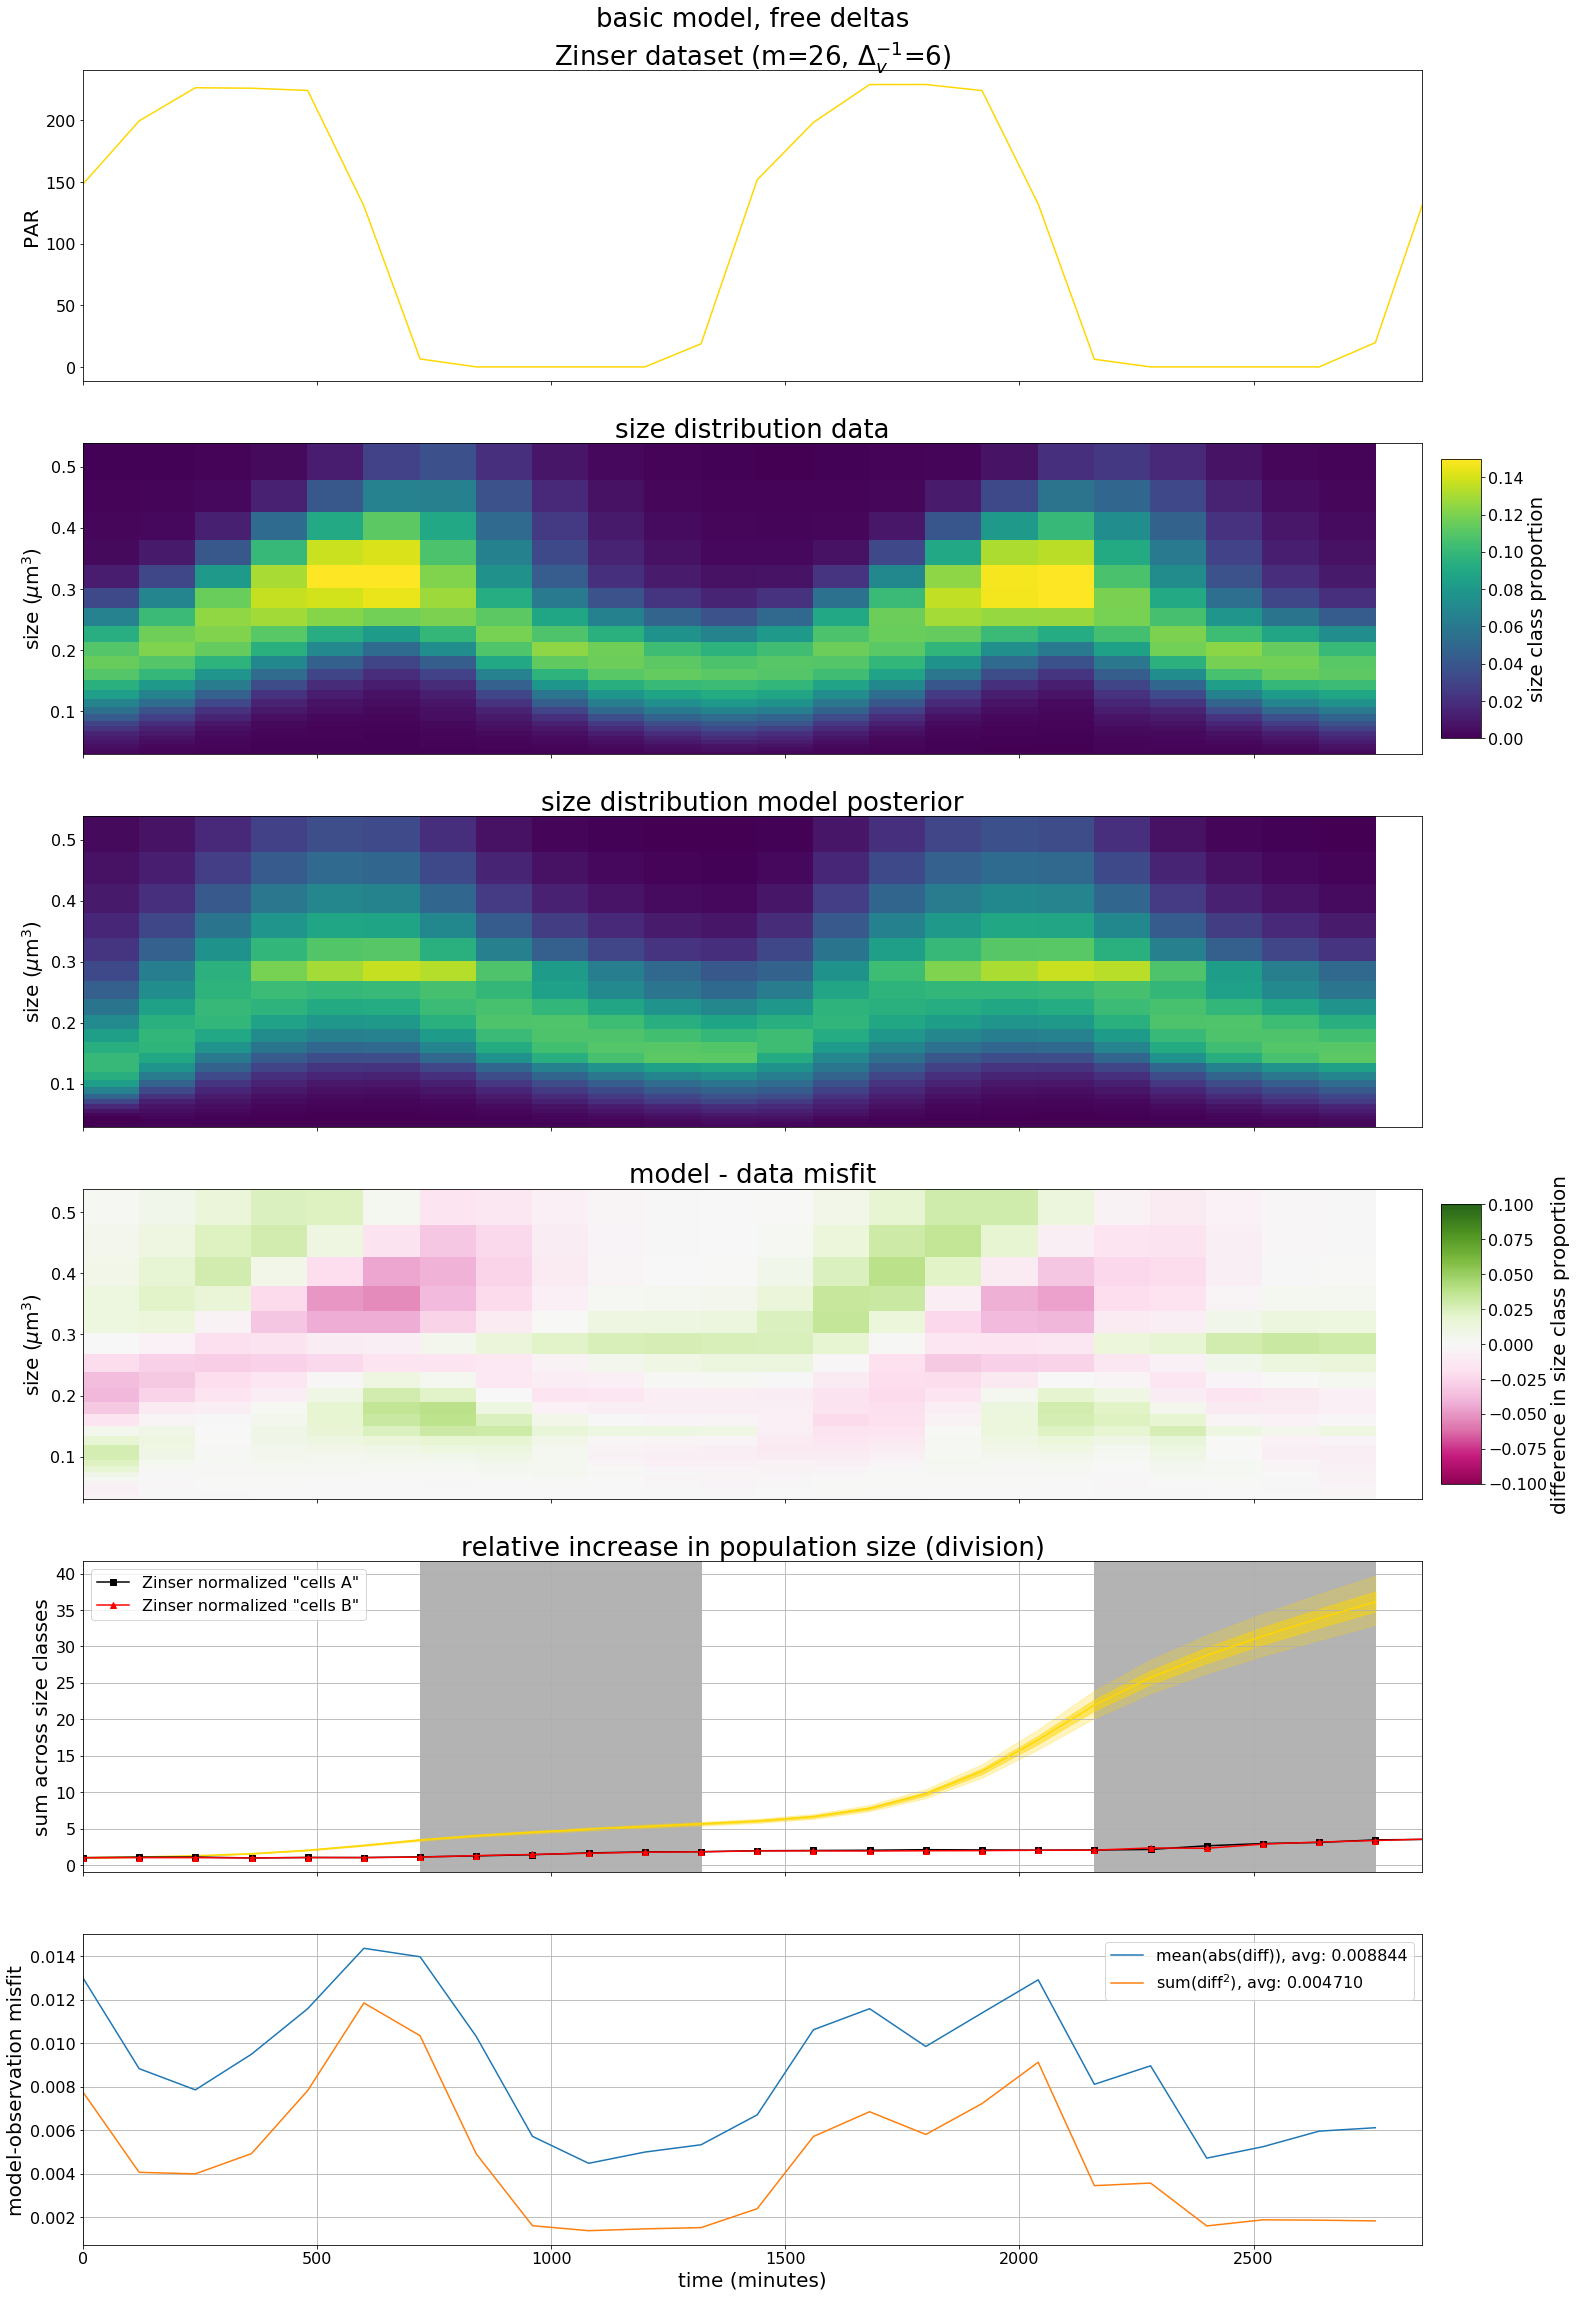

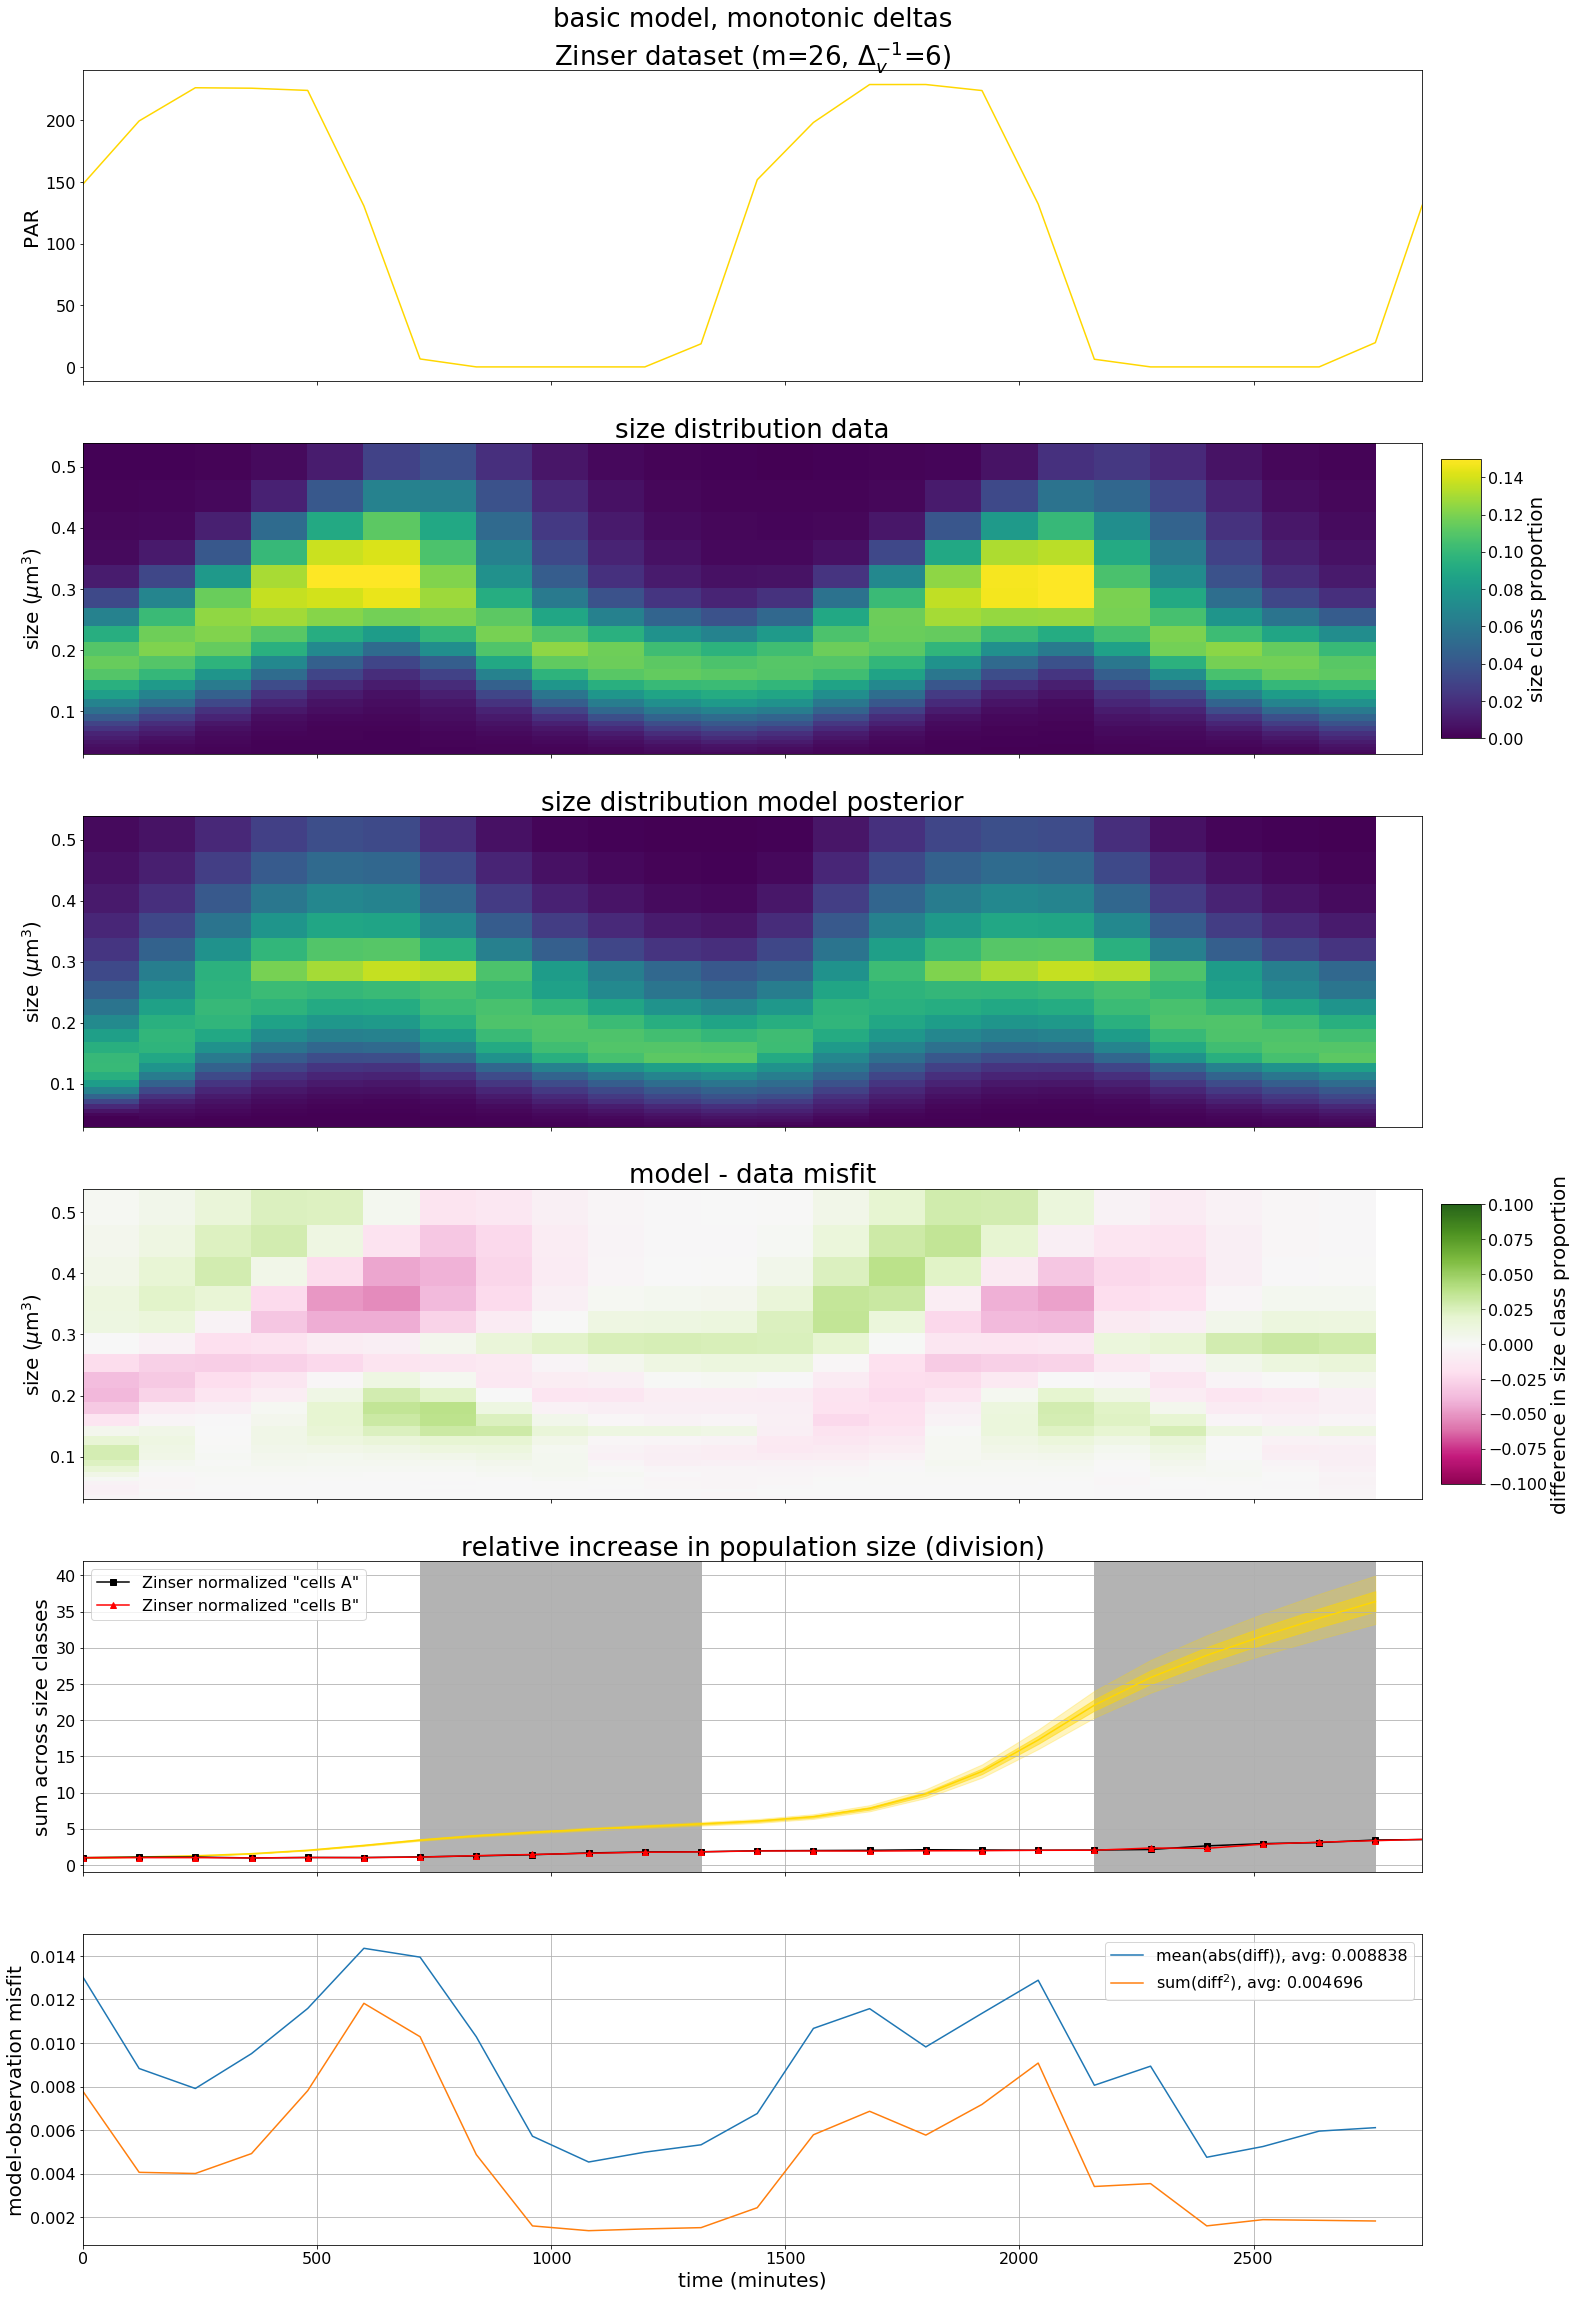

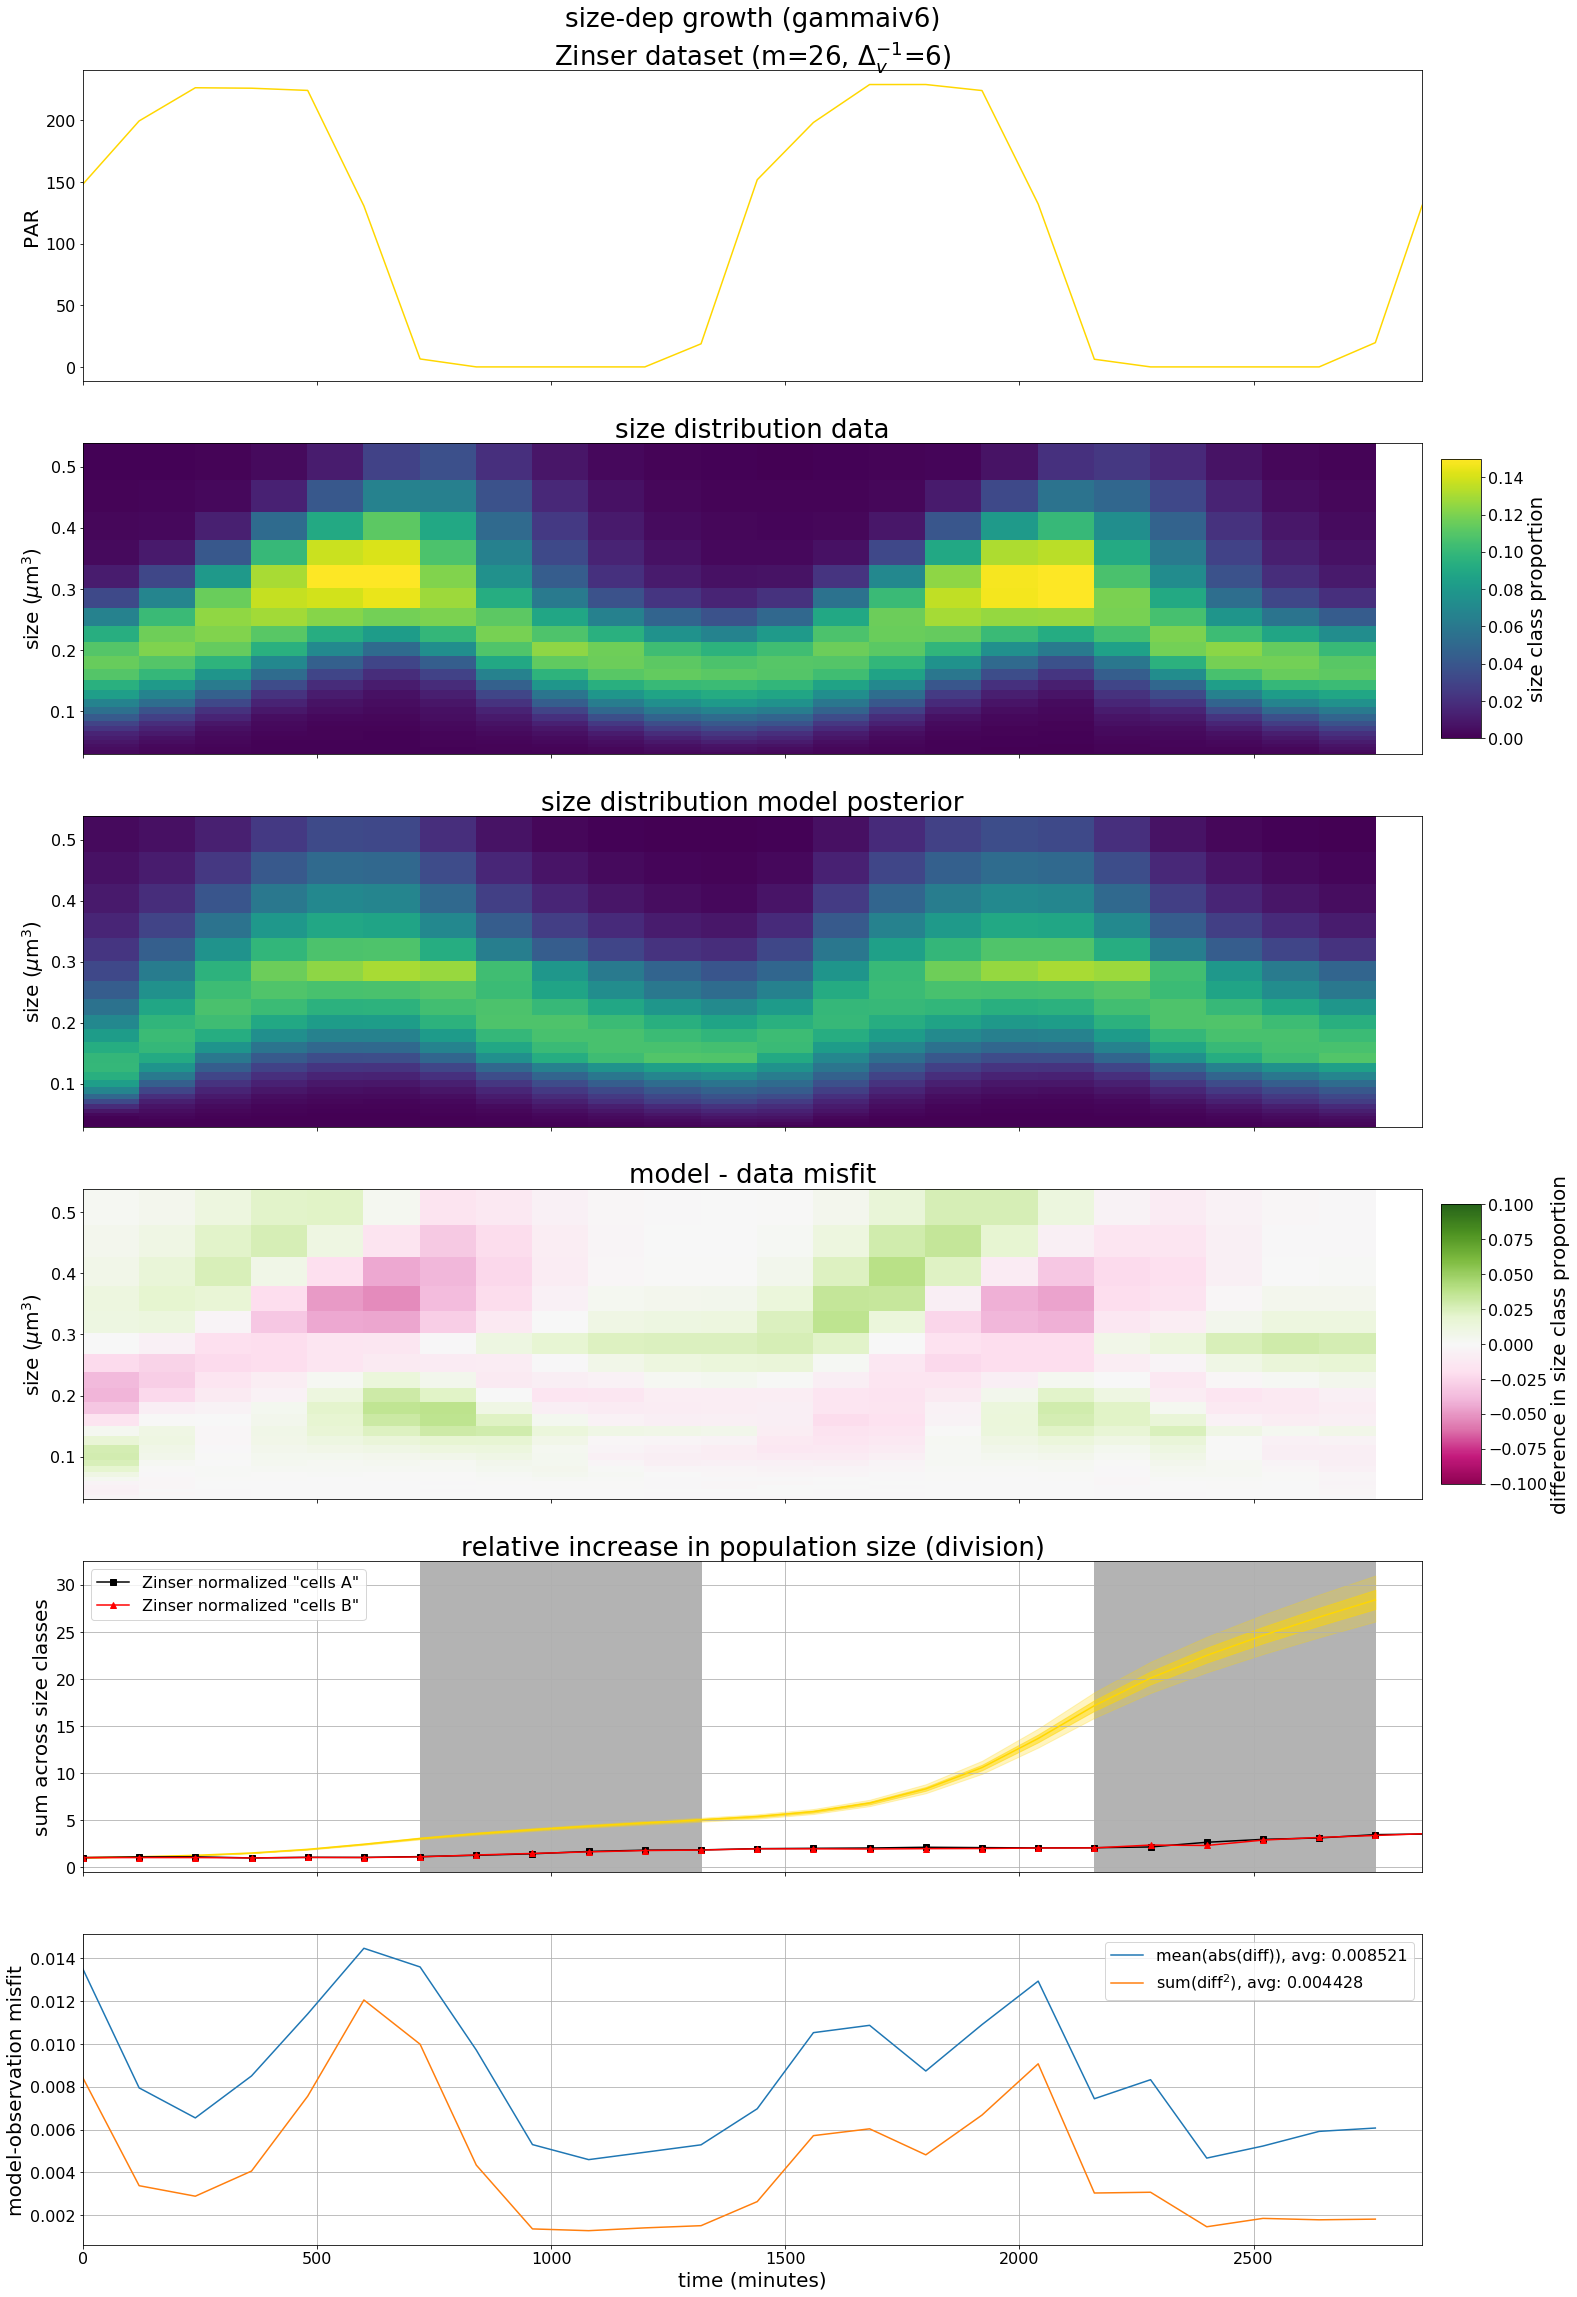

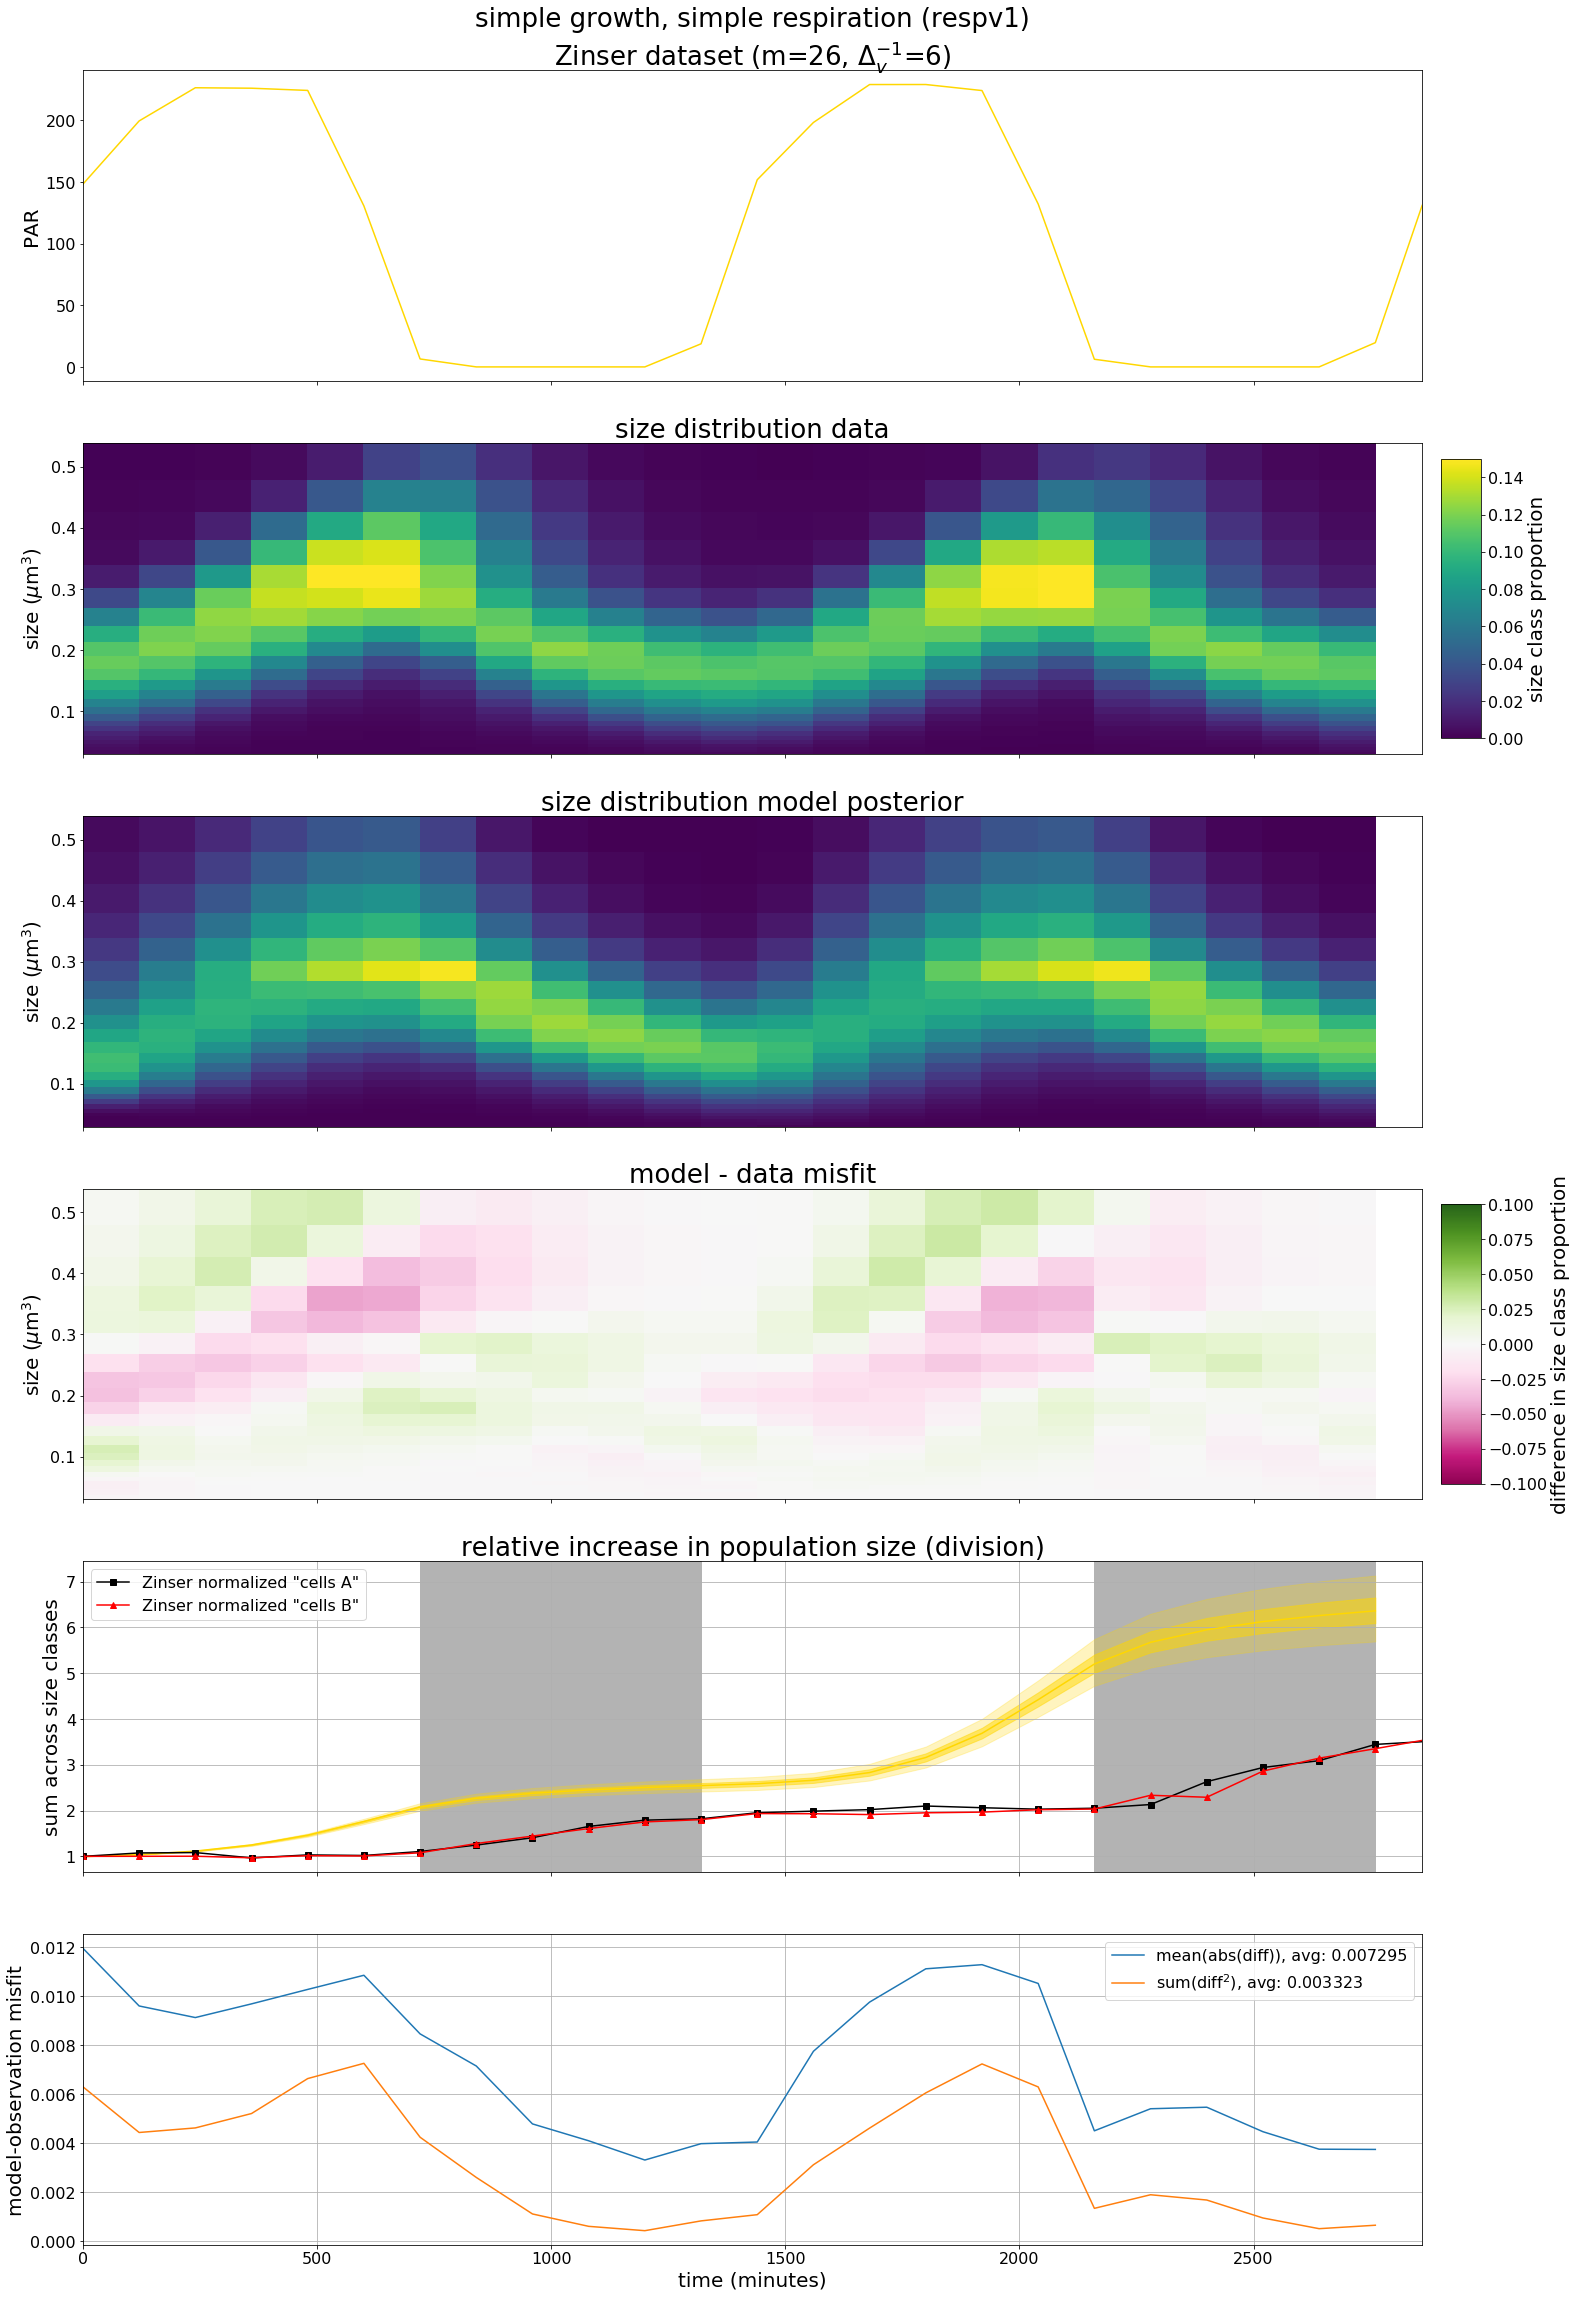

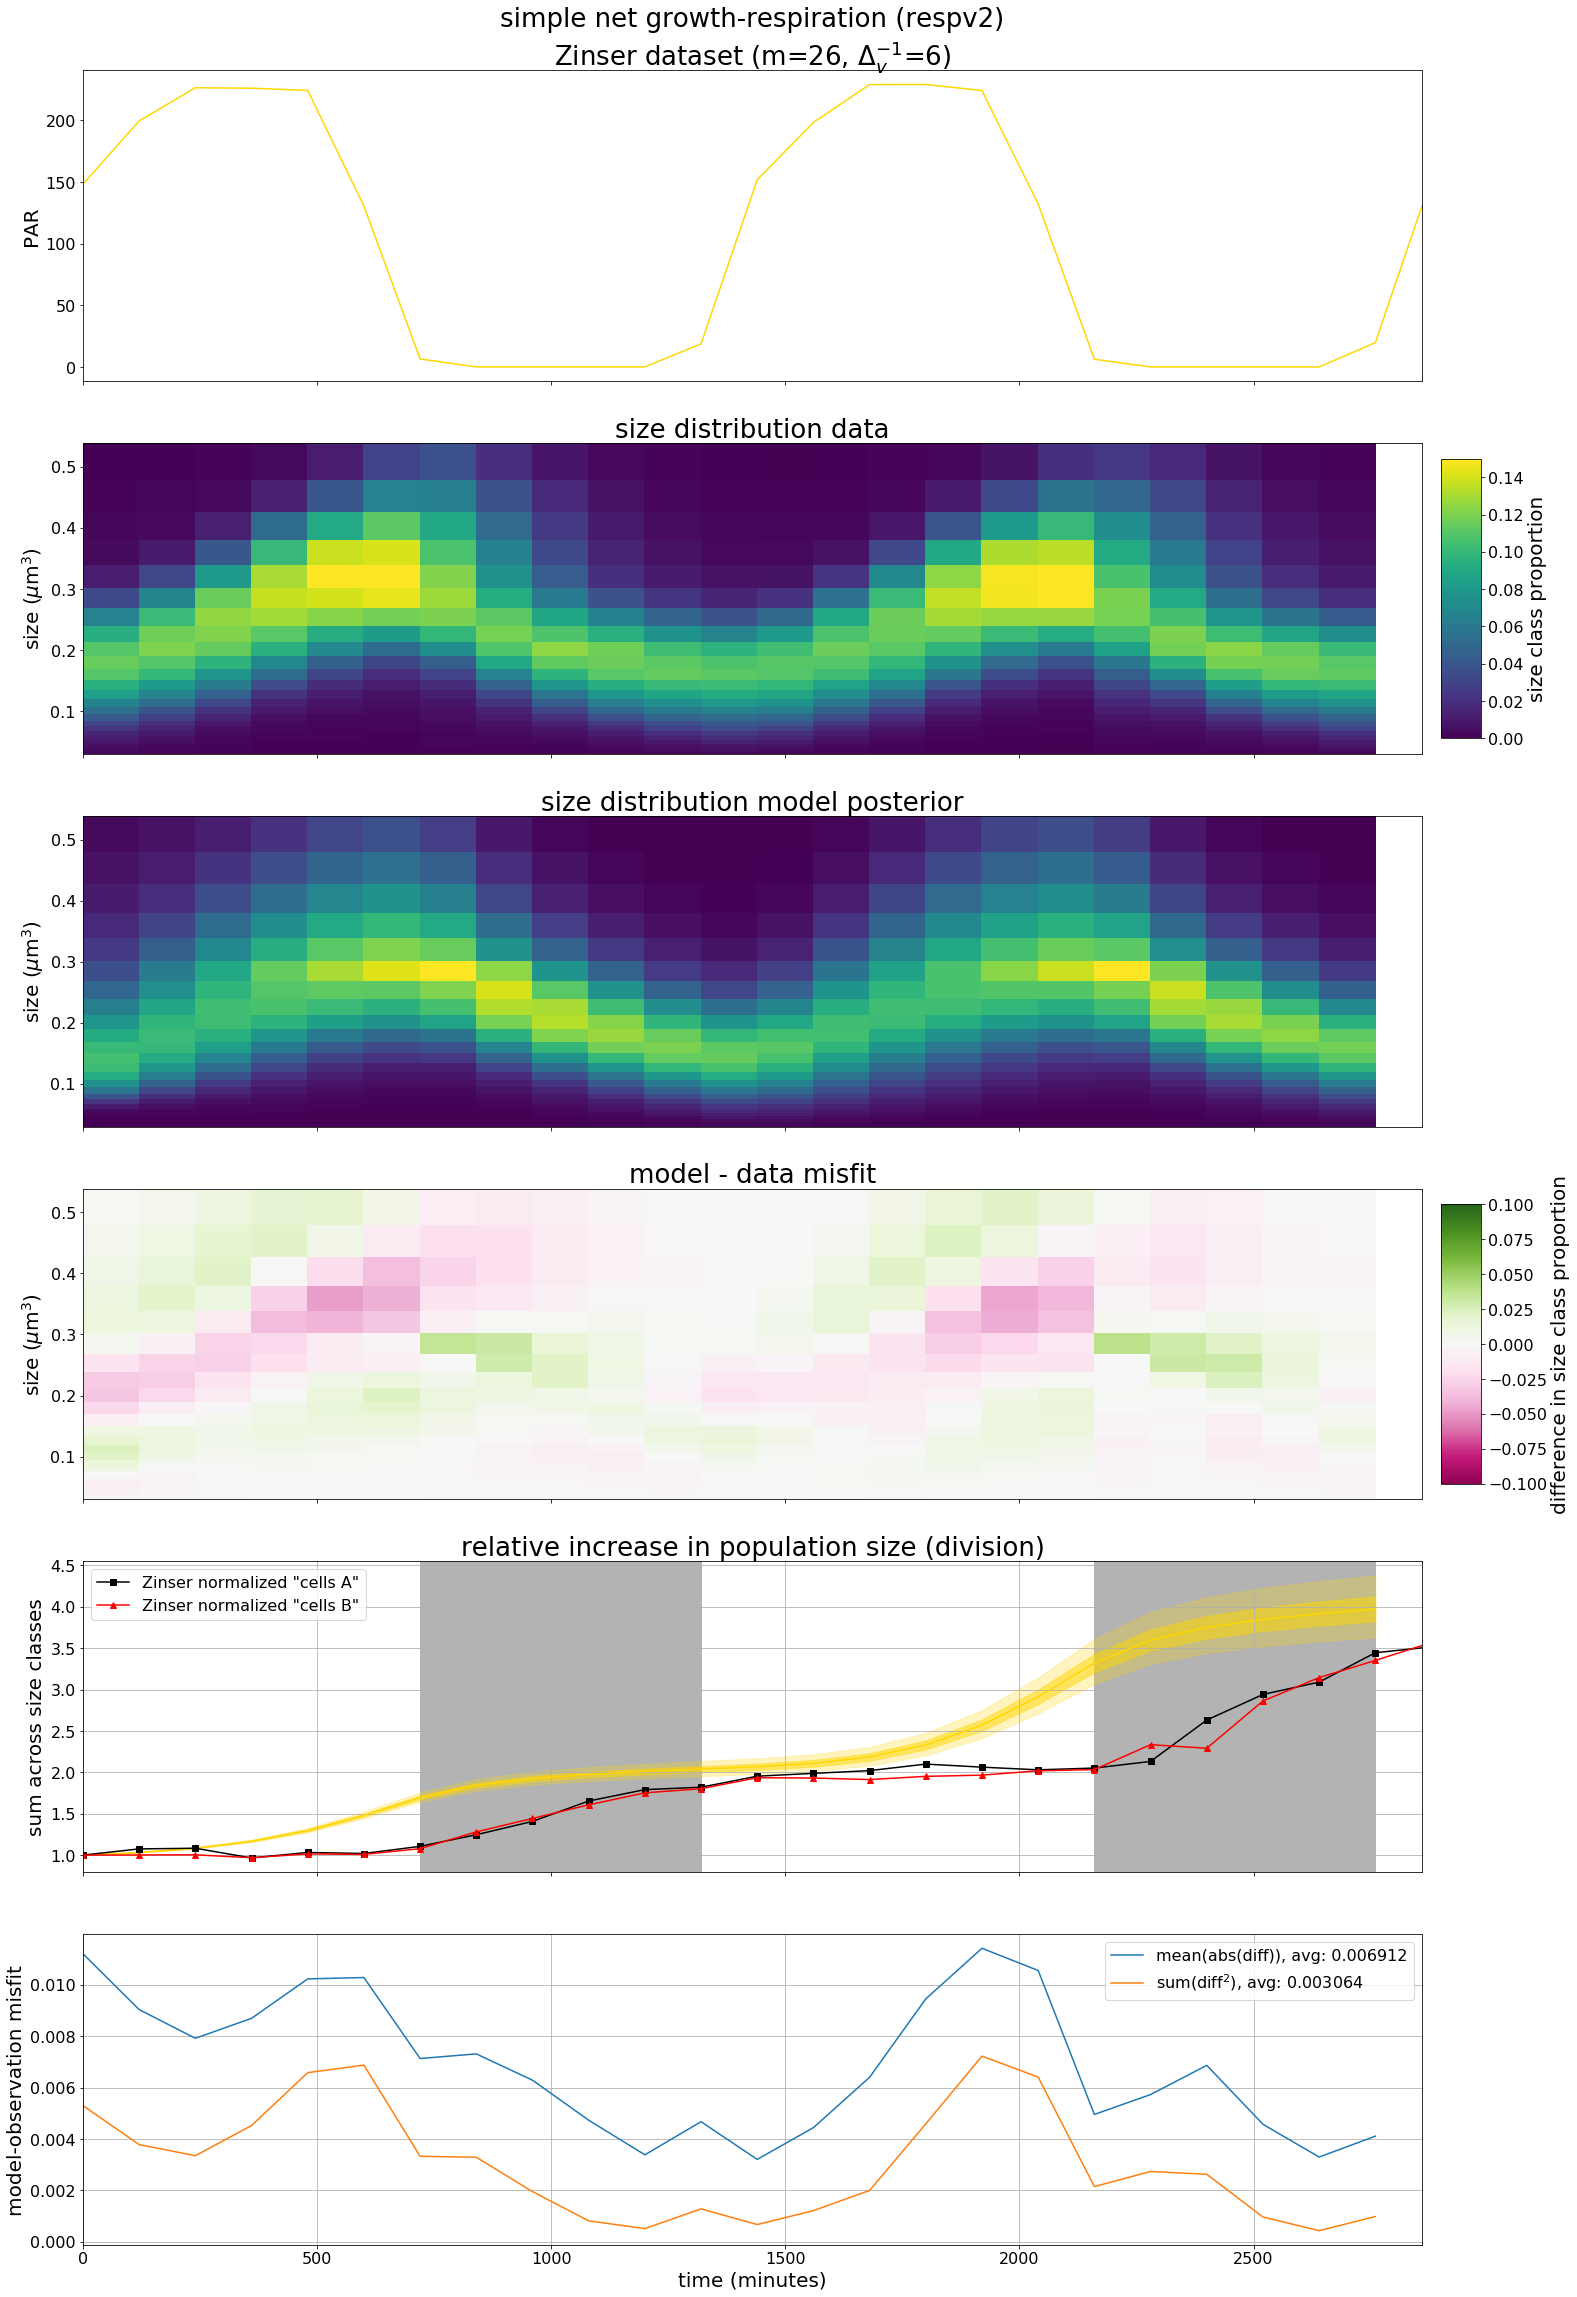

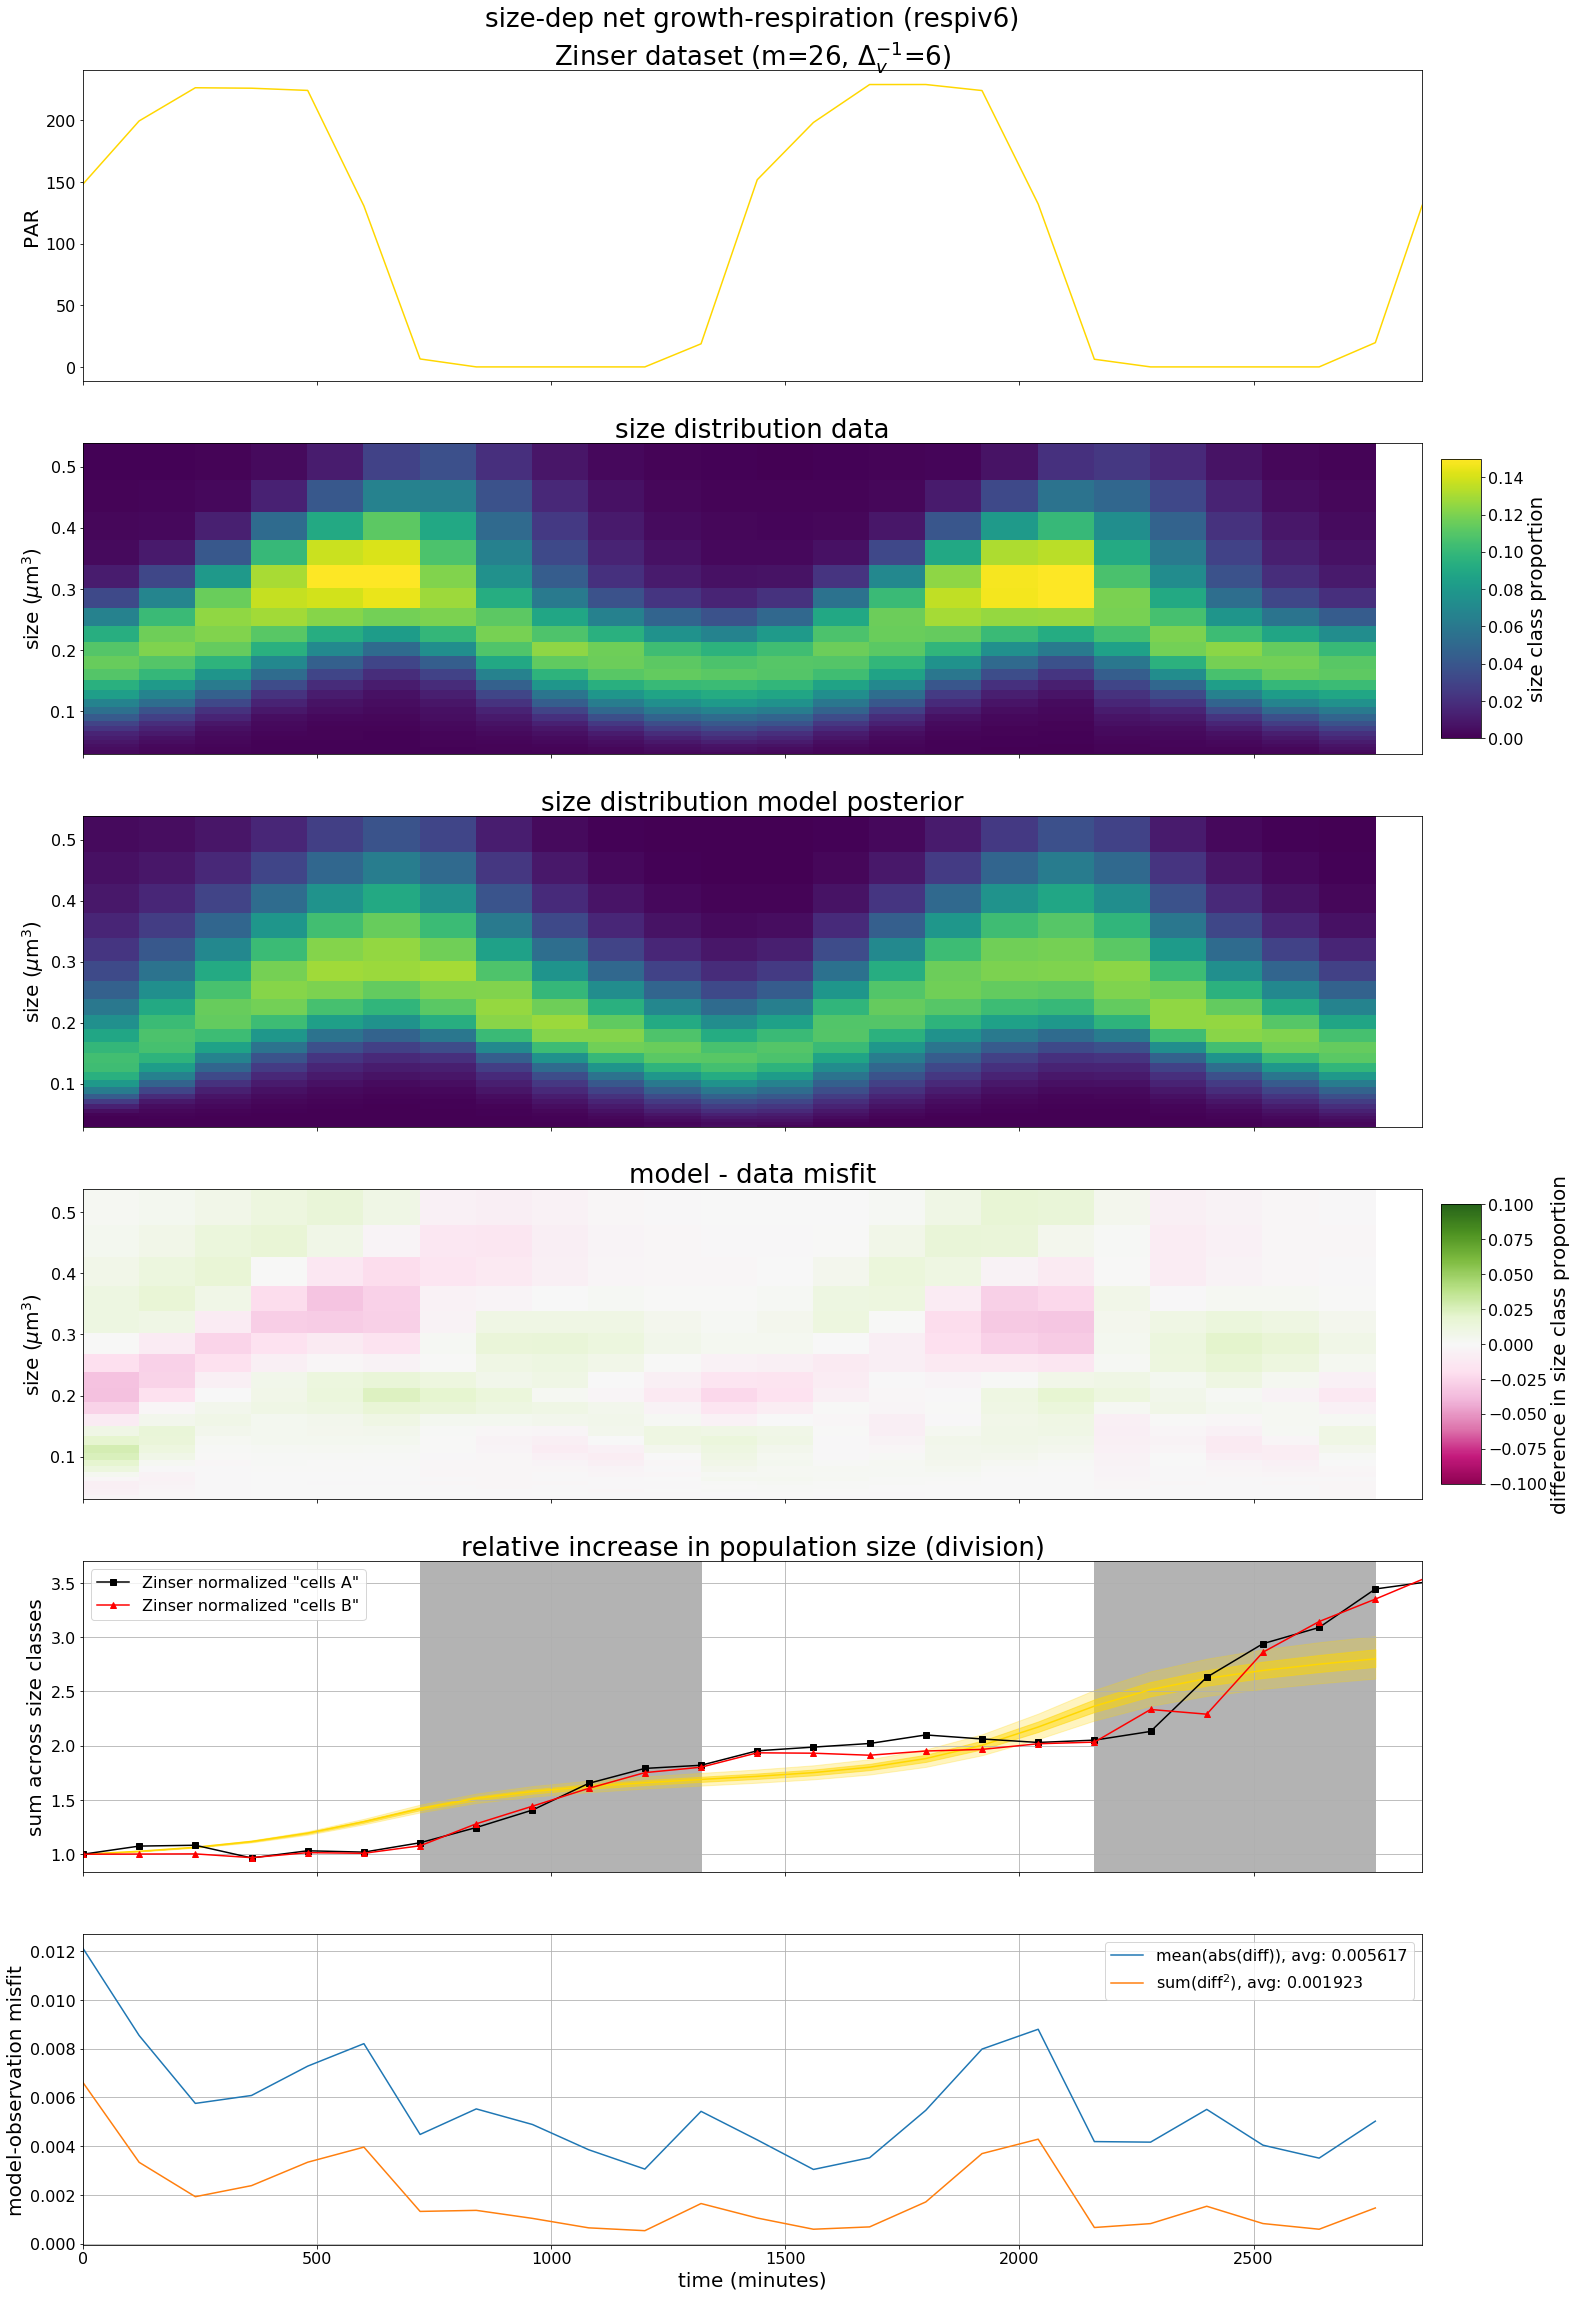

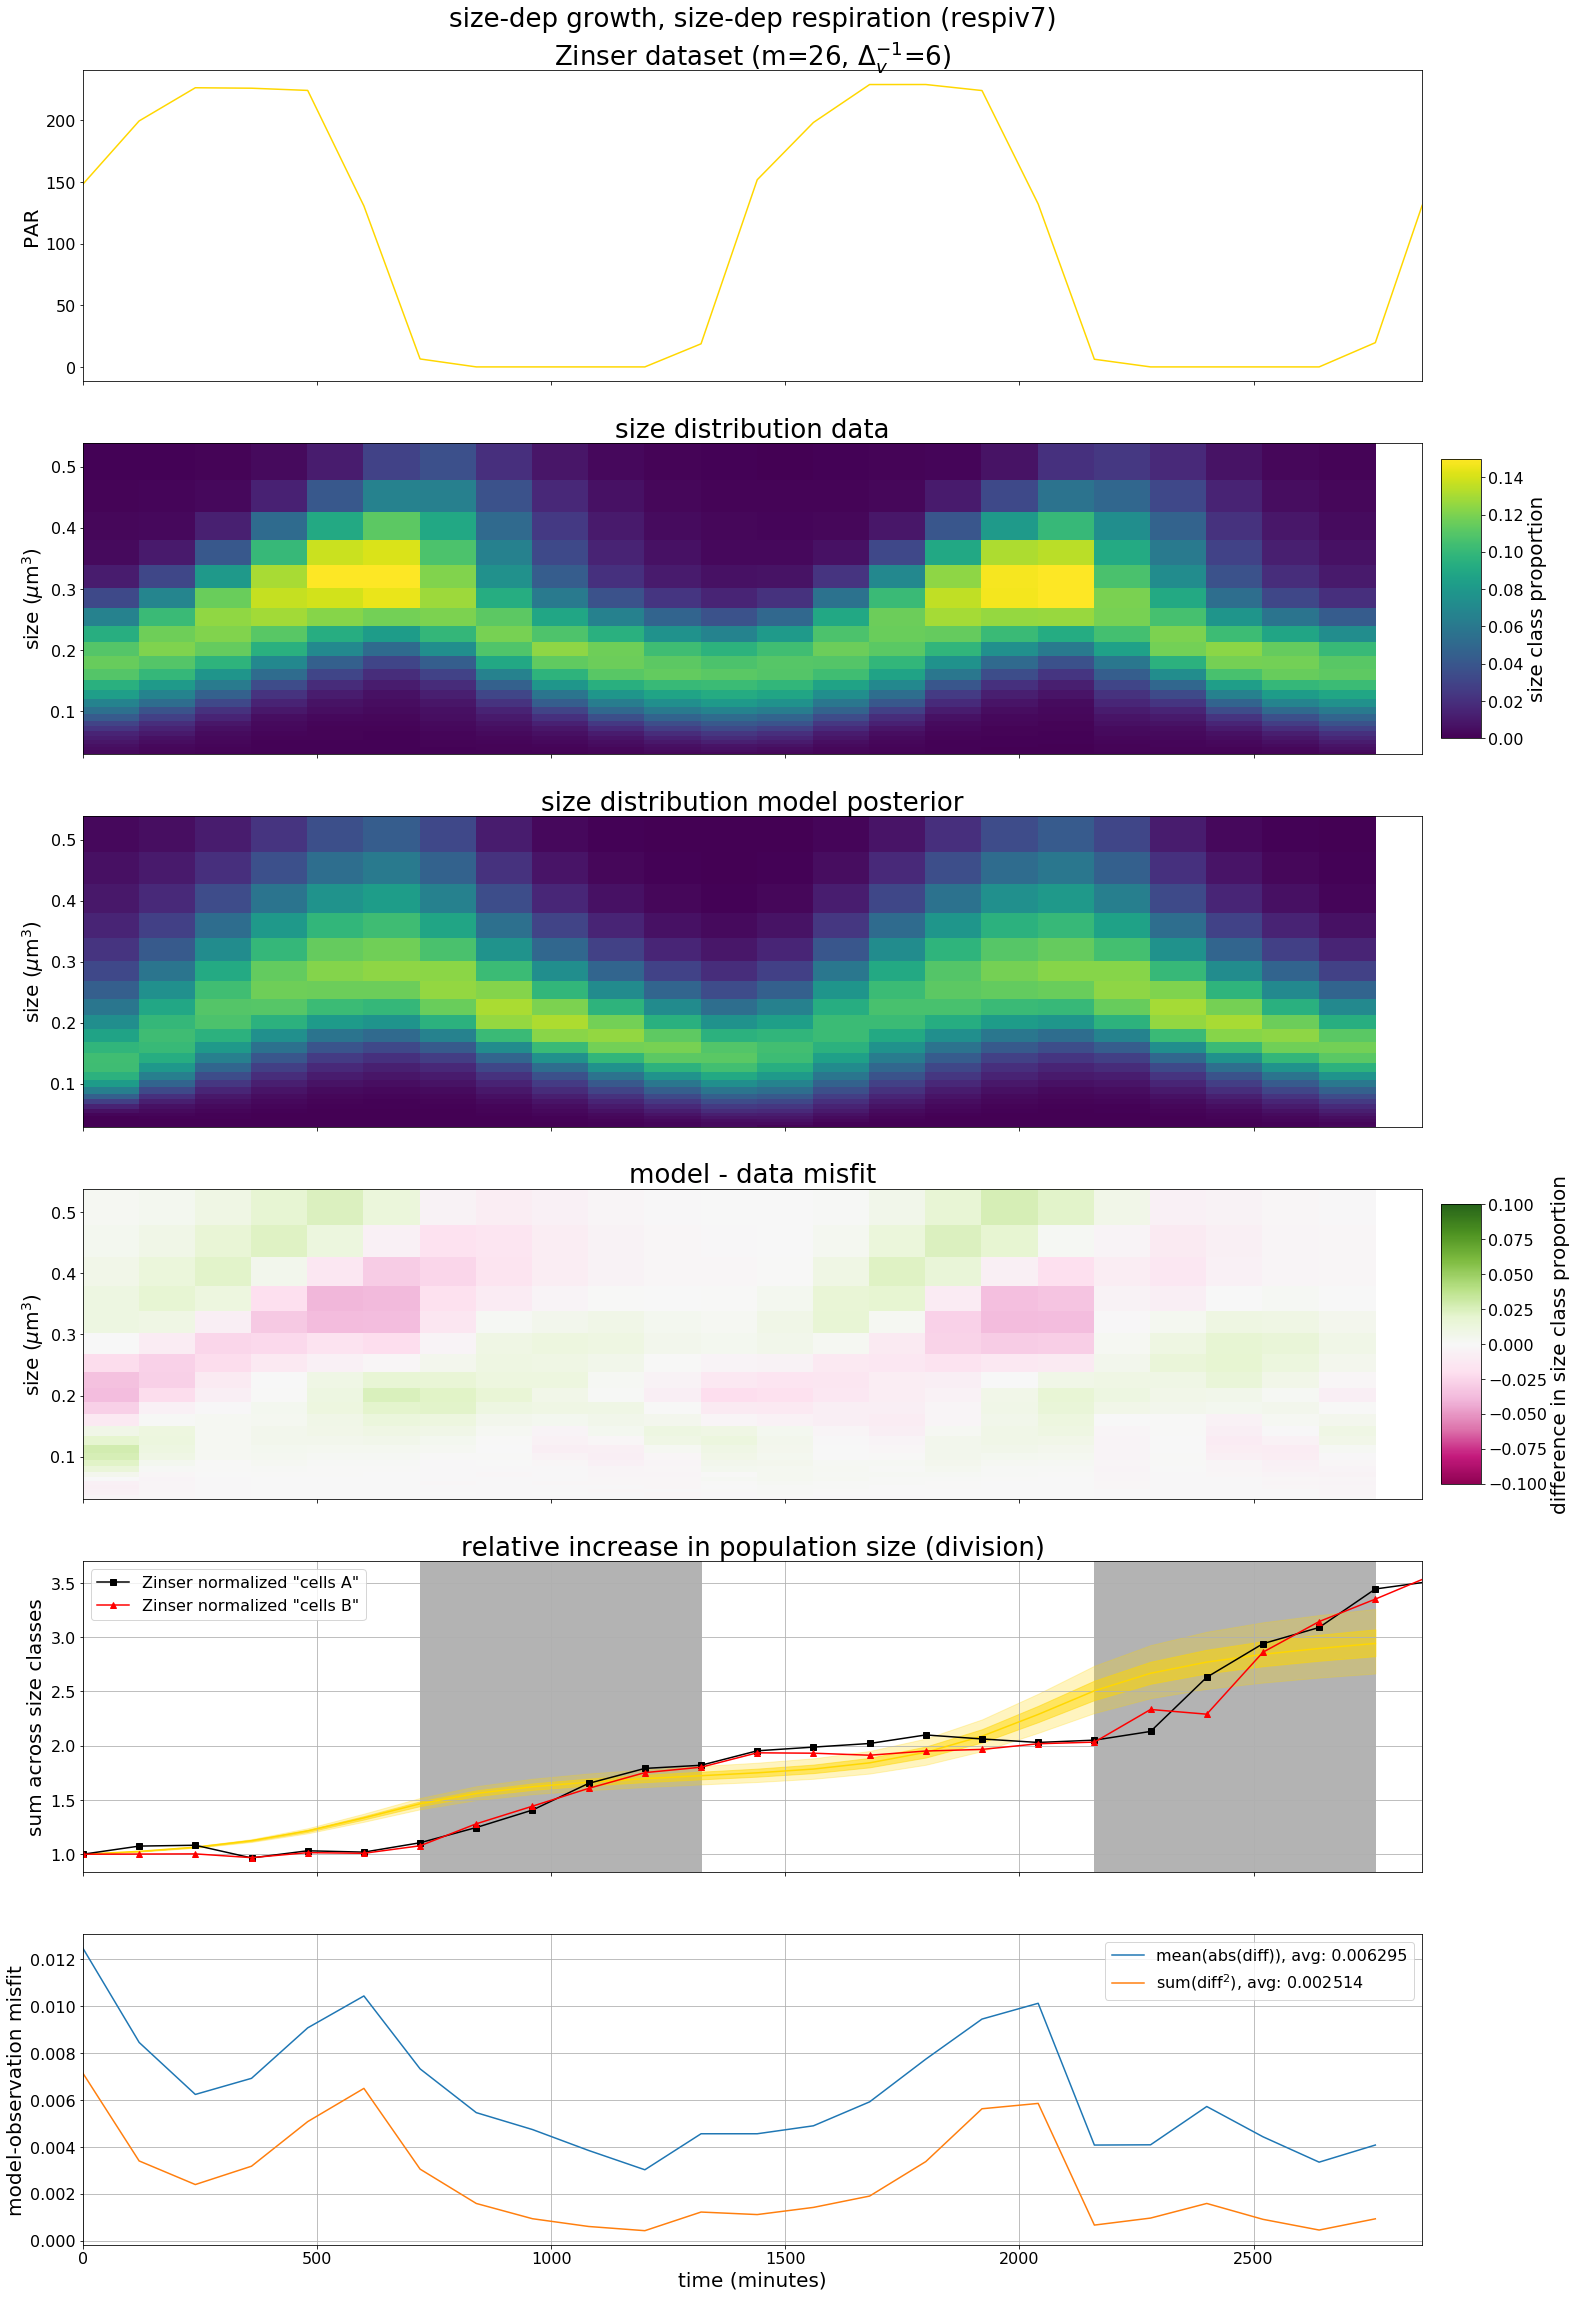

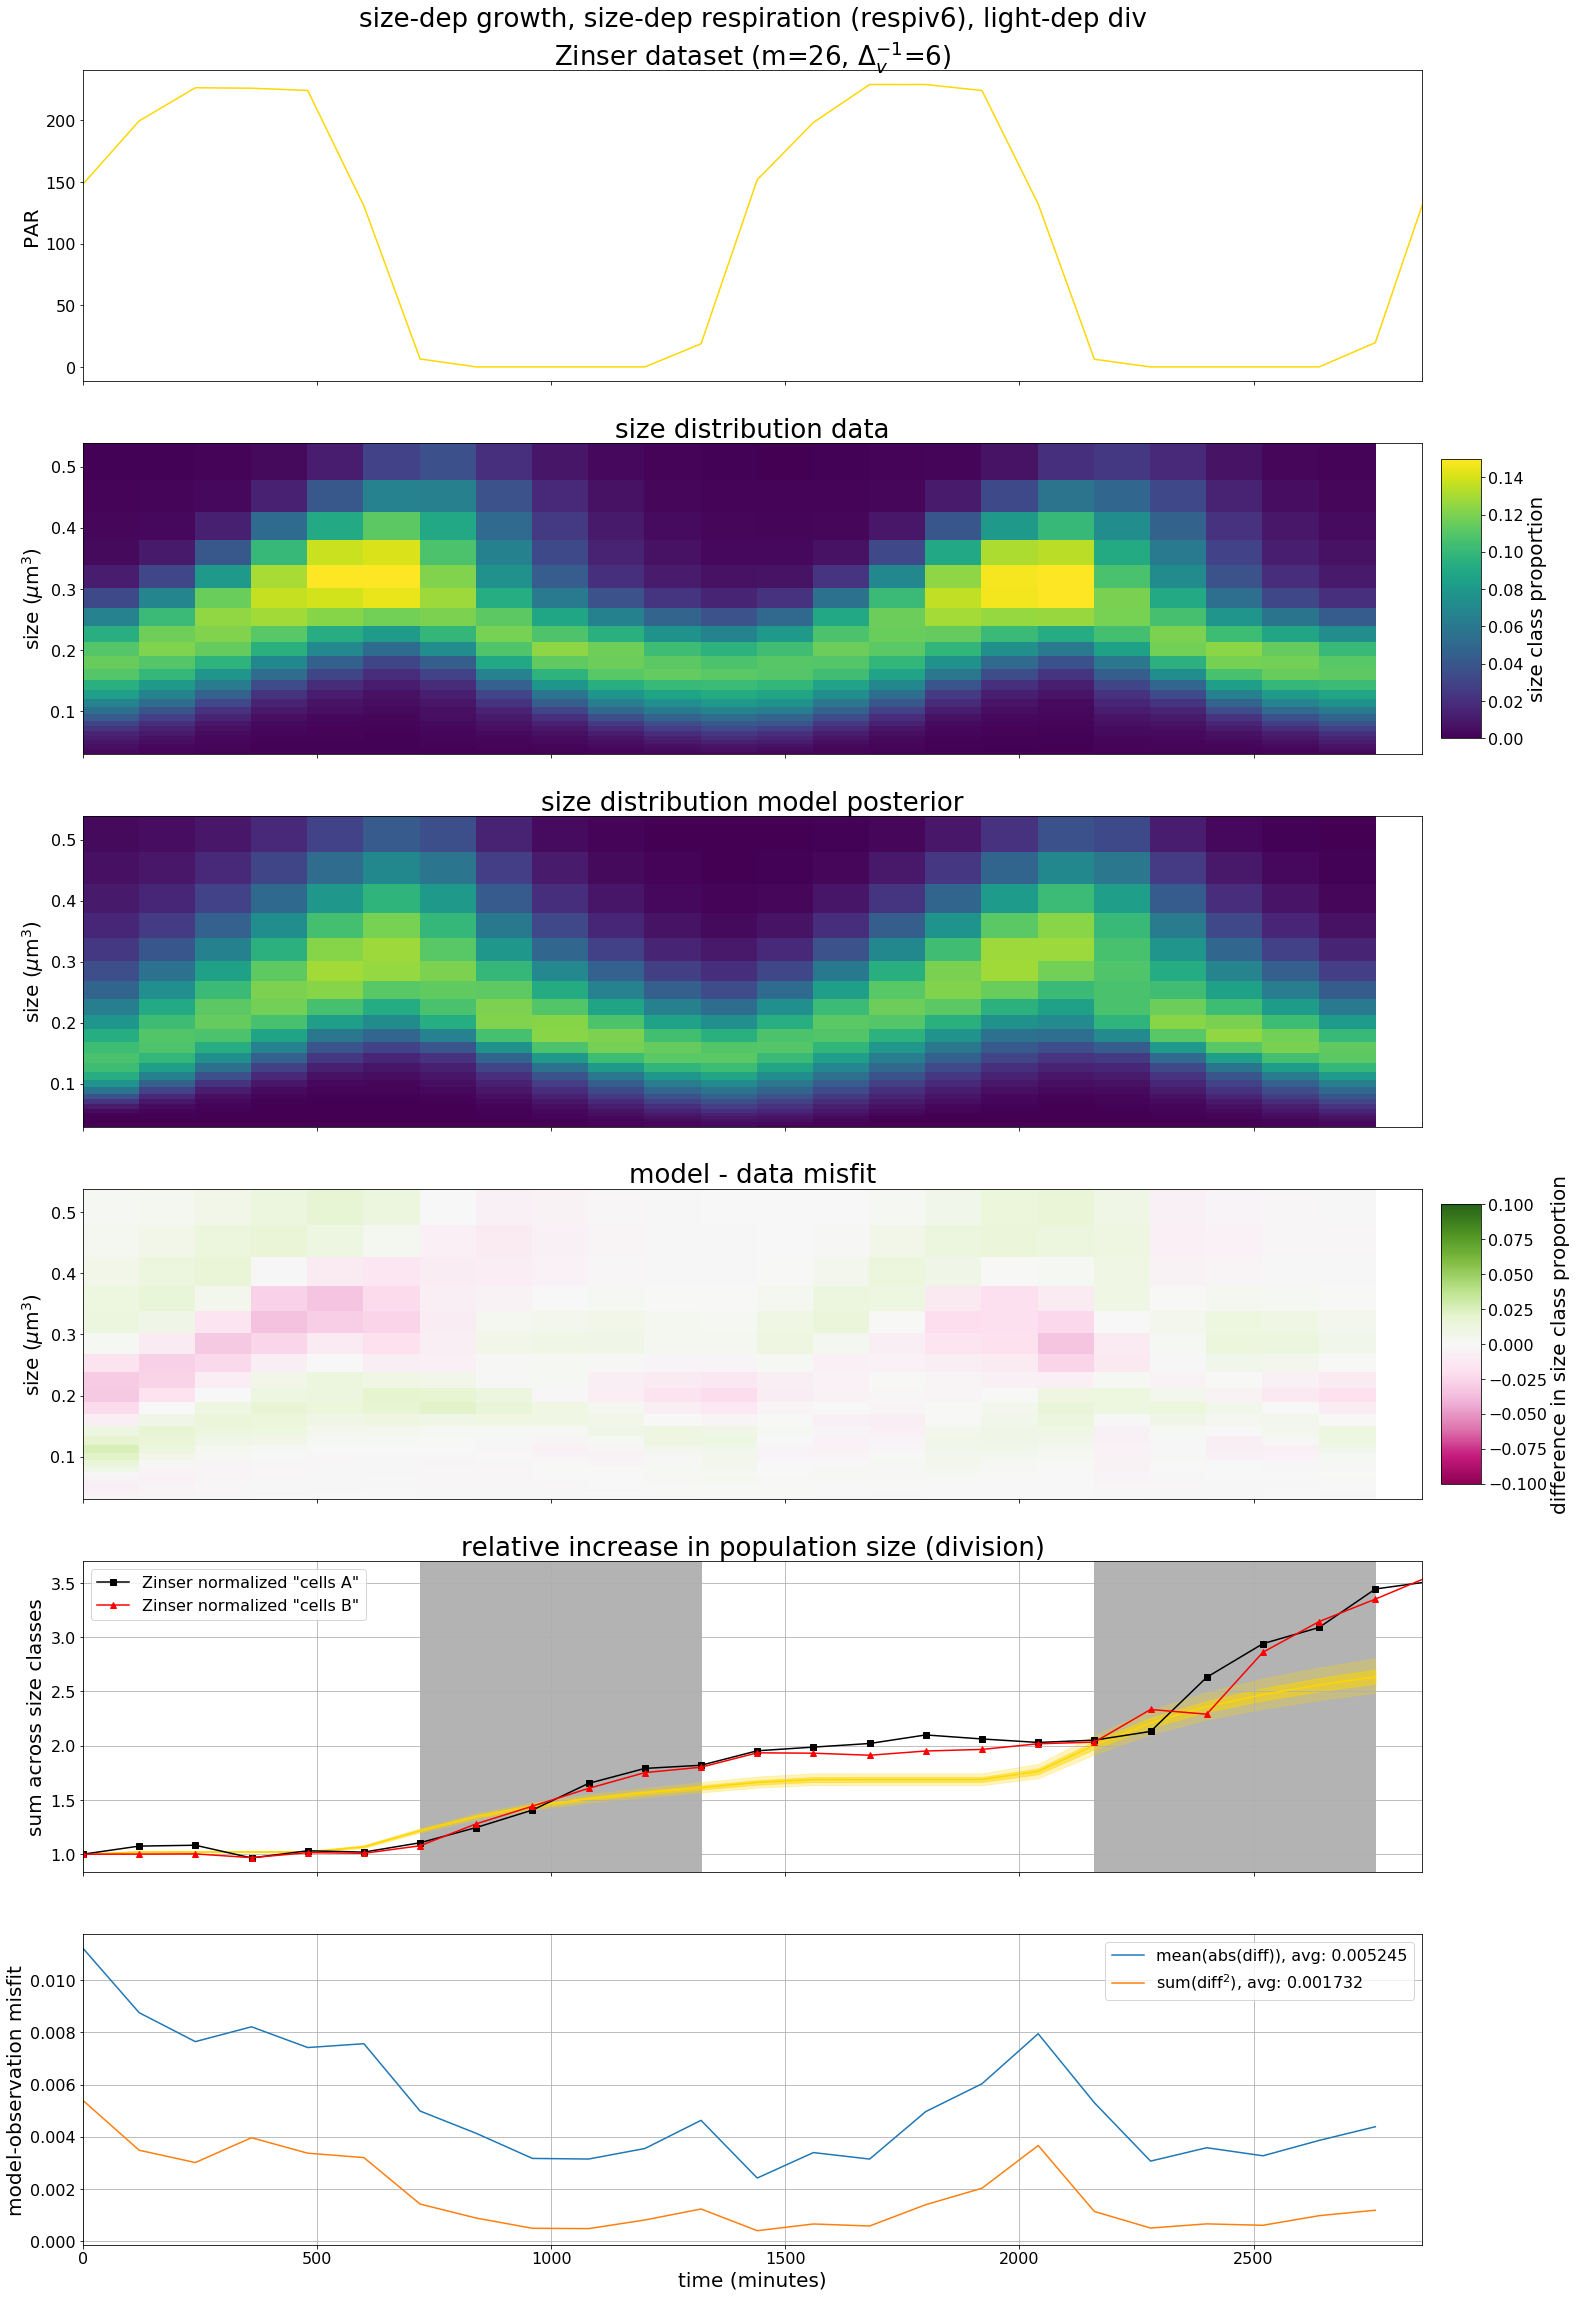

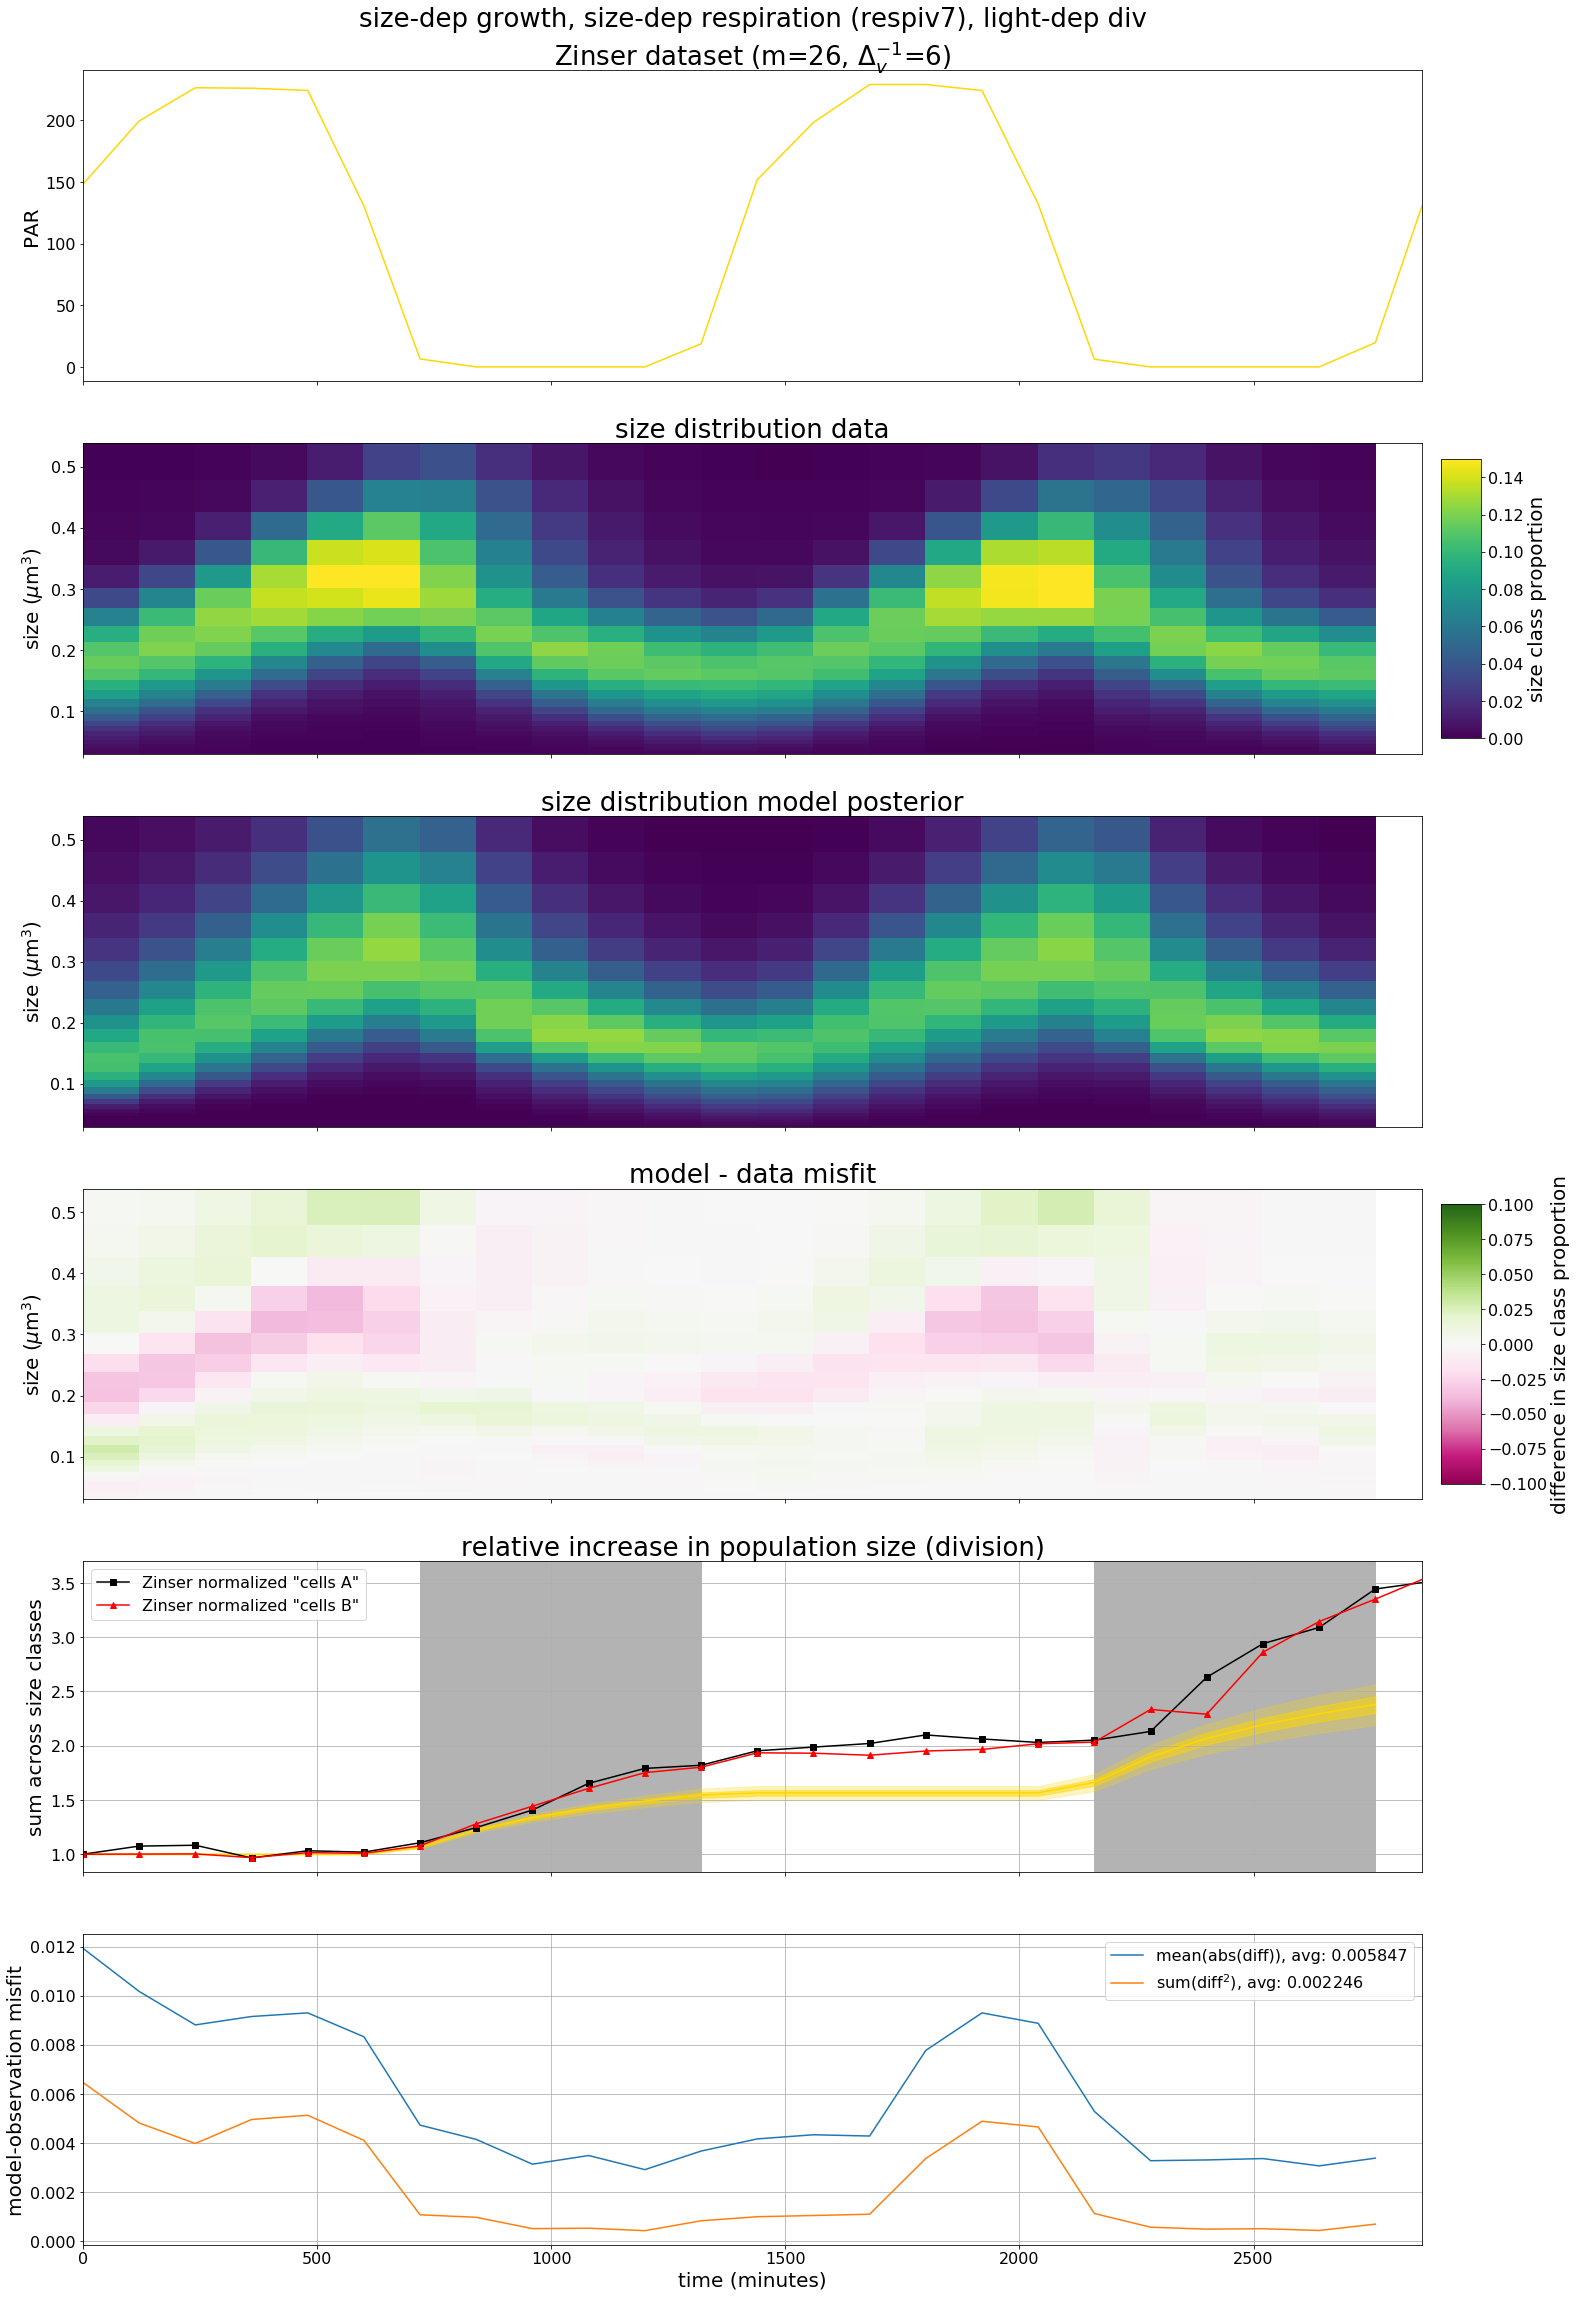

In [12]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.15)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    for name,mcmc in mcmcs.items():
        t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
        v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[name][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[name] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[name] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()

## a few new preliminary plots

In [13]:
# save data for plotting

import netCDF4 as nc4

for dataname in data:

    ncname = 'data_experimental_zinser_seaflow_20200603_gallery1_test2_{}.nc'.format(dataname)

    with nc4.Dataset(ncname, 'w') as nc:
        for i,name in enumerate(mcmcs):
            if i == 0:
                nc.createDimension('model', len(mcmcs))
                nc.createDimension('sample', mcmcs[name][dataname]['divrate'].shape[0])
            
                nc.createVariable('divrate', float, ('model','sample'))
                nc.createVariable('sumsqdiff', float, ('model','sample'))
                nc.variables['sumsqdiff'].setncattr('long_name', 'sum of squared column differences')
                
            nc.variables['divrate'][i,:] = mcmcs[name][dataname]['divrate']
            
            obs = data[dataname]['obs']

            tmp = mcmcs[name][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
            
            for iv,v in enumerate(('gamma_max','rho_max','xi','xir','E_star')):
                if i == 0:
                    nc.createVariable(v, float, ('model','sample'))
                if v in mcmcs[name][dataname].flatnames:
                    nc.variables[v][i,:] = mcmcs[name][dataname][v]

/home/paul/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paul/.local/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


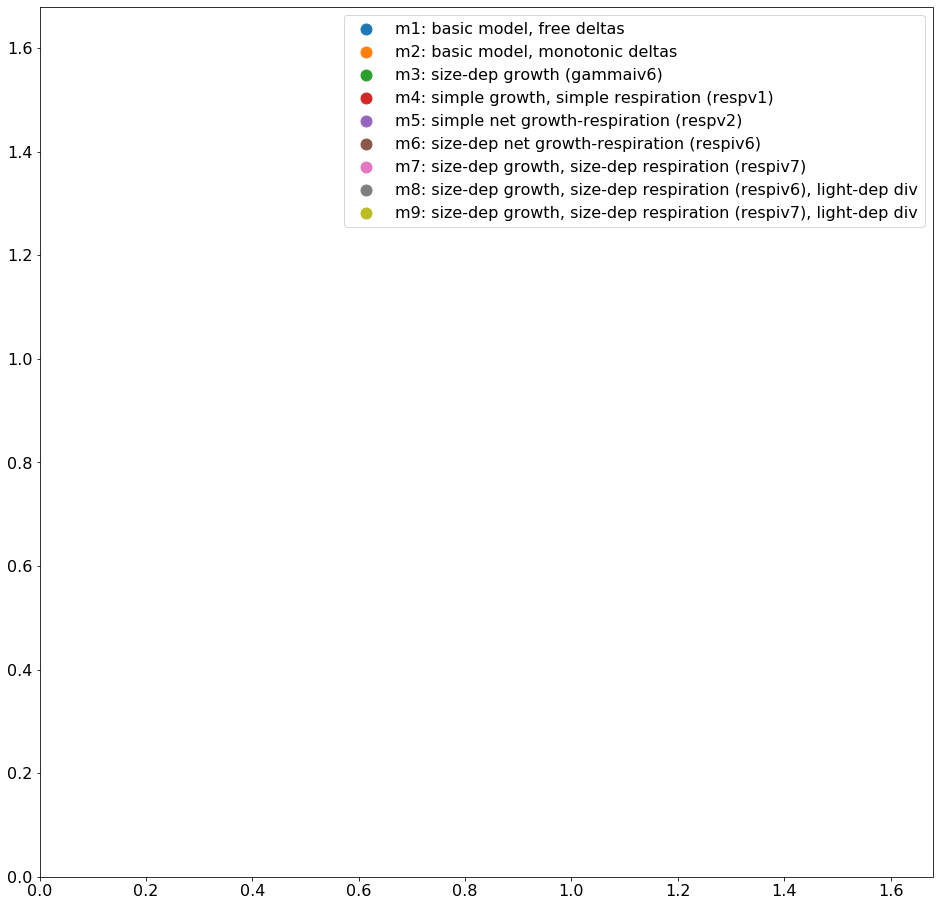

In [14]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.63}}

model_shortname = {name:name.replace('s','m') for name in mcmcs}

height = np.zeros(3)
for dataname in data:
    if 'zinser' in dataname:
        fig, ax = plt.subplots(figsize=(16,16))

        for name in mcmcs:
            # misfit to data

            obs = data[dataname]['obs']

            tmp = mcmcs[name][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2

            e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
            
            # misfit to division rate

            e1 = np.sqrt(np.mean((mcmcs[name][dataname]['divrate'] - reference_values[dataname]['divrate'])**2))
        
            ax.scatter(np.mean(e0), np.mean(e1), label=model_shortname[name]+': '+desc_model[name], s=120)
        
        ax.legend()
        ax.set_xlim(left=0.0)
        ax.set_ylim(bottom=0.0)
        '''
        xticks = []
        xticklabels = []
        for i,name in enumerate(mcmcs):
            

        if ax.get_ylim()[1] > 0.005:
            ax.set_ylim(top=0.005)
        ax.set(ylabel='sum of squared column differences', xticks=xticks)
        ax.set_title('model misfit for '+desc[dataname], size=20)
        ax.set_xticklabels(xticklabels)#, rotation=8)
        ax.grid(axis='y')
        '''

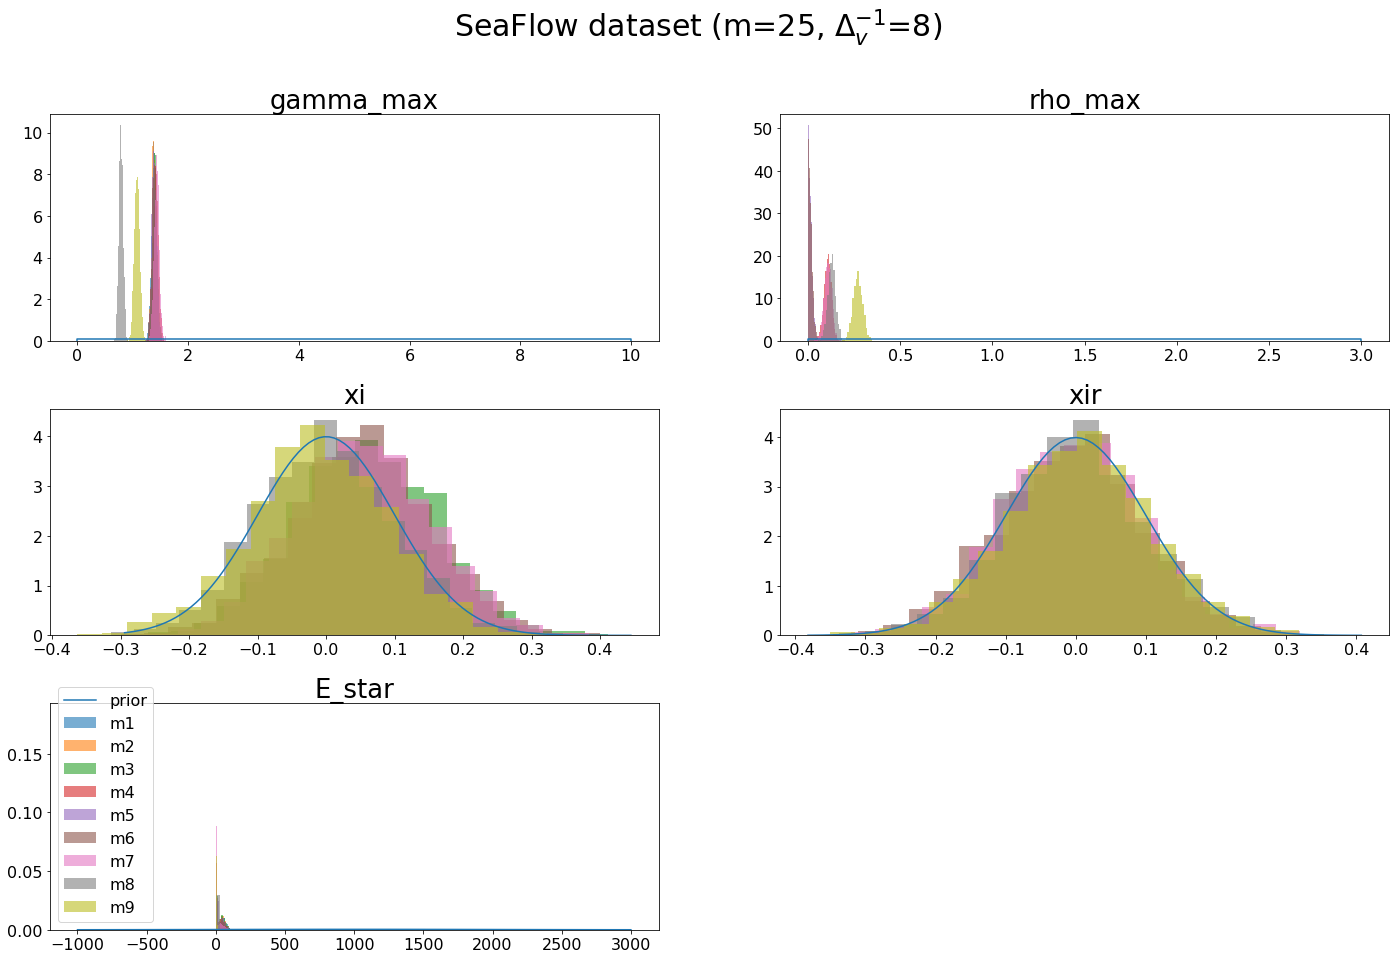

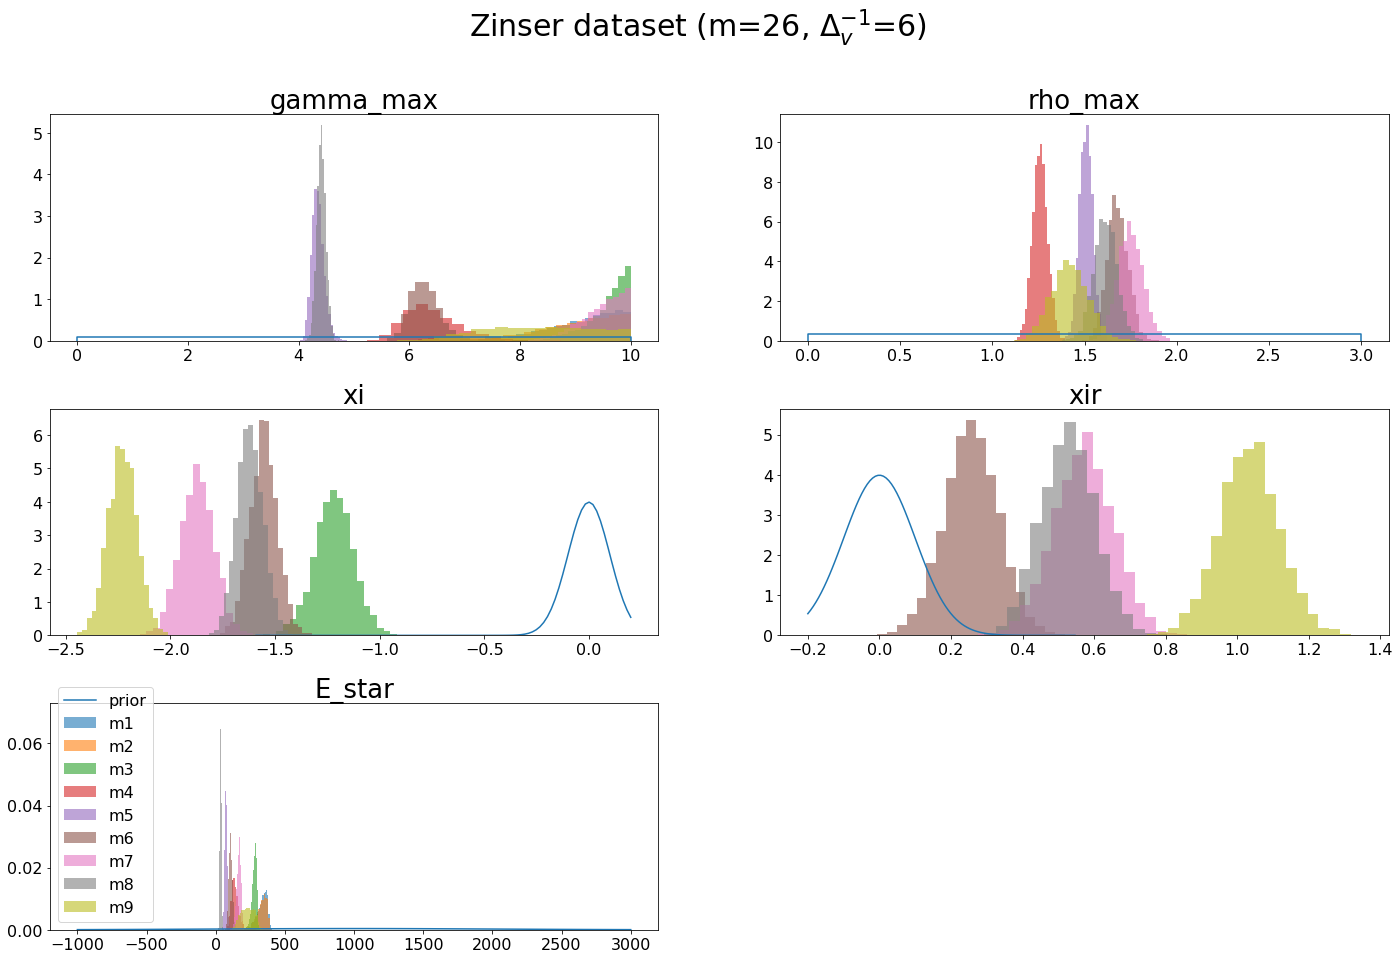

In [15]:
# plotinfo contains information about the prior distribution and the reference value of 
# the parameters and initial conditions used for plotting. If these are changed in the 
# code above, change them here as well. 
plotinfo = {
    'gamma_max':{'priordist':'uniform', 'priorparams':(0.0,10.0), 'refvalue':None},
    'rho_max':{'priordist':'uniform', 'priorparams':(0.0,3.0), 'refvalue':None},
    'xi':{'priordist':'normal', 'priorparams':(0.0,0.1), 'refvalue':None},
    'xir':{'priordist':'normal', 'priorparams':(0.0,0.1), 'refvalue':None},
    'E_star':{'priordist':'normal', 'priorparams':(1000.0,1000.0), 'refvalue':None},
}

import scipy.stats as stats

ncols = 2
nrows = int(np.ceil(len(plotinfo)/ncols))
for dataname in data:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 5*nrows), gridspec_kw={'hspace':0.3})
    fig.suptitle(desc[dataname], size=30)
    for ax in axs.flat:
        ax.set_visible(False)
    for ax,paramname in zip(axs.flat, plotinfo):
        ax.set_visible(True)
        plotted_prior = False
        for imodel,name in enumerate(mcmcs):
            if paramname in mcmcs[name][dataname].flatnames:
                ax.hist(mcmcs[name][dataname][paramname], bins=20, density=True, color='C{}'.format(imodel), label=model_shortname[name], alpha=0.6)
                xlim = ax.get_xlim()
                if not plotted_prior and 'priordist' in plotinfo[paramname]:
                    plotted_prior = True
                    if plotinfo[paramname]['priordist'] == 'normal':
                        p = plotinfo[paramname]['priorparams']
                        x_min = min(p[0]-2*p[1], xlim[0])
                        x_max = max(p[0]+2*p[1], xlim[1])
                        x = np.linspace(x_min, x_max, 100)
                        ax.plot(x, stats.norm.pdf(x, loc=p[0], scale=p[1]), label='prior')
                    elif plotinfo[paramname]['priordist'] == 'uniform':
                        p = plotinfo[paramname]['priorparams']
                        y = 1.0/(p[1]-p[0])
                        ax.plot([p[0],p[0],p[1],p[1]], [0,y,y,0], label='prior')
            #ax.axvline(plotinfo[name]['refvalue'], color='darkred', label='reference value')
            ax.set(title=paramname)
    ax.legend()
None